<a href="https://colab.research.google.com/github/skyshine460/GHG_Direct_Emissions/blob/main/submit_ghg25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 初期設定

In [593]:
# pip install pygeohash

In [594]:
# pip install catboost

In [595]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import joblib
import math

import pygeohash as pgh

from concurrent.futures import ThreadPoolExecutor

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import KFold
from sklearn.metrics import *
from sklearn.preprocessing import LabelEncoder

import gc
gc.collect()

import os

In [596]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# データの読み込み

In [597]:
# 予測モデルを訓練するためのデータセット
train_df = pd.read_csv('/content/drive/MyDrive/GHGの排出量の予測にチャレンジしよう！（SMBC Group GREEN×DATA Challenge 2024）/提供データ/train.csv')

# 予測モデルに推論（予測)させるデータセット
test_df = pd.read_csv('/content/drive/MyDrive/GHGの排出量の予測にチャレンジしよう！（SMBC Group GREEN×DATA Challenge 2024）/提供データ/test.csv')

In [598]:
# 各カラムのデータ型と欠損値（nan）を表示
def information_df(df):
    pd.set_option('display.max_rows', None)
    type_series = df.dtypes
    nunique_series = df.nunique()
    nan_count_series = df.isnull().sum()
    unique_values_series = df.apply(lambda col: list(col.unique()))
    info_df = pd.DataFrame({
        'dtypes': type_series,
        'NaN Count': nan_count_series,
        'Nunique': nunique_series,
        'Unique Values': unique_values_series,
    })
    print(df.shape)
    return info_df

def normal_distribution_fit(df, col):

    # 正規分布のフィッティング
    from scipy.stats import norm
    from scipy import stats
    import matplotlib.pyplot as plt
    import seaborn as sns

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    # カテゴリデータかどうかを判定
    if df[col].dtype == 'object' or df[col].dtype.name == 'category':
        # カテゴリデータの場合
        sns.countplot(x=df[col], ax=ax[0])
        ax[0].set_title('Bar Plot of Categorical Data')
    else:
        # 数値データの場合
        sns.histplot(df[col], kde=True, stat='density', ax=ax[0])
        # 正規分布のフィット
        sns.histplot(df[col], stat='density', ax=ax[0], bins=30)
        x = np.linspace(df[col].min(), df[col].max(), 100)
        ax[0].plot(x, norm.pdf(x, df[col].mean(), df[col].std()), color='red')
        ax[0].set_title('Histogram with Normal Distribution Fit')

        # Q-Qプロット
        stats.probplot(df[col], plot=ax[1])
        ax[1].set_title('Q-Q Plot')

    plt.tight_layout()
    plt.show()

    # 数値データの場合のみ歪度と尖度を計算
    if df[col].dtype != 'object' and df[col].dtype.name != 'category':
        print(f"Skewness: {df[col].skew()}")
        print(f"Kurtosis: {df[col].kurt()}")

    # 欠損値の確認
    print(f"isnull: {df[col].isnull().sum()}")

In [599]:
information_df(train_df)

(4655, 22)


,dtypes,NaN Count,Nunique,Unique Values
Unnamed: 0,int64,0,4655,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
FacilityName,object,0,4531,"[VISCOFAN USA INC, CORNWELL STATION - DOMINION..."
Latitude,float64,102,4492,"[40.141389, 38.475305, 39.29982, 35.490363, 41..."
Longitude,float64,102,4486,"[-87.581111, -81.278957, -80.85717, -119.04295..."
LocationAddress,object,179,4435,"[915 N MICHIGAN AVE, 200 RIVER HAVEN ROAD, 304..."
City,object,0,2588,"[DANVILLE, CLENDENIN, GREENWOOD, BAKERSFIELD, ..."
State,object,0,54,"[IL, WV, CA, OH, OK, NM, TN, LA, TX, IN, NC, M..."
ZIP,object,0,3758,"[61832, 25045-9304, 26415, 93308, 441031047, 7..."
County,object,70,1165,"[VERMILION, KANAWHA, RITCHIE, KERN, CUYAHOGA, ..."
FIPScode,float64,73,1646,"[17183.0, 54039.0, 54085.0, 6029.0, 39035.0, 4..."


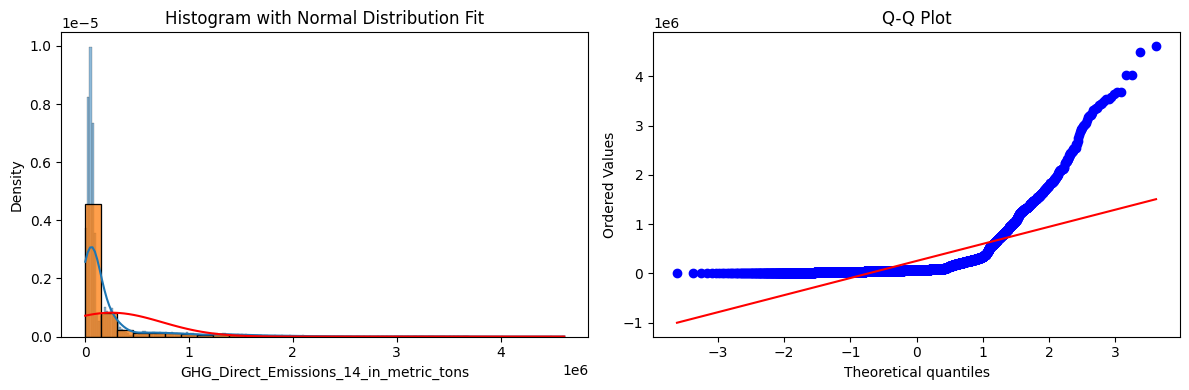

Skewness: 3.6649052199295338
Kurtosis: 16.560320863687245
isnull: 0


In [600]:
normal_distribution_fit(train_df, 'GHG_Direct_Emissions_14_in_metric_tons')

評価指標はRMSLEであり、ヒストグラムも右に裾が長いグラフなので、対数変換を行う。

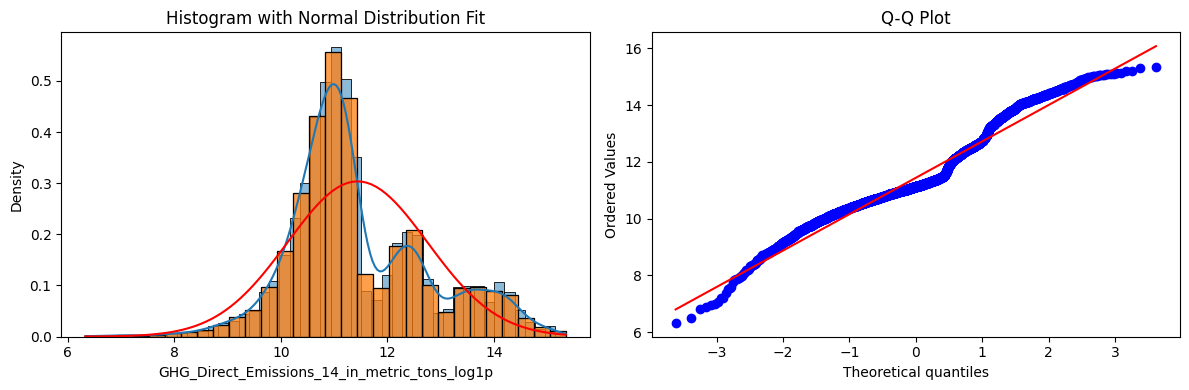

Skewness: 0.545884275422693
Kurtosis: 0.3515490436747801
isnull: 0


In [601]:
train_df['GHG_Direct_Emissions_14_in_metric_tons_log1p'] = np.log1p(train_df['GHG_Direct_Emissions_14_in_metric_tons'])
normal_distribution_fit(train_df, 'GHG_Direct_Emissions_14_in_metric_tons_log1p')

In [602]:
information_df(test_df)

(2508, 21)


,dtypes,NaN Count,Nunique,Unique Values
Unnamed: 0,int64,0,2508,"[4655, 4656, 4657, 4658, 4659, 4660, 4661, 466..."
FacilityName,object,0,2462,"[ROGER AOTSCHEGAROW, EPNG STATION 6543 LORDSBU..."
Latitude,float64,56,2437,"[38.03304, 32.31603, 41.2515, 44.95966, 32.818..."
Longitude,float64,56,2435,"[-97.97317, -108.6068, -78.74244, -93.19341, -..."
LocationAddress,object,113,2386,"[1910 SOUTH BROADACRES ROAD, nan, 3831 ROUTE 2..."
City,object,0,1647,"[HUTCHINSON, LORDSBURG, BROCKPORT, SAINT PAUL,..."
State,object,0,54,"[KS, NM, PA, MN, CA, MS, MT, AZ, IN, NY, IL, F..."
ZIP,object,0,2152,"[67501, 88045, 15823, 551141895, 92123, 38606,..."
County,object,45,865,"[RENO, HIDALGO, JEFFERSON, RAMSEY, SAN DIEGO, ..."
FIPScode,float64,45,1162,"[20155.0, 35023.0, 42065.0, 27123.0, 6073.0, 2..."


In [603]:
def merge_train_test(df_train, df_test):
    if "is_train" not in df_test.columns.tolist():
        df_train["is_train"] = 100
        df_test["is_train"] = -100
    res = pd.concat([df_train, df_test])
    res.reset_index(inplace=True, drop=True)
    return res

def split_train_test(df):
    df_train = df[df["is_train"] != -100]
    df_test = df[df["is_train"] == -100]
    df_train.reset_index(inplace=True, drop=True)
    df_test.reset_index(inplace=True, drop=True)
    return df_train, df_test

df = merge_train_test(train_df, test_df)

In [604]:
# object型をカテゴリ型に変換する
for col in df.columns:
    if df[col].dtype == "object":  # object型の列を探す
        df[col] = df[col].astype("category")  # カテゴリ型に変換

# Locationにかかわる特徴量

In [605]:
# import folium
# import matplotlib.cm as cm
# import matplotlib.colors as colors
# from IPython.display import display

# # 必要なデータを抽出し、新しいデータフレームを作成
# data = train_df[['Latitude', 'Longitude', 'GHG_Direct_Emissions_14_in_metric_tons']].copy()

# # 緯度、経度、排出量のいずれかが欠損している行を削除
# data.dropna(subset=['Latitude', 'Longitude', 'GHG_Direct_Emissions_14_in_metric_tons'], inplace=True)

# # 各列のデータ型を float に変換
# for col in ['Latitude', 'Longitude', 'GHG_Direct_Emissions_14_in_metric_tons']:
#     data[col] = data[col].astype(float)

# # 地図の中心をデータの緯度と経度の平均位置に設定
# map_center = [data['Latitude'].mean(), data['Longitude'].mean()]
# m = folium.Map(location=map_center, zoom_start=5)

# # 排出量の最大値と最小値を取得
# max_emission = data['GHG_Direct_Emissions_14_in_metric_tons'].max()
# min_emission = data['GHG_Direct_Emissions_14_in_metric_tons'].min()

# # カラーマップを設定（排出量が少ない地点は黄色、多い地点は赤色で表示）
# colormap = cm.get_cmap('YlOrRd')
# normalize = colors.Normalize(vmin=min_emission, vmax=max_emission)

# # 各地点に対して、排出量に応じた色の円マーカーを作成し地図に追加
# for idx, row in data.iterrows():
#     # 排出量に基づいて色を設定
#     color = colors.rgb2hex(colormap(normalize(row['GHG_Direct_Emissions_14_in_metric_tons'])))

#     # 円マーカーを作成
#     folium.CircleMarker(
#         location=[row['Latitude'], row['Longitude']],  # 緯度・経度
#         radius=5,  # 円のサイズ
#         popup=f"Emissions: {row['GHG_Direct_Emissions_14_in_metric_tons']}",  # ポップアップに排出量を表示
#         color=color,  # 枠の色
#         fill=True,  # 円を塗りつぶす
#         fill_color=color  # 塗りつぶしの色
#     ).add_to(m)

# # 地図を表示（Jupyter Notebook 上で表示可能）
# display(m)


GHGが高い場所はまばら。地域差や業種に集約できる可能性はあり。
欠損値はそのままとして進める。

# industryにかかわる特徴量

'PrimaryNAICS'について

数字に応じたグループあり。
特に最初の2文字が業種を表す。

In [606]:
naics_types      = {11: 'Agriculture, Forestry, Fishing and Hunting',
                    21: 'Mining, Quarrying, and Oil and Gas Extraction',
                    22: 'Utilities',
                    23: 'Construction',
                    31: 'Manufacturing',
                    32: 'Manufacturing',
                    33: 'Manufacturing',
                    42: 'Wholesale Trade',
                    44: 'Retail Trade',
                    45: 'Retail Trade',
                    48: 'Transportation and Warehousing',
                    49: 'Transportation and Warehousing',
                    51: 'Information',
                    52: 'Finance and Insurance',
                    53: 'Real Estate and Rental and Leasing',
                    54: 'Professional, Scientific, and Technical Services',
                    55: 'Management of Companies and Enterprises',
                    56: 'Administrative and Support and Waste Management and Remediation Services',
                    61: 'Educational Services',
                    62: 'Health Care and Social Assistance',
                    71: 'Arts, Entertainment, and Recreation',
                    72: 'Accommodation and Food Services',
                    81: 'Other Services (except Public Administration)',
                    92: 'Public Administration'}

In [607]:
df['PrimaryNAICS_1-2'] = df['PrimaryNAICS'].astype(str).str[:2].astype(int)
df['PrimaryNAICS_1-3'] = df['PrimaryNAICS'].astype(str).str[:3].astype(int)
df['PrimaryNAICS_1-4'] = df['PrimaryNAICS'].astype(str).str[:4].astype(int)
df['NAICS_Type'] = df['PrimaryNAICS_1-2'].map(naics_types).astype('category')

# 'na' などの変換できない値を NaN にしてから整数に変換
df['SecondPrimaryNAICS_1-2'] = pd.to_numeric(df['SecondPrimaryNAICS'].astype(str).str[:2], errors='coerce')
df['Sub_NAICS_Type'] = df['SecondPrimaryNAICS_1-2'].map(naics_types).astype('category')

数値の大きさに大きな意味はなさそうなので、categoryか新しい特徴量として使用するのが良いかもしれない。

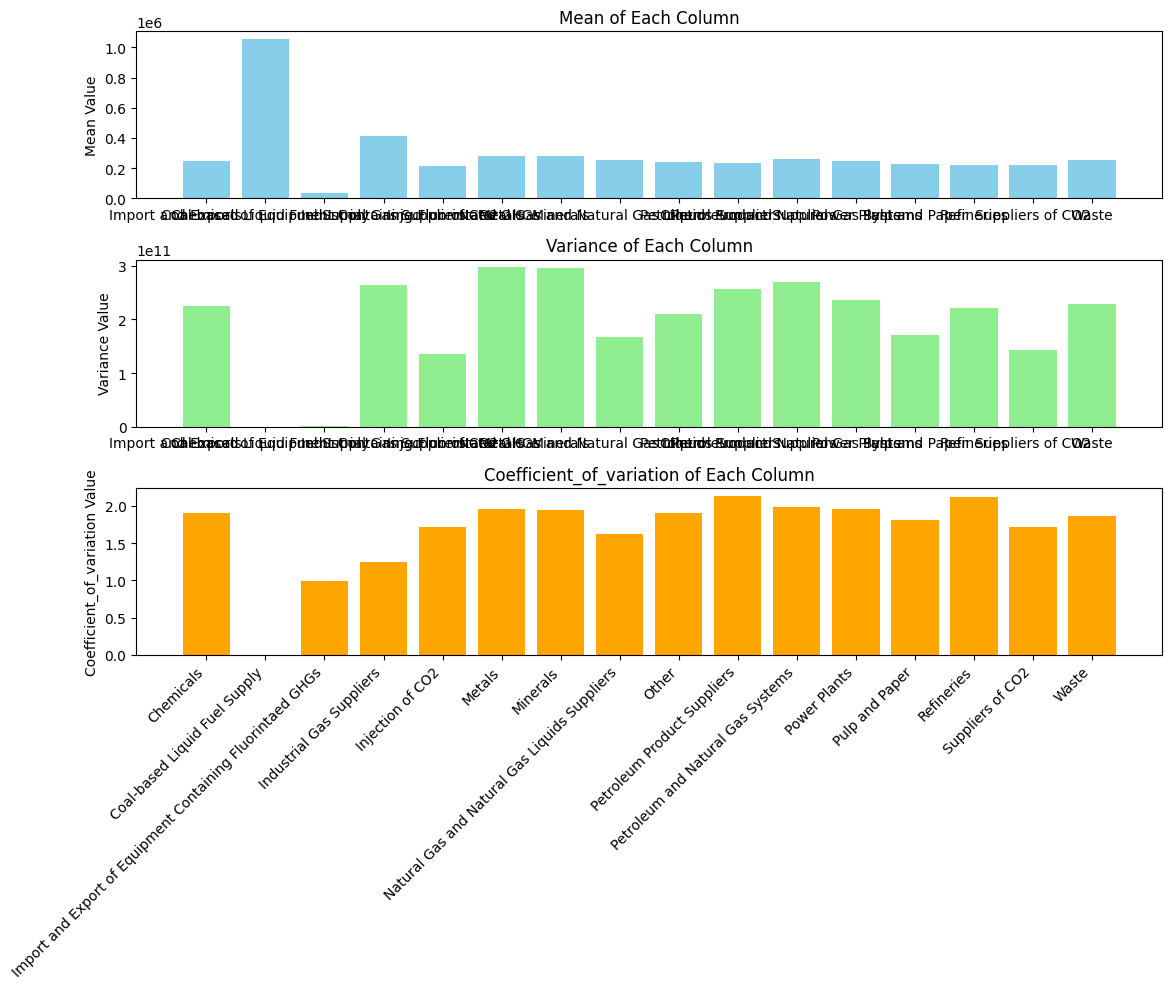

In [610]:
# 'IndustryType'の欠損値を'Other'で埋める
train_df['IndustryType'] = train_df['IndustryType'].fillna('Other')

# 'IndustryType'をカンマで分割し、リストにする
train_df['IndustryType'] = train_df['IndustryType'].str.split(',')

# # ワンホットエンコーディング
df_encoded_tr = train_df['IndustryType'].explode().str.get_dummies()

# 行方向に集約 (同じ業種に対して1を設定)
df_encoded_tr = df_encoded_tr.groupby(df_encoded_tr.index).sum()

# GHG_Direct_Emissions_14_in_metric_tons カラムを df_encoded に追加
df_encoded_tr['GHG_Direct_Emissions_14_in_metric_tons'] = train_df['GHG_Direct_Emissions_14_in_metric_tons']

# 各業種ごとの GHG_Direct_Emissions_14_in_metric_tons の平均と分散を計算
industry_columns = df_encoded_tr.columns.difference(['GHG_Direct_Emissions_14_in_metric_tons'])
mean_values = {}
variance_values = {}

for industry in industry_columns:
    # 業種ごとに「1」となっている行を抽出し、平均と分散を計算
    mean_value = df_encoded_tr.loc[df_encoded_tr[industry] == 1, 'GHG_Direct_Emissions_14_in_metric_tons'].mean()
    mean_values[industry] = mean_value
    variance_value = df_encoded_tr.loc[df_encoded_tr[industry] == 1, 'GHG_Direct_Emissions_14_in_metric_tons'].var()
    variance_values[industry] = variance_value

# 辞書を Pandas Series に変換
mean_series = pd.Series(mean_values)
variance_series = pd.Series(variance_values)

# 変動係数を計算
coefficient_of_variation = (variance_series ** 0.5) / mean_series

# グラフの描画
fig, ax = plt.subplots(3, 1, figsize=(12, 10))

# 平均値の棒グラフ
ax[0].bar(mean_series.index, mean_series.values, color='skyblue')
ax[0].set_title('Mean of Each Column')
ax[0].set_ylabel('Mean Value')
# ax[0].set_xticks(range(len(mean_series.index)))
# ax[0].set_xticklabels(mean_series.index, rotation=45, ha='right')

# 分散の棒グラフ
ax[1].bar(variance_series.index, variance_series.values, color='lightgreen')
ax[1].set_title('Variance of Each Column')
ax[1].set_ylabel('Variance Value')
# ax[1].set_xticks(range(len(variance_series.index)))
# ax[1].set_xticklabels(variance_series.index, rotation=45, ha='right')

# 分散の棒グラフ
ax[2].bar(coefficient_of_variation.index, coefficient_of_variation.values, color='orange')
ax[2].set_title('Coefficient_of_variation of Each Column')
ax[2].set_ylabel('Coefficient_of_variation Value')
ax[2].set_xticks(range(len(coefficient_of_variation.index)))
ax[2].set_xticklabels(coefficient_of_variation.index, rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [611]:
# 'IndustryType'の欠損値を'Other'で埋める
df['IndustryType'] = df['IndustryType'].fillna('Other')

# 'IndustryType'をカンマで分割し、リストにする
df['IndustryType'] = df['IndustryType'].str.split(',')

# # ワンホットエンコーディング
df_encoded = df['IndustryType'].explode().str.get_dummies()

# 行方向に集約 (同じ業種に対して1を設定)
df_encoded = df_encoded.groupby(df_encoded.index).sum()

In [612]:
# GHG_Direct_Emissions_14_in_metric_tons カラムを df_encoded に追加
df_encoded['GHG_Direct_Emissions_14_in_metric_tons'] = df['GHG_Direct_Emissions_14_in_metric_tons']

# 'IndustryType' 列の各リストに対して変動係数の平均を計算し、新しい列 'CV' を作成
def calculate_average_cv(industry_list):
    # 各業種の変動係数をリストから取得し、平均を計算
    cv_values = [coefficient_of_variation[industry] for industry in industry_list if industry in coefficient_of_variation.index]
    if len(cv_values) > 0:
        return sum(cv_values) / len(cv_values)
    else:
        return None

df['CV_IndustryType'] = df['IndustryType'].apply(calculate_average_cv)

# 結果を表示
df.head()



,Unnamed: 0,FacilityName,Latitude,Longitude,LocationAddress,City,State,ZIP,County,FIPScode,...,GHG_Direct_Emissions_14_in_metric_tons,GHG_Direct_Emissions_14_in_metric_tons_log1p,is_train,PrimaryNAICS_1-2,PrimaryNAICS_1-3,PrimaryNAICS_1-4,NAICS_Type,SecondPrimaryNAICS_1-2,Sub_NAICS_Type,CV_IndustryType
0,0,VISCOFAN USA INC,40.141389,-87.581111,915 N MICHIGAN AVE,DANVILLE,IL,61832,VERMILION,17183.0,...,52973.139946,10.877559,100,32,326,3261,Manufacturing,NaN,NaN,1.904437
1,1,"CORNWELL STATION - DOMINION TRANSMISSION, INC",38.475305,-81.278957,200 RIVER HAVEN ROAD,CLENDENIN,WV,25045-9304,KANAWHA,54039.0,...,55910.066617,10.931518,100,48,486,4862,Transportation and Warehousing,NaN,NaN,1.989387
2,2,WEST UNION COMPRESSOR STATION,39.299820,-80.857170,3041 LONG RUN RD.,GREENWOOD,WV,26415,RITCHIE,54085.0,...,55679.543214,10.927386,100,21,211,2111,"Mining, Quarrying, and Oil and Gas Extraction",NaN,NaN,1.989387
3,3,"DOUBLE ""C"" LIMITED",35.490363,-119.042957,10245 OILFIELD ROAD,BAKERSFIELD,CA,93308,KERN,6029.0,...,61411.902782,11.025375,100,22,221,2211,Utilities,NaN,NaN,1.956989
4,4,LAKESHORE PLANT,41.532802,-81.636448,6800 S MARGINAL RD,CLEVELAND,OH,441031047,CUYAHOGA,39035.0,...,43100.469774,10.671312,100,22,221,2211,Utilities,NaN,NaN,1.956989


In [613]:
def create_features1(df):

    df['TRI_diff_11-10'] = df['TRI_Air_Emissions_11_in_lbs'] - df['TRI_Air_Emissions_10_in_lbs']
    df['TRI_diff_12-11'] = df['TRI_Air_Emissions_12_in_lbs'] - df['TRI_Air_Emissions_11_in_lbs']
    df['TRI_diff_13-12'] = df['TRI_Air_Emissions_13_in_lbs'] - df['TRI_Air_Emissions_12_in_lbs']

    df['TRI_Growth_Rate_11'] = np.where(
        df['TRI_Air_Emissions_10_in_lbs'].notna() & (df['TRI_Air_Emissions_10_in_lbs'] != 0),
        (df['TRI_Air_Emissions_11_in_lbs'] - df['TRI_Air_Emissions_10_in_lbs']) / df['TRI_Air_Emissions_10_in_lbs'],
        np.nan
    )

    df['TRI_Growth_Rate_12'] = np.where(
        df['TRI_Air_Emissions_11_in_lbs'].notna() & (df['TRI_Air_Emissions_11_in_lbs'] != 0),
        (df['TRI_Air_Emissions_12_in_lbs'] - df['TRI_Air_Emissions_11_in_lbs']) / df['TRI_Air_Emissions_11_in_lbs'],
        np.nan
    )

    df['TRI_Growth_Rate_13'] = np.where(
        df['TRI_Air_Emissions_12_in_lbs'].notna() & (df['TRI_Air_Emissions_12_in_lbs'] != 0),
        (df['TRI_Air_Emissions_13_in_lbs'] - df['TRI_Air_Emissions_12_in_lbs']) / df['TRI_Air_Emissions_12_in_lbs'],
        np.nan
    )

    return df

df       = create_features1(df)
new_features1 = ['TRI_diff_11-10','TRI_diff_12-11','TRI_diff_13-12', 'TRI_Growth_Rate_11','TRI_Growth_Rate_12','TRI_Growth_Rate_13']

In [614]:
def grouping_calculation(df, features_colc, group_col):
    for col in features_colc:
        # ジャンルごとの平均値と標準偏差を計算
        group_stats = df.groupby(group_col)[col].agg(['min', 'max', 'mean', 'std']).reset_index()
        group_stats.rename(columns={'min': col+'_min_'+group_col, 'max': col+'_max_'+group_col, 'mean': col+'_mean_'+group_col, 'std': col+'_std_'+group_col}, inplace=True)

        # 元のデータフレームにマージ
        df = pd.merge(df, group_stats, on=group_col, how='left')

        # 最小、最大、平均値との差の絶対値を計算
        df[col+'_diff_mean'] = abs(df[col] - df[col+'_mean_'+group_col])
        df[col+'_diff_min'] = abs(df[col] - df[col+'_min_'+group_col])
        df[col+'_diff_max'] = abs(df[col] - df[col+'_max_'+group_col])


        # 標準化を計算
        df[col+'_z'] = (df[col] - df[col+'_mean_'+group_col]) / df[col+'_std_'+group_col]

        # q1とq3を計算
        group_qstats = df.groupby(group_col)[col].agg([
            ('Q1', lambda x: x.quantile(0.25)),  # 第1四分位数
            ('Q3', lambda x: x.quantile(0.75))   # 第3四分位数
        ]).reset_index()

        # 四分位範囲 (IQR) を計算
        group_qstats['IQR'] = group_qstats['Q3'] - group_qstats['Q1']
        group_qstats.rename(columns={'Q1': col+'_q1_'+group_col, 'Q3': col+'_q3_'+group_col, 'IQR': col+'_iqr_'+group_col}, inplace=True)

        # 元のデータフレームにマージ
        df = pd.merge(df, group_qstats, on=group_col, how='left')

    return df

features_colc = ['GHG_Direct_Emissions_10_in_metric_tons', 'GHG_Direct_Emissions_11_in_metric_tons', 'GHG_Direct_Emissions_12_in_metric_tons', 'GHG_Direct_Emissions_13_in_metric_tons']
group_col = 'PrimaryNAICS_1-2'
df = grouping_calculation(df, features_colc, group_col)
df.columns.tolist()

['Unnamed: 0',
 'FacilityName',
 'Latitude',
 'Longitude',
 'LocationAddress',
 'City',
 'State',
 'ZIP',
 'County',
 'FIPScode',
 'PrimaryNAICS',
 'SecondPrimaryNAICS',
 'IndustryType',
 'TRI_Air_Emissions_10_in_lbs',
 'TRI_Air_Emissions_11_in_lbs',
 'TRI_Air_Emissions_12_in_lbs',
 'TRI_Air_Emissions_13_in_lbs',
 'GHG_Direct_Emissions_10_in_metric_tons',
 'GHG_Direct_Emissions_11_in_metric_tons',
 'GHG_Direct_Emissions_12_in_metric_tons',
 'GHG_Direct_Emissions_13_in_metric_tons',
 'GHG_Direct_Emissions_14_in_metric_tons',
 'GHG_Direct_Emissions_14_in_metric_tons_log1p',
 'is_train',
 'PrimaryNAICS_1-2',
 'PrimaryNAICS_1-3',
 'PrimaryNAICS_1-4',
 'NAICS_Type',
 'SecondPrimaryNAICS_1-2',
 'Sub_NAICS_Type',
 'CV_IndustryType',
 'TRI_diff_11-10',
 'TRI_diff_12-11',
 'TRI_diff_13-12',
 'TRI_Growth_Rate_11',
 'TRI_Growth_Rate_12',
 'TRI_Growth_Rate_13',
 'GHG_Direct_Emissions_10_in_metric_tons_min_PrimaryNAICS_1-2',
 'GHG_Direct_Emissions_10_in_metric_tons_max_PrimaryNAICS_1-2',
 'GHG_Dire

In [615]:
train_distance = pd.read_csv('/content/drive/MyDrive/GHGの排出量の予測にチャレンジしよう！（SMBC Group GREEN×DATA Challenge 2024）/特徴量/train_distance_5nbrs_.csv')
test_distance = pd.read_csv('/content/drive/MyDrive/GHGの排出量の予測にチャレンジしよう！（SMBC Group GREEN×DATA Challenge 2024）/特徴量/test_distance_5nbrs_.csv')

In [616]:
# def haversine(lat1, lon1, lat2, lon2):
#     # Convert latitude and longitude from degrees to radians
#     lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

#     # Haversine formula
#     dlat = lat2 - lat1
#     dlon = lon2 - lon1
#     a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
#     c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

#     # Radius of Earth in kilometers (mean radius)
#     R = 6371.0

#     # Calculate the distance
#     distance = R * c
#     return distance

# def calculate_distance(lat1, lon1, lat2, lon2):
#     return haversine(lat1, lon1, lat2, lon2)

# def get_nearest_distance(lat1, lon1, econ_sector_ref, neighbours=5, train_point=False):
#     # Extract the required columns once to NumPy arrays
#     latitudes = train_df['Latitude'].values
#     longitudes = train_df['Longitude'].values
#     ghg_emissions = train_df['GHG_Direct_Emissions_14_in_metric_tons'].values
#     econ_sectors = train_df['NAICS_Type'].values

#     # Filter NaN emissions directly
#     valid_indices = ~np.isnan(ghg_emissions)

#     latitudes = latitudes[valid_indices]
#     longitudes = longitudes[valid_indices]
#     ghg_emissions = ghg_emissions[valid_indices]
#     econ_sectors = econ_sectors[valid_indices]

#     # Parallelize distance calculation using ThreadPoolExecutor
#     with ThreadPoolExecutor() as executor:
#         distances = list(executor.map(calculate_distance,
#                                      [lat1]*len(latitudes),
#                                      [lon1]*len(longitudes),
#                                      latitudes,
#                                      longitudes))

#     # Combine the results into a DataFrame
#     near_df = pd.DataFrame({
#         'Distance': distances,
#         'GHG_emission_14': ghg_emissions,
#         'Economic_Sector': econ_sectors
#     })


#     if train_point:
#         near_df.sort_values(by='Distance', inplace=True)
#         near_df = near_df.dropna()
#         near_df = near_df.iloc[1:].reset_index(drop=True)
#     else:
#         # Sort distances by 'Distance'
#         near_df.sort_values(by='Distance', inplace=True)
#         near_df = near_df.dropna()

#     # Filter by economic sector
#     nearest_locations_econ_sector = near_df[near_df['Economic_Sector'] == econ_sector_ref]

#     # Get the top N nearest for both economic sector and overall
#     sub_near_econ = nearest_locations_econ_sector.head(neighbours)
#     sub_nearest_locations = near_df.head(neighbours)

#     # Compute weighted averages
#     econ_weighted_average = (sub_near_econ['GHG_emission_14'] / np.where(sub_near_econ['Distance'] == 0, 1, sub_near_econ['Distance']) ).sum()
#     near_weighted_average = (sub_nearest_locations['GHG_emission_14'] / np.where(sub_nearest_locations['Distance']==0,1,sub_nearest_locations['Distance'])).sum()

#     # Compute regular averages
#     econ_average = sub_near_econ['GHG_emission_14'].mean()
#     near_average = sub_nearest_locations['GHG_emission_14'].mean()

#     return [econ_weighted_average, econ_average, near_weighted_average, near_average]

In [617]:
# neighbours = 5

# file_path = f"test_distance_{neighbours}nbrs.csv"
# if os.path.exists(file_path):
#     print(f"{file_path} exists. ")
#     test_distance = pd.read_csv(f"test_distance_{neighbours}nbrs.csv")
# else:
#     output = []
#     for index in tqdm(range(test_df.shape[0])):

#         lat1 = test_df.iloc[index]['Latitude']
#         lon1 = test_df.iloc[index]['Longitude']
#         econ_sector_ref = test_df.iloc[index]['NAICS_Type']
#         x = get_nearest_distance(lat1,lon1,econ_sector_ref,neighbours=neighbours,train_point=False)
#         output.append(x)
#     test_distance = pd.DataFrame(output,columns = ['Economy_Sector_Weighted_Avg','Economic_Sector_Average','Nearest_Weighted_Average','Nearest_Average'])
#     test_distance.to_csv(f'test_distance_{neighbours}nbrs.csv',index=False)

# file_path = f"train_distance_{neighbours}nbrs.csv"
# if os.path.exists(file_path):
#     print(f"{file_path} exists. ")
#     train_distance = pd.read_csv(f'train_distance_{neighbours}nbrs.csv')
# else:
#     output = []
#     for index in tqdm(range(train_df.shape[0])):
#         lat1 = train_df.iloc[index]['Latitude']
#         lon1 = train_df.iloc[index]['Longitude']
#         econ_sector_ref = train_df.iloc[index]['NAICS_Type']
#         x = get_nearest_distance(lat1,lon1,econ_sector_ref,neighbours=neighbours, train_point=True)
#         output.append(x)
#     train_distance = pd.DataFrame(output,columns = ['Economy_Sector_Weighted_Avg','Economic_Sector_Average','Nearest_Weighted_Average','Nearest_Average'])
#     train_distance.to_csv(f'train_distance_{neighbours}nbrs.csv',index=False)

train_df, test_df = split_train_test(df)
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
train_df = pd.concat((train_df,train_distance),axis=1)

# インデックスをリセットしてから結合
test_df = test_df.reset_index(drop=True)
test_distance = test_distance.reset_index(drop=True)
test_df = pd.concat((test_df, test_distance), axis=1)

# train_df['Economy_Sector_Weighted_Avg'] = train_df['Economy_Sector_Weighted_Avg'].fillna(0)
# train_df['Economic_Sector_Average'] = train_df['Economic_Sector_Average'].fillna(0)

In [619]:
# import matplotlib.pyplot as plt

# # 散布図を描画
# scatter = plt.scatter(x=train_df['average_counts'], y=train_df['sum_counts'],
#                       c=train_df['GHG_Direct_Emissions_14_in_metric_tons_log1p'], cmap='plasma')

# # カラーバーを追加して、色の対応を示す
# plt.colorbar(scatter, label='GHG Direct Emissions (log1p)')

# # グラフにタイトルと軸ラベルを追加
# plt.title('Scatter plot of GHG emissions')
# plt.xlabel('average_counts')
# plt.ylabel('sum_counts')

# # グラフを表示
# plt.show()


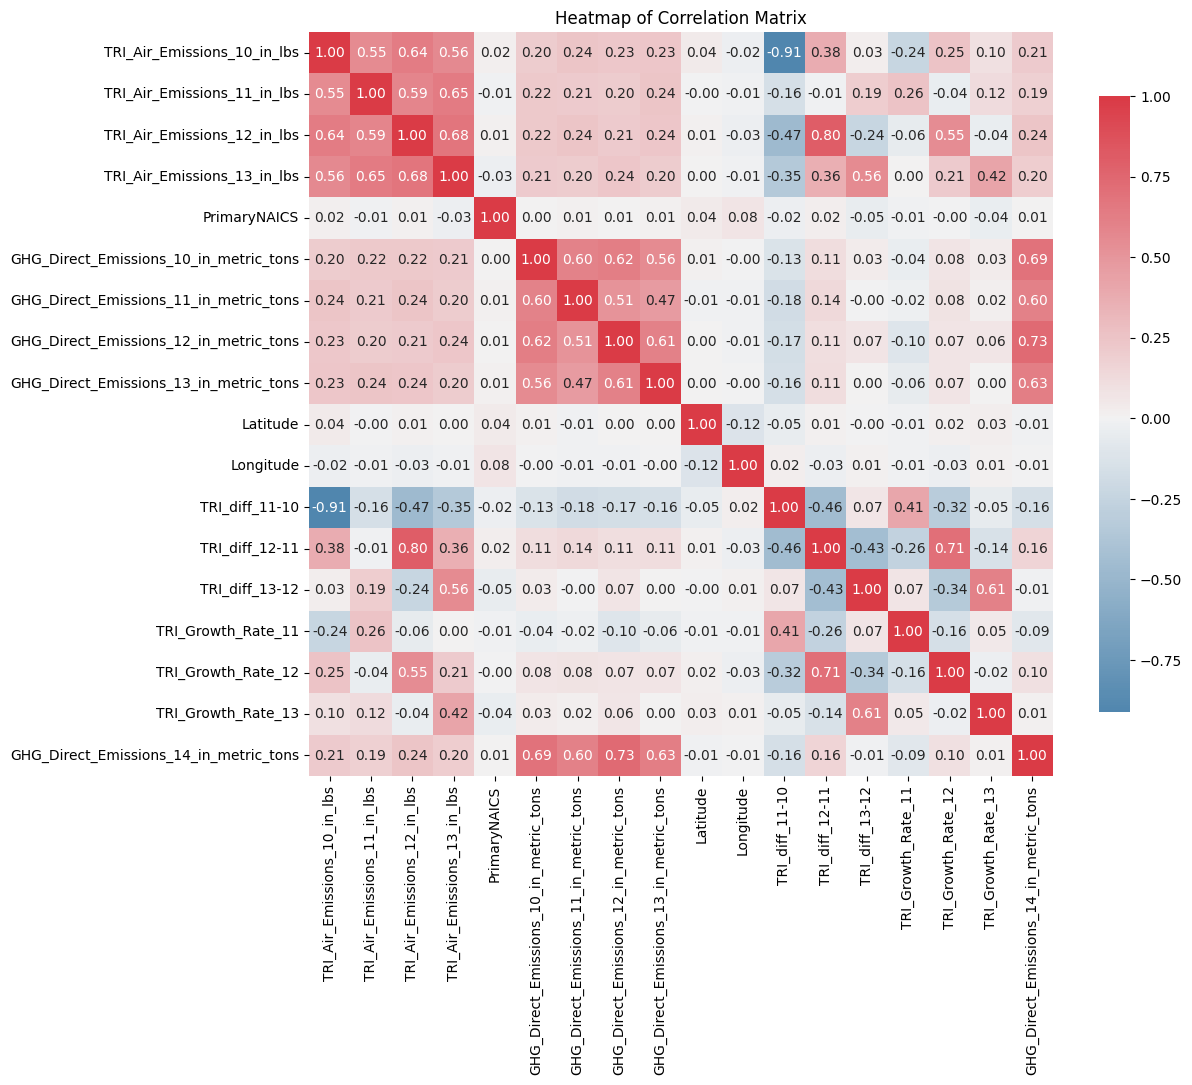

In [620]:
def plot_heatmap(df):
    # 数値データのみを抽出
    numeric_df = df.select_dtypes(include=['number'])

    # 相関行列を計算
    correlation_matrix = numeric_df.corr()

    # ヒートマップを描画
    plt.figure(figsize=(12, 10))  # サイズを大きくする
    sns.heatmap(
        correlation_matrix,
        annot=True,
        fmt='.2f',
        cmap=sns.diverging_palette(240, 10, as_cmap=True),  # 青から赤のカラーマップ
        center=0,  # 中心を0に設定
        square=True,
        cbar_kws={"shrink": .8},
        annot_kws={"size": 10}  # アノテーションのフォントサイズを設定
    )
    plt.title('Heatmap of Correlation Matrix', fontsize=12)  # タイトルのフォントサイズを設定
    plt.show()

features_heat = ['TRI_Air_Emissions_10_in_lbs', 'TRI_Air_Emissions_11_in_lbs',
                    'TRI_Air_Emissions_12_in_lbs', 'TRI_Air_Emissions_13_in_lbs','PrimaryNAICS',
                    'GHG_Direct_Emissions_10_in_metric_tons', 'GHG_Direct_Emissions_11_in_metric_tons',
                    'GHG_Direct_Emissions_12_in_metric_tons', 'GHG_Direct_Emissions_13_in_metric_tons',
                        'Latitude','Longitude',
                        'TRI_diff_11-10','TRI_diff_12-11','TRI_diff_13-12',
                        'TRI_Growth_Rate_11','TRI_Growth_Rate_12','TRI_Growth_Rate_13',
                        'NAICS_Type','State',]
df_train_heat = train_df[features_heat + ['GHG_Direct_Emissions_14_in_metric_tons']]
plot_heatmap(df_train_heat)

In [635]:
train_df['GHG_Direct_Emissions_10_in_metric_tons_log1p'] = np.log1p(train_df['GHG_Direct_Emissions_10_in_metric_tons'])
train_df['GHG_Direct_Emissions_11_in_metric_tons_log1p'] = np.log1p(train_df['GHG_Direct_Emissions_11_in_metric_tons'])
train_df['GHG_Direct_Emissions_12_in_metric_tons_log1p'] = np.log1p(train_df['GHG_Direct_Emissions_12_in_metric_tons'])
train_df['GHG_Direct_Emissions_13_in_metric_tons_log1p'] = np.log1p(train_df['GHG_Direct_Emissions_13_in_metric_tons'])

train_df['TRI_Air_Emissions_10_in_lbs_log1p'] = np.log1p(train_df['TRI_Air_Emissions_10_in_lbs'])
train_df['TRI_Air_Emissions_11_in_lbs_log1p'] = np.log1p(train_df['TRI_Air_Emissions_11_in_lbs'])
train_df['TRI_Air_Emissions_12_in_lbs_log1p'] = np.log1p(train_df['TRI_Air_Emissions_12_in_lbs'])
train_df['TRI_Air_Emissions_13_in_lbs_log1p'] = np.log1p(train_df['TRI_Air_Emissions_13_in_lbs'])

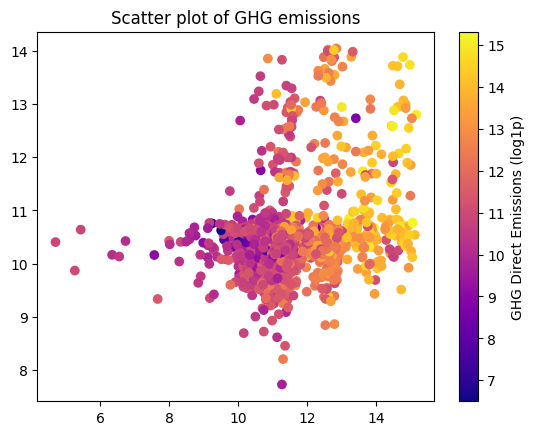

In [640]:
# 散布図を描画
scatter = plt.scatter(x=train_df['GHG_Direct_Emissions_10_in_metric_tons_log1p'], y=train_df['TRI_Air_Emissions_10_in_lbs_log1p'],
                      c=train_df['GHG_Direct_Emissions_14_in_metric_tons_log1p'], cmap='plasma')

# カラーバーを追加して、色の対応を示す
plt.colorbar(scatter, label='GHG Direct Emissions (log1p)')

# グラフにタイトルと軸ラベルを追加
plt.title('Scatter plot of GHG emissions')

# グラフを表示
plt.show()

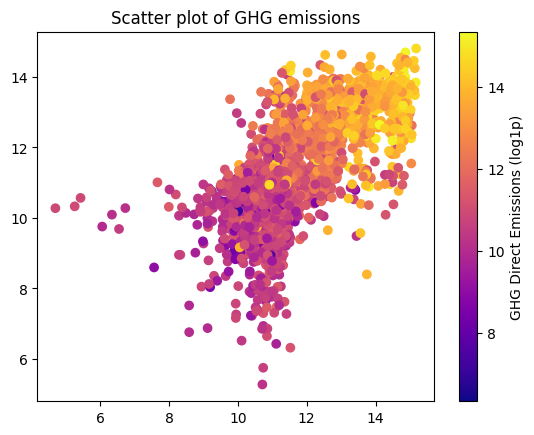

In [642]:
# 散布図を描画
scatter = plt.scatter(x=train_df['GHG_Direct_Emissions_10_in_metric_tons_log1p'], y=train_df['GHG_Direct_Emissions_11_in_metric_tons_log1p'],
                      c=train_df['GHG_Direct_Emissions_14_in_metric_tons_log1p'], cmap='plasma')

# カラーバーを追加して、色の対応を示す
plt.colorbar(scatter, label='GHG Direct Emissions (log1p)')

# グラフにタイトルと軸ラベルを追加
plt.title('Scatter plot of GHG emissions')

# グラフを表示
plt.show()

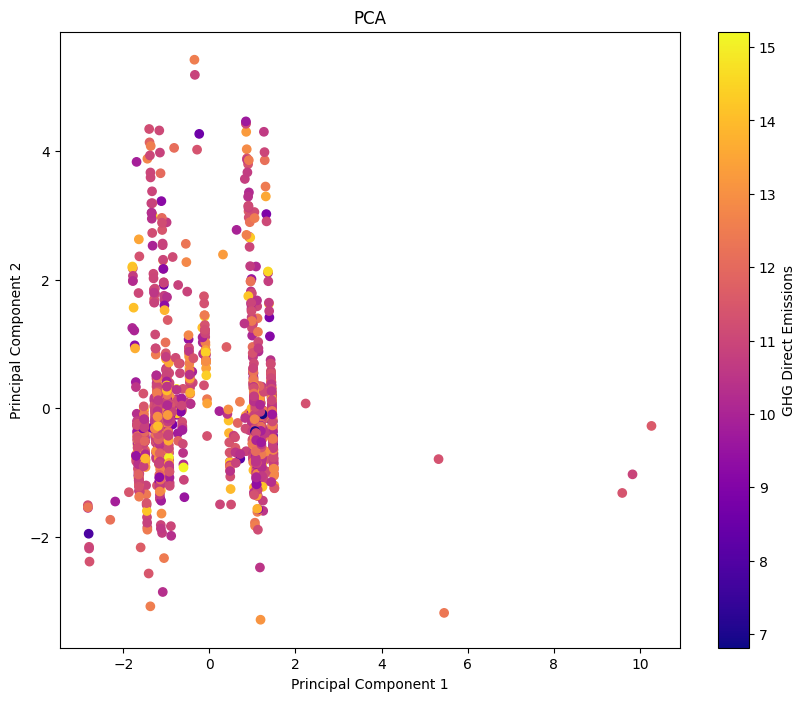

(4655, 95)


In [652]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 特徴量のリスト
feature_num = [
                    # 'GHG_Direct_Emissions_10_in_metric_tons_log1p',
                    'TRI_Air_Emissions_10_in_lbs_log1p',
                    'CV_IndustryType',
                    #  'GHG_Direct_Emissions_10_in_metric_tons_min_PrimaryNAICS_1-2',
#  'GHG_Direct_Emissions_10_in_metric_tons_max_PrimaryNAICS_1-2',
#  'GHG_Direct_Emissions_10_in_metric_tons_mean_PrimaryNAICS_1-2',
 'GHG_Direct_Emissions_10_in_metric_tons_std_PrimaryNAICS_1-2',
#  'GHG_Direct_Emissions_10_in_metric_tons_diff_mean',
#  'GHG_Direct_Emissions_10_in_metric_tons_diff_min',
#  'GHG_Direct_Emissions_10_in_metric_tons_diff_max',
#  'GHG_Direct_Emissions_10_in_metric_tons_z',
#  'GHG_Direct_Emissions_10_in_metric_tons_q1_PrimaryNAICS_1-2',
#  'GHG_Direct_Emissions_10_in_metric_tons_q3_PrimaryNAICS_1-2',
 'GHG_Direct_Emissions_10_in_metric_tons_iqr_PrimaryNAICS_1-2',

]

# 特徴量とターゲットを抽出
train_cleaned = train_df[feature_num + ['GHG_Direct_Emissions_14_in_metric_tons_log1p']]
train_cleaned = train_cleaned.dropna()

# 特徴量とターゲット（ジャンル）を用意
train_pca = train_cleaned.drop(columns=['GHG_Direct_Emissions_14_in_metric_tons_log1p'])  # 特徴量
y_train = train_cleaned['GHG_Direct_Emissions_14_in_metric_tons_log1p']

# データの標準化
scaler = StandardScaler()
df_train_scaled = scaler.fit_transform(train_pca)

# PCAの実行
pca = PCA(n_components=2)  # 2次元に削減
pca_train_result = pca.fit_transform(df_train_scaled)

# PCAの結果をデータフレームに変換
pca_train_df = pd.DataFrame(data=pca_train_result, columns=['PC1', 'PC2'])
# pca_train_df['GHG_Direct_Emissions_14_in_metric_tons_log1p'] = y_train.values

# トレーニングデータにPCAの結果を追加
df_train = pd.concat([train_df.reset_index(drop=True), pca_train_df.reset_index(drop=True)], axis=1)

# 可視化
plt.figure(figsize=(10, 8))
scatter = plt.scatter(df_train['PC1'], df_train['PC2'],
                      c=df_train['GHG_Direct_Emissions_14_in_metric_tons_log1p'], cmap='plasma')
plt.colorbar(scatter, label='GHG Direct Emissions')
plt.title('PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


print(df_train.shape)


In [717]:
features = [
                    'GHG_Direct_Emissions_10_in_metric_tons',
                    'GHG_Direct_Emissions_11_in_metric_tons',
                    'GHG_Direct_Emissions_12_in_metric_tons',
                    'GHG_Direct_Emissions_13_in_metric_tons',
                    'PrimaryNAICS','NAICS_Type',


]

In [718]:
train = train_df[features]
target = train_df['GHG_Direct_Emissions_14_in_metric_tons']
test = test_df[features]

# LightGBM

Fold 0 - Train RMSLE: 0.73270, Valid RMSLE: 0.67949
Fold 1 - Train RMSLE: 0.72555, Valid RMSLE: 0.77856
Fold 2 - Train RMSLE: 0.72737, Valid RMSLE: 0.75796
Fold 3 - Train RMSLE: 0.73148, Valid RMSLE: 0.68553
Fold 4 - Train RMSLE: 0.72583, Valid RMSLE: 0.76402
Fold 5 - Train RMSLE: 0.72591, Valid RMSLE: 0.78110
Fold 6 - Train RMSLE: 0.72792, Valid RMSLE: 0.73074
Fold 7 - Train RMSLE: 0.72498, Valid RMSLE: 0.77185
Fold 8 - Train RMSLE: 0.72211, Valid RMSLE: 0.83542
Fold 9 - Train RMSLE: 0.72451, Valid RMSLE: 0.80266
Fold 10 - Train RMSLE: 0.72694, Valid RMSLE: 0.76157
Fold 11 - Train RMSLE: 0.72752, Valid RMSLE: 0.74117
Fold 12 - Train RMSLE: 0.72907, Valid RMSLE: 0.72334
Fold 13 - Train RMSLE: 0.72545, Valid RMSLE: 0.77996
Fold 14 - Train RMSLE: 0.72738, Valid RMSLE: 0.76219
[CV] tr: 0.72767, va: 0.75804
--------------------------------------------------


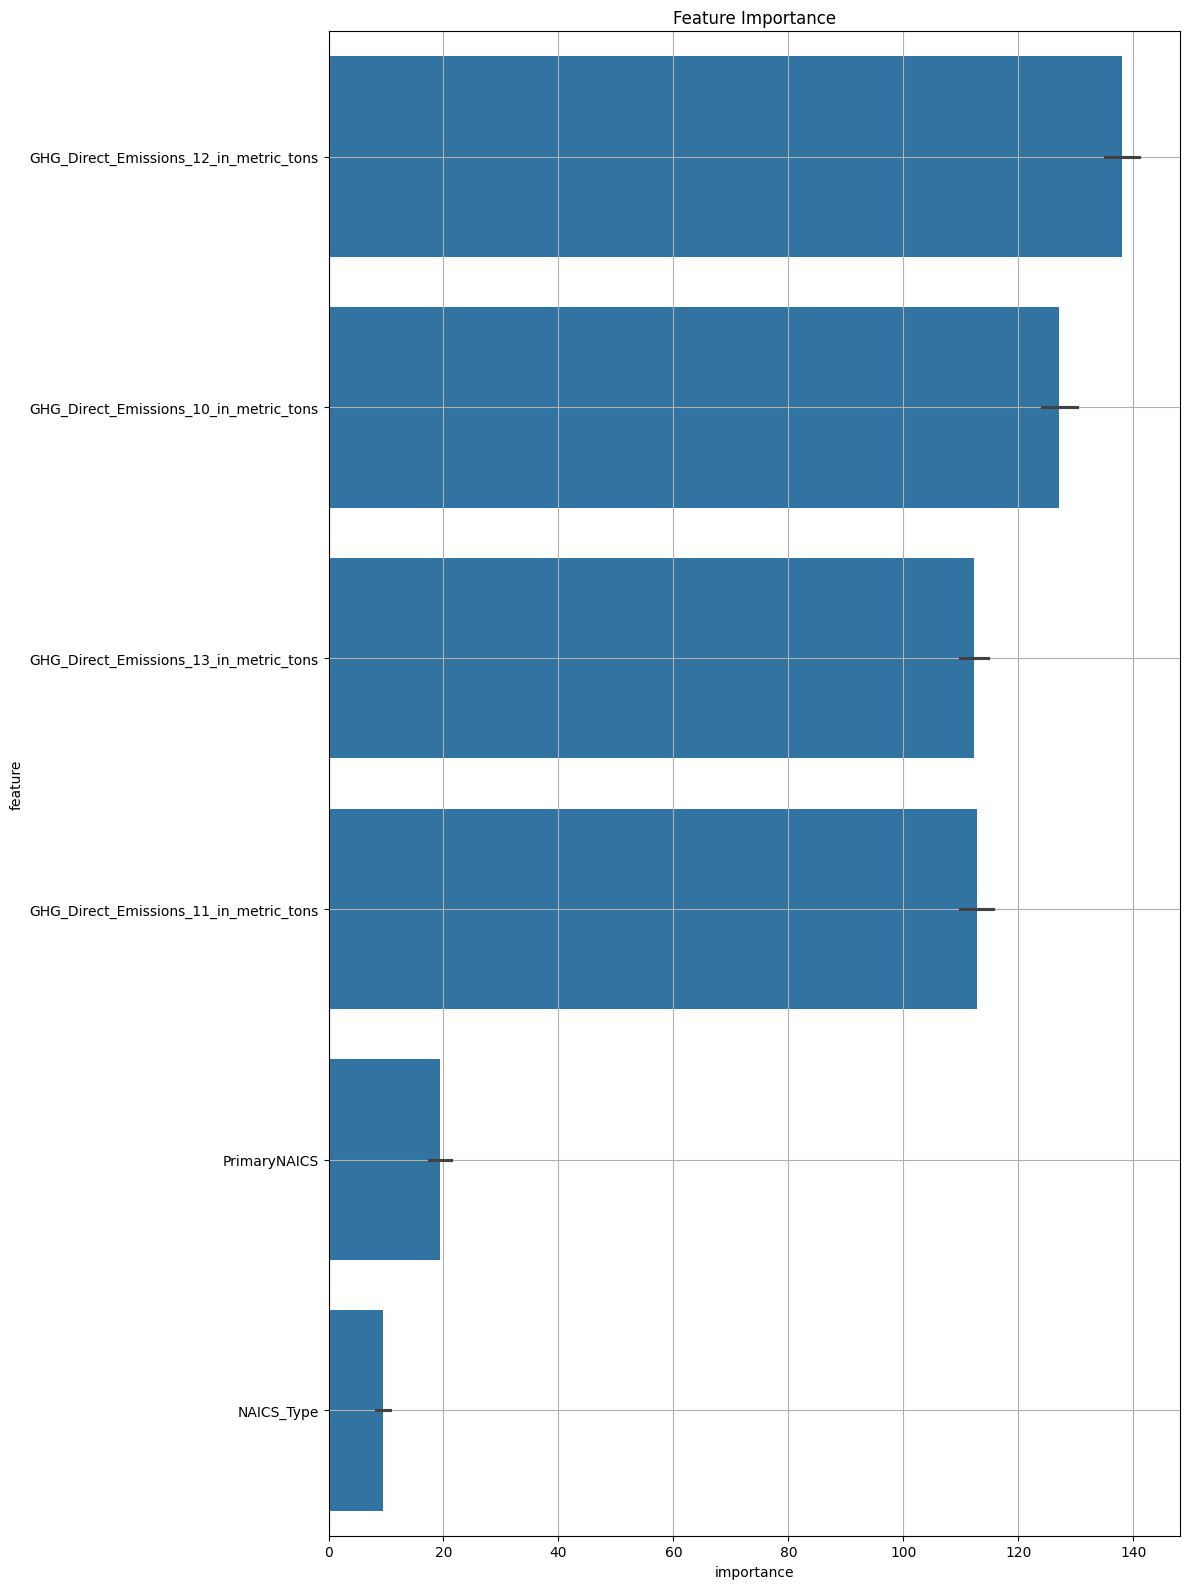

In [719]:
from sklearn.metrics import mean_squared_log_error
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold
import lightgbm as lgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

N_SPLITS = 15
SEED_SKF = 42
np.random.seed(42)

kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED_SKF)

def root_mean_squared_log_error(y_true, y_pred):
    return mean_squared_log_error(y_true, y_pred, squared=False)

def objective(train, target):

    lgbm_params = {
        'n_estimators': 79,
        'max_depth': 3,
        'learning_rate': 0.06442618615385484,
        'lambda_l1': 0.03956391720099408,
        'lambda_l2': 2.872211708913432,
        'min_data_in_leaf': 31,
        'max_bin': 180,
        "random_state": 42,
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'verbose': -1,
    }

    oof_predictions = np.zeros(len(train))
    train_predictions = np.zeros(len(train))  # Initialize train_predictions
    df_feature_importance = pd.DataFrame()
    fold_rmsle = []

    for fold, (train_index, valid_index) in enumerate(kf.split(train, target)):
        X_train, X_valid = train.iloc[train_index], train.iloc[valid_index]
        y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]

        model = LGBMRegressor(**lgbm_params)
        model.fit(
            X_train,
            np.log1p(y_train),
            eval_set=[(X_valid, y_valid)],
            callbacks=[
                lgb.early_stopping(stopping_rounds=50, verbose=False),
                lgb.log_evaluation(0)],
        )
        valid_preds = np.expm1(model.predict(X_valid))
        train_preds = np.expm1(model.predict(X_train))

        rmsle_valid = mean_squared_log_error(y_valid, valid_preds, squared=False)
        rmsle_train = mean_squared_log_error(y_train, train_preds, squared=False)

        oof_predictions[valid_index] = valid_preds
        train_predictions[train_index] = train_preds

        print(f"Fold {fold} - Train RMSLE: {rmsle_train:.5f}, Valid RMSLE: {rmsle_valid:.5f}")

        # feature importance
        df_fold_importance = pd.DataFrame()
        df_fold_importance["feature"] = X_train.columns
        df_fold_importance["importance"] = model.feature_importances_
        df_fold_importance["fold"] = fold
        df_feature_importance = pd.concat([df_feature_importance, df_fold_importance], axis=0)

    RMSLE = root_mean_squared_log_error(target, oof_predictions)
    tr_RMSLE = root_mean_squared_log_error(target, train_predictions)
    print(f"[CV] tr: {tr_RMSLE:.5f}, va: {RMSLE:.5f}")
    print("-" * 50)

    # Feature importance visualization
    plt.figure(figsize=(12, 16))
    sns.barplot(x="importance", y="feature", data=df_feature_importance.sort_values(by="importance", ascending=False))
    plt.title("Feature Importance")
    plt.grid()
    plt.tight_layout()
    plt.show()

    return

# Assuming train and target dataframes are already defined
objective(train, target)


# Optuna

In [442]:
# pip install optuna

In [725]:
import optuna
from sklearn.metrics import root_mean_squared_log_error
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
import numpy as np
import gc

N_SPLITS = 15
SEED_SKF = 42
np.random.seed(42)

kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED_SKF)

def objective(trial, train, target, num_folds=5):
    # Optunaで探索するパラメータ
    xgb_params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 5),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.01),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 0.01, 10.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1.0, 100.0),
        "random_state": 42,
        'enable_categorical': True,
    }

    oof_predictions = np.zeros(len(train))
    fold_rmsle = []

    for fold, (train_index, valid_index) in enumerate(kf.split(train, target)):
        X_train, X_valid = train.iloc[train_index], train.iloc[valid_index]
        y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]

        model = XGBRegressor(**xgb_params)
        _ = model.fit(X_train, np.log1p(y_train))

        valid_preds = np.expm1(model.predict(X_valid))
        train_preds = np.expm1(model.predict(X_train))

        rmsle_valid = root_mean_squared_log_error(y_valid, valid_preds)
        rmsle_train = root_mean_squared_log_error(y_train, train_preds)

        oof_predictions[valid_index] = valid_preds
        train_predictions[train_index] = train_preds

        print(f"Fold {fold} - Train RMSLE: {rmsle_train:.5f}, Valid RMSLE: {rmsle_valid:.5f}")



    RMSLE = root_mean_squared_log_error(target, oof_predictions)
    tr_RMSLE = root_mean_squared_log_error(target, train_predictions)
    print(f"[CV] tr:{tr_RMSLE:.5f} va:{RMSLE:.5f}")
    print("-" * 50)

    return

# Optunaでのハイパーパラメータ最適化
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, train, target), n_trials=50)

# 最良のパラメータをリストに格納
params_list = [trial.params for trial in study.trials]

# 選択した範囲のRMSLEスコアを格納するリスト
valid_params_with_rmsle = []


[I 2024-11-29 08:13:20,614] A new study created in memory with name: no-name-2bd1df4d-563b-45f1-addd-63777406d734


Fold 0 - Train RMSLE: 0.87956, Valid RMSLE: 0.81270
Fold 1 - Train RMSLE: 0.87298, Valid RMSLE: 0.92081
Fold 2 - Train RMSLE: 0.87596, Valid RMSLE: 0.90244
Fold 3 - Train RMSLE: 0.88009, Valid RMSLE: 0.82308
Fold 4 - Train RMSLE: 0.87453, Valid RMSLE: 0.89921
Fold 5 - Train RMSLE: 0.87473, Valid RMSLE: 0.90259
Fold 6 - Train RMSLE: 0.87802, Valid RMSLE: 0.83753
Fold 7 - Train RMSLE: 0.87483, Valid RMSLE: 0.92039
Fold 8 - Train RMSLE: 0.86998, Valid RMSLE: 0.97606
Fold 9 - Train RMSLE: 0.87213, Valid RMSLE: 0.95164
Fold 10 - Train RMSLE: 0.87605, Valid RMSLE: 0.87322
Fold 11 - Train RMSLE: 0.87641, Valid RMSLE: 0.86052
Fold 12 - Train RMSLE: 0.87790, Valid RMSLE: 0.84820
Fold 13 - Train RMSLE: 0.87423, Valid RMSLE: 0.89421


[W 2024-11-29 08:13:38,572] Trial 0 failed with parameters: {'n_estimators': 877, 'max_depth': 3, 'learning_rate': 0.0011293838871067352, 'subsample': 0.9307273684780135, 'colsample_bytree': 0.9859751989017462, 'reg_alpha': 5.923543947589251, 'reg_lambda': 3.979958674371707} because of the following error: The value None could not be cast to float..
[W 2024-11-29 08:13:38,576] Trial 0 failed with value None.


Fold 14 - Train RMSLE: 0.87583, Valid RMSLE: 0.87481
[CV] tr:0.87507 va:0.88759
--------------------------------------------------
Fold 0 - Train RMSLE: 0.73267, Valid RMSLE: 0.68335
Fold 1 - Train RMSLE: 0.72564, Valid RMSLE: 0.78382
Fold 2 - Train RMSLE: 0.72766, Valid RMSLE: 0.75113
Fold 3 - Train RMSLE: 0.73237, Valid RMSLE: 0.68843
Fold 4 - Train RMSLE: 0.72649, Valid RMSLE: 0.76863
Fold 5 - Train RMSLE: 0.72679, Valid RMSLE: 0.77298
Fold 6 - Train RMSLE: 0.72928, Valid RMSLE: 0.73127
Fold 7 - Train RMSLE: 0.72657, Valid RMSLE: 0.77256
Fold 8 - Train RMSLE: 0.72260, Valid RMSLE: 0.83037
Fold 9 - Train RMSLE: 0.72413, Valid RMSLE: 0.80491
Fold 10 - Train RMSLE: 0.72725, Valid RMSLE: 0.76364
Fold 11 - Train RMSLE: 0.72732, Valid RMSLE: 0.75021
Fold 12 - Train RMSLE: 0.72947, Valid RMSLE: 0.72996
Fold 13 - Train RMSLE: 0.72591, Valid RMSLE: 0.78461


[W 2024-11-29 08:13:56,021] Trial 1 failed with parameters: {'n_estimators': 805, 'max_depth': 4, 'learning_rate': 0.005602654303705909, 'subsample': 0.711635554194066, 'colsample_bytree': 0.8247227100485326, 'reg_alpha': 4.816136723049931, 'reg_lambda': 24.080757825750396} because of the following error: The value None could not be cast to float..
[W 2024-11-29 08:13:56,025] Trial 1 failed with value None.


Fold 14 - Train RMSLE: 0.72645, Valid RMSLE: 0.76840
[CV] tr:0.72737 va:0.75987
--------------------------------------------------
Fold 0 - Train RMSLE: 1.08134, Valid RMSLE: 1.04211
Fold 1 - Train RMSLE: 1.07636, Valid RMSLE: 1.12978
Fold 2 - Train RMSLE: 1.07890, Valid RMSLE: 1.09701
Fold 3 - Train RMSLE: 1.08296, Valid RMSLE: 1.02995
Fold 4 - Train RMSLE: 1.07774, Valid RMSLE: 1.10256
Fold 5 - Train RMSLE: 1.07885, Valid RMSLE: 1.08492
Fold 6 - Train RMSLE: 1.08274, Valid RMSLE: 1.02107
Fold 7 - Train RMSLE: 1.07718, Valid RMSLE: 1.11767
Fold 8 - Train RMSLE: 1.07175, Valid RMSLE: 1.18823
Fold 9 - Train RMSLE: 1.07365, Valid RMSLE: 1.16117
Fold 10 - Train RMSLE: 1.08039, Valid RMSLE: 1.06069
Fold 11 - Train RMSLE: 1.08143, Valid RMSLE: 1.04699
Fold 12 - Train RMSLE: 1.08054, Valid RMSLE: 1.05924
Fold 13 - Train RMSLE: 1.07934, Valid RMSLE: 1.06882


[W 2024-11-29 08:14:00,551] Trial 2 failed with parameters: {'n_estimators': 194, 'max_depth': 5, 'learning_rate': 0.001905503699924936, 'subsample': 0.5925899717694569, 'colsample_bytree': 0.5058553415985043, 'reg_alpha': 0.01304180068122529, 'reg_lambda': 2.1900266123463568} because of the following error: The value None could not be cast to float..
[W 2024-11-29 08:14:00,558] Trial 2 failed with value None.


Fold 14 - Train RMSLE: 1.07947, Valid RMSLE: 1.07054
[CV] tr:1.07846 va:1.08636
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72874, Valid RMSLE: 0.67733
Fold 1 - Train RMSLE: 0.72179, Valid RMSLE: 0.78523
Fold 2 - Train RMSLE: 0.72347, Valid RMSLE: 0.76231
Fold 3 - Train RMSLE: 0.72805, Valid RMSLE: 0.69049
Fold 4 - Train RMSLE: 0.72231, Valid RMSLE: 0.77164
Fold 5 - Train RMSLE: 0.72283, Valid RMSLE: 0.77876
Fold 6 - Train RMSLE: 0.72483, Valid RMSLE: 0.73389
Fold 7 - Train RMSLE: 0.72191, Valid RMSLE: 0.77679
Fold 8 - Train RMSLE: 0.71808, Valid RMSLE: 0.83449
Fold 9 - Train RMSLE: 0.72042, Valid RMSLE: 0.80457
Fold 10 - Train RMSLE: 0.72311, Valid RMSLE: 0.76114
Fold 11 - Train RMSLE: 0.72382, Valid RMSLE: 0.74799
Fold 12 - Train RMSLE: 0.72577, Valid RMSLE: 0.72805
Fold 13 - Train RMSLE: 0.72201, Valid RMSLE: 0.78427


[W 2024-11-29 08:14:15,346] Trial 3 failed with parameters: {'n_estimators': 558, 'max_depth': 4, 'learning_rate': 0.005047270302366086, 'subsample': 0.6228575583321034, 'colsample_bytree': 0.9839245273524038, 'reg_alpha': 0.46695345236083935, 'reg_lambda': 2.155394486036846} because of the following error: The value None could not be cast to float..
[W 2024-11-29 08:14:15,348] Trial 3 failed with value None.


Fold 14 - Train RMSLE: 0.72260, Valid RMSLE: 0.76627
[CV] tr:0.72352 va:0.76120
--------------------------------------------------
Fold 0 - Train RMSLE: 0.97773, Valid RMSLE: 0.92917
Fold 1 - Train RMSLE: 0.97260, Valid RMSLE: 1.02574
Fold 2 - Train RMSLE: 0.97485, Valid RMSLE: 1.00084
Fold 3 - Train RMSLE: 0.97900, Valid RMSLE: 0.92875
Fold 4 - Train RMSLE: 0.97356, Valid RMSLE: 1.00119
Fold 5 - Train RMSLE: 0.97467, Valid RMSLE: 0.98799
Fold 6 - Train RMSLE: 0.97810, Valid RMSLE: 0.92675
Fold 7 - Train RMSLE: 0.97342, Valid RMSLE: 1.01785
Fold 8 - Train RMSLE: 0.96842, Valid RMSLE: 1.08324
Fold 9 - Train RMSLE: 0.97020, Valid RMSLE: 1.05548
Fold 10 - Train RMSLE: 0.97554, Valid RMSLE: 0.96740
Fold 11 - Train RMSLE: 0.97682, Valid RMSLE: 0.95093
Fold 12 - Train RMSLE: 0.97634, Valid RMSLE: 0.95764
Fold 13 - Train RMSLE: 0.97449, Valid RMSLE: 0.97646


[W 2024-11-29 08:14:27,740] Trial 4 failed with parameters: {'n_estimators': 396, 'max_depth': 5, 'learning_rate': 0.0015497256324573363, 'subsample': 0.6056522039789396, 'colsample_bytree': 0.5502724223959784, 'reg_alpha': 0.06505500106134826, 'reg_lambda': 3.6639367341834084} because of the following error: The value None could not be cast to float..
[W 2024-11-29 08:14:27,744] Trial 4 failed with value None.


Fold 14 - Train RMSLE: 0.97516, Valid RMSLE: 0.97288
[CV] tr:0.97433 va:0.98649
--------------------------------------------------
Fold 0 - Train RMSLE: 0.78591, Valid RMSLE: 0.72045
Fold 1 - Train RMSLE: 0.77875, Valid RMSLE: 0.82954
Fold 2 - Train RMSLE: 0.78094, Valid RMSLE: 0.80282
Fold 3 - Train RMSLE: 0.78514, Valid RMSLE: 0.72715
Fold 4 - Train RMSLE: 0.77955, Valid RMSLE: 0.80819
Fold 5 - Train RMSLE: 0.77917, Valid RMSLE: 0.81800
Fold 6 - Train RMSLE: 0.78246, Valid RMSLE: 0.76028
Fold 7 - Train RMSLE: 0.77989, Valid RMSLE: 0.82001
Fold 8 - Train RMSLE: 0.77548, Valid RMSLE: 0.87892
Fold 9 - Train RMSLE: 0.77800, Valid RMSLE: 0.85162
Fold 10 - Train RMSLE: 0.78055, Valid RMSLE: 0.79062
Fold 11 - Train RMSLE: 0.78082, Valid RMSLE: 0.78173
Fold 12 - Train RMSLE: 0.78247, Valid RMSLE: 0.76383
Fold 13 - Train RMSLE: 0.77912, Valid RMSLE: 0.81209


[W 2024-11-29 08:14:43,974] Trial 5 failed with parameters: {'n_estimators': 958, 'max_depth': 3, 'learning_rate': 0.0022076958285515503, 'subsample': 0.8501710917078151, 'colsample_bytree': 0.9249045056944865, 'reg_alpha': 3.3389499320406015, 'reg_lambda': 85.17271642181835} because of the following error: The value None could not be cast to float..
[W 2024-11-29 08:14:43,976] Trial 5 failed with value None.


Fold 14 - Train RMSLE: 0.78091, Valid RMSLE: 0.79299
[CV] tr:0.78075 va:0.79826
--------------------------------------------------
Fold 0 - Train RMSLE: 1.07656, Valid RMSLE: 1.03619
Fold 1 - Train RMSLE: 1.07110, Valid RMSLE: 1.11996
Fold 2 - Train RMSLE: 1.07384, Valid RMSLE: 1.08977
Fold 3 - Train RMSLE: 1.07794, Valid RMSLE: 1.01942
Fold 4 - Train RMSLE: 1.07248, Valid RMSLE: 1.09707
Fold 5 - Train RMSLE: 1.07358, Valid RMSLE: 1.07762
Fold 6 - Train RMSLE: 1.07746, Valid RMSLE: 1.01475
Fold 7 - Train RMSLE: 1.07259, Valid RMSLE: 1.10857
Fold 8 - Train RMSLE: 1.06709, Valid RMSLE: 1.18457
Fold 9 - Train RMSLE: 1.06875, Valid RMSLE: 1.15595
Fold 10 - Train RMSLE: 1.07515, Valid RMSLE: 1.05185
Fold 11 - Train RMSLE: 1.07611, Valid RMSLE: 1.04147
Fold 12 - Train RMSLE: 1.07539, Valid RMSLE: 1.05180
Fold 13 - Train RMSLE: 1.07413, Valid RMSLE: 1.06133


[W 2024-11-29 08:14:48,198] Trial 6 failed with parameters: {'n_estimators': 177, 'max_depth': 5, 'learning_rate': 0.0023648459019262455, 'subsample': 0.865428862823627, 'colsample_bytree': 0.6570886342730844, 'reg_alpha': 6.023999353712471, 'reg_lambda': 25.568850743324248} because of the following error: The value None could not be cast to float..
[W 2024-11-29 08:14:48,201] Trial 6 failed with value None.


Fold 14 - Train RMSLE: 1.07464, Valid RMSLE: 1.06533
[CV] tr:1.07366 va:1.07939
--------------------------------------------------
Fold 0 - Train RMSLE: 0.96021, Valid RMSLE: 0.90215
Fold 1 - Train RMSLE: 0.95422, Valid RMSLE: 1.00169
Fold 2 - Train RMSLE: 0.95709, Valid RMSLE: 0.98032
Fold 3 - Train RMSLE: 0.96142, Valid RMSLE: 0.90423
Fold 4 - Train RMSLE: 0.95577, Valid RMSLE: 0.97965
Fold 5 - Train RMSLE: 0.95638, Valid RMSLE: 0.97778
Fold 6 - Train RMSLE: 0.96014, Valid RMSLE: 0.90933
Fold 7 - Train RMSLE: 0.95614, Valid RMSLE: 0.99930
Fold 8 - Train RMSLE: 0.95122, Valid RMSLE: 1.05989
Fold 9 - Train RMSLE: 0.95293, Valid RMSLE: 1.03809
Fold 10 - Train RMSLE: 0.95796, Valid RMSLE: 0.94505
Fold 11 - Train RMSLE: 0.95848, Valid RMSLE: 0.93446
Fold 12 - Train RMSLE: 0.95928, Valid RMSLE: 0.92785
Fold 13 - Train RMSLE: 0.95641, Valid RMSLE: 0.96366


[W 2024-11-29 08:14:57,563] Trial 7 failed with parameters: {'n_estimators': 447, 'max_depth': 3, 'learning_rate': 0.0015291320474941756, 'subsample': 0.933015176061052, 'colsample_bytree': 0.8681295473089574, 'reg_alpha': 9.4973960001576, 'reg_lambda': 2.455062702024864} because of the following error: The value None could not be cast to float..
[W 2024-11-29 08:14:57,565] Trial 7 failed with value None.


Fold 14 - Train RMSLE: 0.95748, Valid RMSLE: 0.95177
[CV] tr:0.95661 va:0.96608
--------------------------------------------------
Fold 0 - Train RMSLE: 0.74849, Valid RMSLE: 0.69670
Fold 1 - Train RMSLE: 0.74205, Valid RMSLE: 0.80190
Fold 2 - Train RMSLE: 0.74427, Valid RMSLE: 0.77488
Fold 3 - Train RMSLE: 0.74814, Valid RMSLE: 0.70698
Fold 4 - Train RMSLE: 0.74292, Valid RMSLE: 0.78628
Fold 5 - Train RMSLE: 0.74314, Valid RMSLE: 0.78942
Fold 6 - Train RMSLE: 0.74535, Valid RMSLE: 0.73964
Fold 7 - Train RMSLE: 0.74269, Valid RMSLE: 0.79511
Fold 8 - Train RMSLE: 0.73853, Valid RMSLE: 0.85493
Fold 9 - Train RMSLE: 0.74046, Valid RMSLE: 0.82311
Fold 10 - Train RMSLE: 0.74348, Valid RMSLE: 0.77425
Fold 11 - Train RMSLE: 0.74380, Valid RMSLE: 0.76122
Fold 12 - Train RMSLE: 0.74550, Valid RMSLE: 0.74417
Fold 13 - Train RMSLE: 0.74190, Valid RMSLE: 0.79312


[W 2024-11-29 08:15:11,270] Trial 8 failed with parameters: {'n_estimators': 397, 'max_depth': 5, 'learning_rate': 0.005864596219203587, 'subsample': 0.6562614282824033, 'colsample_bytree': 0.6918418750676922, 'reg_alpha': 1.1698287439217963, 'reg_lambda': 23.261020686678872} because of the following error: The value None could not be cast to float..
[W 2024-11-29 08:15:11,274] Trial 8 failed with value None.


Fold 14 - Train RMSLE: 0.74300, Valid RMSLE: 0.77864
[CV] tr:0.74344 va:0.77568
--------------------------------------------------
Fold 0 - Train RMSLE: 0.70519, Valid RMSLE: 0.67827
Fold 1 - Train RMSLE: 0.69882, Valid RMSLE: 0.77466
Fold 2 - Train RMSLE: 0.70013, Valid RMSLE: 0.75143
Fold 3 - Train RMSLE: 0.70366, Valid RMSLE: 0.68882
Fold 4 - Train RMSLE: 0.69841, Valid RMSLE: 0.76827
Fold 5 - Train RMSLE: 0.69920, Valid RMSLE: 0.77115
Fold 6 - Train RMSLE: 0.70098, Valid RMSLE: 0.73529
Fold 7 - Train RMSLE: 0.69839, Valid RMSLE: 0.76877
Fold 8 - Train RMSLE: 0.69479, Valid RMSLE: 0.82755
Fold 9 - Train RMSLE: 0.69726, Valid RMSLE: 0.80096
Fold 10 - Train RMSLE: 0.69950, Valid RMSLE: 0.75944
Fold 11 - Train RMSLE: 0.69982, Valid RMSLE: 0.74824
Fold 12 - Train RMSLE: 0.70150, Valid RMSLE: 0.72580
Fold 13 - Train RMSLE: 0.69844, Valid RMSLE: 0.78751


[W 2024-11-29 08:15:30,398] Trial 9 failed with parameters: {'n_estimators': 895, 'max_depth': 4, 'learning_rate': 0.006805684840152158, 'subsample': 0.7976250036538775, 'colsample_bytree': 0.7375302803982888, 'reg_alpha': 0.11575420146686782, 'reg_lambda': 4.972835153294613} because of the following error: The value None could not be cast to float..
[W 2024-11-29 08:15:30,405] Trial 9 failed with value None.


Fold 14 - Train RMSLE: 0.69815, Valid RMSLE: 0.77415
[CV] tr:0.69980 va:0.75827
--------------------------------------------------
Fold 0 - Train RMSLE: 1.16269, Valid RMSLE: 1.12699
Fold 1 - Train RMSLE: 1.15737, Valid RMSLE: 1.20708
Fold 2 - Train RMSLE: 1.16071, Valid RMSLE: 1.17168
Fold 3 - Train RMSLE: 1.16456, Valid RMSLE: 1.10493
Fold 4 - Train RMSLE: 1.15918, Valid RMSLE: 1.18090
Fold 5 - Train RMSLE: 1.16065, Valid RMSLE: 1.16082
Fold 6 - Train RMSLE: 1.16483, Valid RMSLE: 1.09466
Fold 7 - Train RMSLE: 1.15883, Valid RMSLE: 1.19491
Fold 8 - Train RMSLE: 1.15305, Valid RMSLE: 1.26910
Fold 9 - Train RMSLE: 1.15493, Valid RMSLE: 1.24387
Fold 10 - Train RMSLE: 1.16235, Valid RMSLE: 1.13317
Fold 11 - Train RMSLE: 1.16317, Valid RMSLE: 1.12172
Fold 12 - Train RMSLE: 1.16240, Valid RMSLE: 1.13417


[W 2024-11-29 08:15:32,313] Trial 10 failed with parameters: {'n_estimators': 130, 'max_depth': 3, 'learning_rate': 0.0017891013388130219, 'subsample': 0.8974996804593414, 'colsample_bytree': 0.5651518451065973, 'reg_alpha': 0.024450023068216475, 'reg_lambda': 1.701421189904905} because of the following error: The value None could not be cast to float..
[W 2024-11-29 08:15:32,318] Trial 10 failed with value None.


Fold 13 - Train RMSLE: 1.16142, Valid RMSLE: 1.14228
Fold 14 - Train RMSLE: 1.16149, Valid RMSLE: 1.14579
[CV] tr:1.16031 va:1.16313
--------------------------------------------------
Fold 0 - Train RMSLE: 1.18765, Valid RMSLE: 1.15373
Fold 1 - Train RMSLE: 1.18237, Valid RMSLE: 1.23617
Fold 2 - Train RMSLE: 1.18565, Valid RMSLE: 1.19698
Fold 3 - Train RMSLE: 1.18958, Valid RMSLE: 1.13395
Fold 4 - Train RMSLE: 1.18430, Valid RMSLE: 1.20811
Fold 5 - Train RMSLE: 1.18566, Valid RMSLE: 1.18895
Fold 6 - Train RMSLE: 1.19008, Valid RMSLE: 1.12095
Fold 7 - Train RMSLE: 1.18374, Valid RMSLE: 1.22045
Fold 8 - Train RMSLE: 1.17779, Valid RMSLE: 1.29739
Fold 9 - Train RMSLE: 1.17960, Valid RMSLE: 1.27087
Fold 10 - Train RMSLE: 1.18754, Valid RMSLE: 1.15822
Fold 11 - Train RMSLE: 1.18810, Valid RMSLE: 1.14878
Fold 12 - Train RMSLE: 1.18743, Valid RMSLE: 1.16153
Fold 13 - Train RMSLE: 1.18681, Valid RMSLE: 1.16629


[W 2024-11-29 08:15:40,971] Trial 11 failed with parameters: {'n_estimators': 148, 'max_depth': 5, 'learning_rate': 0.0011185080138122155, 'subsample': 0.6594230835333232, 'colsample_bytree': 0.9701267213814151, 'reg_alpha': 0.055439762436866095, 'reg_lambda': 1.2434409620249538} because of the following error: The value None could not be cast to float..
[W 2024-11-29 08:15:40,975] Trial 11 failed with value None.


Fold 14 - Train RMSLE: 1.18648, Valid RMSLE: 1.17295
[CV] tr:1.18532 va:1.19000
--------------------------------------------------
Fold 0 - Train RMSLE: 1.09083, Valid RMSLE: 1.04777
Fold 1 - Train RMSLE: 1.08524, Valid RMSLE: 1.13289
Fold 2 - Train RMSLE: 1.08818, Valid RMSLE: 1.10316
Fold 3 - Train RMSLE: 1.09243, Valid RMSLE: 1.03195
Fold 4 - Train RMSLE: 1.08701, Valid RMSLE: 1.10954
Fold 5 - Train RMSLE: 1.08803, Valid RMSLE: 1.09448
Fold 6 - Train RMSLE: 1.09234, Valid RMSLE: 1.02710
Fold 7 - Train RMSLE: 1.08695, Valid RMSLE: 1.12523
Fold 8 - Train RMSLE: 1.08155, Valid RMSLE: 1.19611
Fold 9 - Train RMSLE: 1.08280, Valid RMSLE: 1.17055
Fold 10 - Train RMSLE: 1.08955, Valid RMSLE: 1.06520
Fold 11 - Train RMSLE: 1.09049, Valid RMSLE: 1.05432
Fold 12 - Train RMSLE: 1.09028, Valid RMSLE: 1.06026


[W 2024-11-29 08:15:42,868] Trial 12 failed with parameters: {'n_estimators': 114, 'max_depth': 3, 'learning_rate': 0.003224194809398973, 'subsample': 0.7954789965181409, 'colsample_bytree': 0.8292313488133194, 'reg_alpha': 2.898581691043186, 'reg_lambda': 10.789551018788416} because of the following error: The value None could not be cast to float..
[W 2024-11-29 08:15:42,870] Trial 12 failed with value None.


Fold 13 - Train RMSLE: 1.08848, Valid RMSLE: 1.07682
Fold 14 - Train RMSLE: 1.08903, Valid RMSLE: 1.07821
[CV] tr:1.08805 va:1.09259
--------------------------------------------------
Fold 0 - Train RMSLE: 0.73985, Valid RMSLE: 0.69436
Fold 1 - Train RMSLE: 0.73306, Valid RMSLE: 0.80563
Fold 2 - Train RMSLE: 0.73528, Valid RMSLE: 0.78611
Fold 3 - Train RMSLE: 0.73899, Valid RMSLE: 0.71484
Fold 4 - Train RMSLE: 0.73345, Valid RMSLE: 0.78889
Fold 5 - Train RMSLE: 0.73468, Valid RMSLE: 0.79384
Fold 6 - Train RMSLE: 0.73710, Valid RMSLE: 0.74601
Fold 7 - Train RMSLE: 0.73351, Valid RMSLE: 0.80030
Fold 8 - Train RMSLE: 0.72990, Valid RMSLE: 0.85916
Fold 9 - Train RMSLE: 0.73180, Valid RMSLE: 0.82717
Fold 10 - Train RMSLE: 0.73483, Valid RMSLE: 0.77672
Fold 11 - Train RMSLE: 0.73552, Valid RMSLE: 0.76149
Fold 12 - Train RMSLE: 0.73704, Valid RMSLE: 0.74731
Fold 13 - Train RMSLE: 0.73373, Valid RMSLE: 0.79624


[W 2024-11-29 08:15:57,753] Trial 13 failed with parameters: {'n_estimators': 435, 'max_depth': 5, 'learning_rate': 0.00440785658069306, 'subsample': 0.78061876649826, 'colsample_bytree': 0.8020650513415772, 'reg_alpha': 0.3350381980210708, 'reg_lambda': 1.751912491085079} because of the following error: The value None could not be cast to float..
[W 2024-11-29 08:15:57,756] Trial 13 failed with value None.


Fold 14 - Train RMSLE: 0.73334, Valid RMSLE: 0.78388
[CV] tr:0.73416 va:0.77981
--------------------------------------------------
Fold 0 - Train RMSLE: 0.76830, Valid RMSLE: 0.71167
Fold 1 - Train RMSLE: 0.76198, Valid RMSLE: 0.80854
Fold 2 - Train RMSLE: 0.76402, Valid RMSLE: 0.77960
Fold 3 - Train RMSLE: 0.76804, Valid RMSLE: 0.70925
Fold 4 - Train RMSLE: 0.76261, Valid RMSLE: 0.79699
Fold 5 - Train RMSLE: 0.76316, Valid RMSLE: 0.79283
Fold 6 - Train RMSLE: 0.76566, Valid RMSLE: 0.74220
Fold 7 - Train RMSLE: 0.76270, Valid RMSLE: 0.79778
Fold 8 - Train RMSLE: 0.75844, Valid RMSLE: 0.86016
Fold 9 - Train RMSLE: 0.76026, Valid RMSLE: 0.82977
Fold 10 - Train RMSLE: 0.76295, Valid RMSLE: 0.78105
Fold 11 - Train RMSLE: 0.76419, Valid RMSLE: 0.76067
Fold 12 - Train RMSLE: 0.76514, Valid RMSLE: 0.75436
Fold 13 - Train RMSLE: 0.76183, Valid RMSLE: 0.79766


[W 2024-11-29 08:16:04,583] Trial 14 failed with parameters: {'n_estimators': 297, 'max_depth': 4, 'learning_rate': 0.008952312577198272, 'subsample': 0.5559787327980603, 'colsample_bytree': 0.6255223849733151, 'reg_alpha': 0.47385531522806984, 'reg_lambda': 64.58831978195468} because of the following error: The value None could not be cast to float..
[W 2024-11-29 08:16:04,587] Trial 14 failed with value None.


Fold 14 - Train RMSLE: 0.76339, Valid RMSLE: 0.78389
[CV] tr:0.76376 va:0.78139
--------------------------------------------------
Fold 0 - Train RMSLE: 1.11056, Valid RMSLE: 1.06941
Fold 1 - Train RMSLE: 1.10521, Valid RMSLE: 1.15328
Fold 2 - Train RMSLE: 1.10835, Valid RMSLE: 1.12310
Fold 3 - Train RMSLE: 1.11233, Valid RMSLE: 1.05337
Fold 4 - Train RMSLE: 1.10683, Valid RMSLE: 1.12874
Fold 5 - Train RMSLE: 1.10828, Valid RMSLE: 1.11091
Fold 6 - Train RMSLE: 1.11238, Valid RMSLE: 1.04547
Fold 7 - Train RMSLE: 1.10660, Valid RMSLE: 1.14410
Fold 8 - Train RMSLE: 1.10127, Valid RMSLE: 1.21605
Fold 9 - Train RMSLE: 1.10294, Valid RMSLE: 1.18973
Fold 10 - Train RMSLE: 1.10981, Valid RMSLE: 1.08399
Fold 11 - Train RMSLE: 1.11063, Valid RMSLE: 1.07144
Fold 12 - Train RMSLE: 1.11004, Valid RMSLE: 1.08261


[W 2024-11-29 08:16:09,419] Trial 15 failed with parameters: {'n_estimators': 244, 'max_depth': 3, 'learning_rate': 0.0013684618250740389, 'subsample': 0.9219881282619742, 'colsample_bytree': 0.6235682147323951, 'reg_alpha': 0.266594448365066, 'reg_lambda': 5.998671079287092} because of the following error: The value None could not be cast to float..


Fold 13 - Train RMSLE: 1.10866, Valid RMSLE: 1.09505
Fold 14 - Train RMSLE: 1.10904, Valid RMSLE: 1.09445
[CV] tr:1.10787 va:1.11178
--------------------------------------------------


[W 2024-11-29 08:16:09,425] Trial 15 failed with value None.


Fold 0 - Train RMSLE: 0.92258, Valid RMSLE: 0.86594
Fold 1 - Train RMSLE: 0.91679, Valid RMSLE: 0.96367
Fold 2 - Train RMSLE: 0.91903, Valid RMSLE: 0.94439
Fold 3 - Train RMSLE: 0.92356, Valid RMSLE: 0.86586
Fold 4 - Train RMSLE: 0.91782, Valid RMSLE: 0.94450
Fold 5 - Train RMSLE: 0.91879, Valid RMSLE: 0.93097
Fold 6 - Train RMSLE: 0.92221, Valid RMSLE: 0.87230
Fold 7 - Train RMSLE: 0.91799, Valid RMSLE: 0.95825
Fold 8 - Train RMSLE: 0.91292, Valid RMSLE: 1.02258
Fold 9 - Train RMSLE: 0.91489, Valid RMSLE: 0.99221
Fold 10 - Train RMSLE: 0.91937, Valid RMSLE: 0.91275
Fold 11 - Train RMSLE: 0.92059, Valid RMSLE: 0.89485
Fold 12 - Train RMSLE: 0.92045, Valid RMSLE: 0.89932
Fold 13 - Train RMSLE: 0.91835, Valid RMSLE: 0.92478


[W 2024-11-29 08:16:13,771] Trial 16 failed with parameters: {'n_estimators': 252, 'max_depth': 4, 'learning_rate': 0.0033223336011827527, 'subsample': 0.5083825301333554, 'colsample_bytree': 0.6403525309179866, 'reg_alpha': 0.7969885316577822, 'reg_lambda': 7.747387854559525} because of the following error: The value None could not be cast to float..
[W 2024-11-29 08:16:13,776] Trial 16 failed with value None.


Fold 14 - Train RMSLE: 0.91948, Valid RMSLE: 0.91651
[CV] tr:0.91873 va:0.92829
--------------------------------------------------
Fold 0 - Train RMSLE: 0.87751, Valid RMSLE: 0.80898
Fold 1 - Train RMSLE: 0.87137, Valid RMSLE: 0.91905
Fold 2 - Train RMSLE: 0.87352, Valid RMSLE: 0.90045
Fold 3 - Train RMSLE: 0.87814, Valid RMSLE: 0.82021
Fold 4 - Train RMSLE: 0.87255, Valid RMSLE: 0.89666
Fold 5 - Train RMSLE: 0.87273, Valid RMSLE: 0.89762
Fold 6 - Train RMSLE: 0.87638, Valid RMSLE: 0.83413
Fold 7 - Train RMSLE: 0.87251, Valid RMSLE: 0.91689
Fold 8 - Train RMSLE: 0.86804, Valid RMSLE: 0.97135
Fold 9 - Train RMSLE: 0.87012, Valid RMSLE: 0.94692
Fold 10 - Train RMSLE: 0.87385, Valid RMSLE: 0.87259
Fold 11 - Train RMSLE: 0.87485, Valid RMSLE: 0.85629
Fold 12 - Train RMSLE: 0.87591, Valid RMSLE: 0.84385
Fold 13 - Train RMSLE: 0.87222, Valid RMSLE: 0.88956


[W 2024-11-29 08:16:26,298] Trial 17 failed with parameters: {'n_estimators': 552, 'max_depth': 3, 'learning_rate': 0.001768885509753327, 'subsample': 0.6380307180294698, 'colsample_bytree': 0.9767045604153255, 'reg_alpha': 0.3359158456386508, 'reg_lambda': 2.3001619990517526} because of the following error: The value None could not be cast to float..
[W 2024-11-29 08:16:26,303] Trial 17 failed with value None.


Fold 14 - Train RMSLE: 0.87380, Valid RMSLE: 0.87018
[CV] tr:0.87297 va:0.88408
--------------------------------------------------
Fold 0 - Train RMSLE: 0.70278, Valid RMSLE: 0.67446
Fold 1 - Train RMSLE: 0.69601, Valid RMSLE: 0.78898
Fold 2 - Train RMSLE: 0.69815, Valid RMSLE: 0.76282
Fold 3 - Train RMSLE: 0.70204, Valid RMSLE: 0.69432
Fold 4 - Train RMSLE: 0.69623, Valid RMSLE: 0.77271
Fold 5 - Train RMSLE: 0.69761, Valid RMSLE: 0.78116
Fold 6 - Train RMSLE: 0.69904, Valid RMSLE: 0.73937
Fold 7 - Train RMSLE: 0.69594, Valid RMSLE: 0.78016
Fold 8 - Train RMSLE: 0.69289, Valid RMSLE: 0.83582
Fold 9 - Train RMSLE: 0.69535, Valid RMSLE: 0.80194
Fold 10 - Train RMSLE: 0.69735, Valid RMSLE: 0.75795
Fold 11 - Train RMSLE: 0.69792, Valid RMSLE: 0.75159
Fold 12 - Train RMSLE: 0.69991, Valid RMSLE: 0.72755
Fold 13 - Train RMSLE: 0.69746, Valid RMSLE: 0.78280


[W 2024-11-29 08:16:44,811] Trial 18 failed with parameters: {'n_estimators': 432, 'max_depth': 5, 'learning_rate': 0.006929616489420684, 'subsample': 0.891801528686516, 'colsample_bytree': 0.9642636072999995, 'reg_alpha': 0.15207296872079712, 'reg_lambda': 4.0829683702439965} because of the following error: The value None could not be cast to float..
[W 2024-11-29 08:16:44,814] Trial 18 failed with value None.


Fold 14 - Train RMSLE: 0.69593, Valid RMSLE: 0.77158
[CV] tr:0.69727 va:0.76254
--------------------------------------------------
Fold 0 - Train RMSLE: 0.74249, Valid RMSLE: 0.69172
Fold 1 - Train RMSLE: 0.73554, Valid RMSLE: 0.80590
Fold 2 - Train RMSLE: 0.73764, Valid RMSLE: 0.78389
Fold 3 - Train RMSLE: 0.74186, Valid RMSLE: 0.71532
Fold 4 - Train RMSLE: 0.73580, Valid RMSLE: 0.79182
Fold 5 - Train RMSLE: 0.73704, Valid RMSLE: 0.79287
Fold 6 - Train RMSLE: 0.73923, Valid RMSLE: 0.74631
Fold 7 - Train RMSLE: 0.73603, Valid RMSLE: 0.80296
Fold 8 - Train RMSLE: 0.73199, Valid RMSLE: 0.85601
Fold 9 - Train RMSLE: 0.73446, Valid RMSLE: 0.82247
Fold 10 - Train RMSLE: 0.73734, Valid RMSLE: 0.77276
Fold 11 - Train RMSLE: 0.73762, Valid RMSLE: 0.76595
Fold 12 - Train RMSLE: 0.73933, Valid RMSLE: 0.74683
Fold 13 - Train RMSLE: 0.73657, Valid RMSLE: 0.79547


[W 2024-11-29 08:16:57,951] Trial 19 failed with parameters: {'n_estimators': 319, 'max_depth': 5, 'learning_rate': 0.005944896407084944, 'subsample': 0.5149952085377207, 'colsample_bytree': 0.9441475761763065, 'reg_alpha': 0.05137135793081924, 'reg_lambda': 3.285018870259355} because of the following error: The value None could not be cast to float..
[W 2024-11-29 08:16:57,953] Trial 19 failed with value None.


Fold 14 - Train RMSLE: 0.73657, Valid RMSLE: 0.78097
[CV] tr:0.73710 va:0.77908
--------------------------------------------------
Fold 0 - Train RMSLE: 0.66631, Valid RMSLE: 0.68066
Fold 1 - Train RMSLE: 0.65994, Valid RMSLE: 0.78130
Fold 2 - Train RMSLE: 0.66059, Valid RMSLE: 0.75486
Fold 3 - Train RMSLE: 0.66428, Valid RMSLE: 0.69677
Fold 4 - Train RMSLE: 0.66091, Valid RMSLE: 0.77129
Fold 5 - Train RMSLE: 0.66078, Valid RMSLE: 0.77594
Fold 6 - Train RMSLE: 0.66287, Valid RMSLE: 0.74461
Fold 7 - Train RMSLE: 0.65894, Valid RMSLE: 0.77778
Fold 8 - Train RMSLE: 0.65600, Valid RMSLE: 0.82995
Fold 9 - Train RMSLE: 0.65987, Valid RMSLE: 0.79696
Fold 10 - Train RMSLE: 0.66011, Valid RMSLE: 0.75851
Fold 11 - Train RMSLE: 0.66072, Valid RMSLE: 0.75193
Fold 12 - Train RMSLE: 0.66284, Valid RMSLE: 0.72858
Fold 13 - Train RMSLE: 0.66033, Valid RMSLE: 0.78723


[W 2024-11-29 08:17:23,006] Trial 20 failed with parameters: {'n_estimators': 623, 'max_depth': 5, 'learning_rate': 0.009164811743200638, 'subsample': 0.7145125396748991, 'colsample_bytree': 0.9444248711186431, 'reg_alpha': 0.07577154172978305, 'reg_lambda': 2.5854708599598477} because of the following error: The value None could not be cast to float..
[W 2024-11-29 08:17:23,011] Trial 20 failed with value None.


Fold 14 - Train RMSLE: 0.65813, Valid RMSLE: 0.78391
[CV] tr:0.66028 va:0.76222
--------------------------------------------------
Fold 0 - Train RMSLE: 0.79745, Valid RMSLE: 0.72672
Fold 1 - Train RMSLE: 0.79043, Valid RMSLE: 0.83747
Fold 2 - Train RMSLE: 0.79284, Valid RMSLE: 0.81775
Fold 3 - Train RMSLE: 0.79690, Valid RMSLE: 0.74177
Fold 4 - Train RMSLE: 0.79108, Valid RMSLE: 0.81984
Fold 5 - Train RMSLE: 0.79171, Valid RMSLE: 0.82362
Fold 6 - Train RMSLE: 0.79450, Valid RMSLE: 0.76761
Fold 7 - Train RMSLE: 0.79177, Valid RMSLE: 0.83206
Fold 8 - Train RMSLE: 0.78734, Valid RMSLE: 0.89215
Fold 9 - Train RMSLE: 0.78923, Valid RMSLE: 0.86317
Fold 10 - Train RMSLE: 0.79224, Valid RMSLE: 0.80408
Fold 11 - Train RMSLE: 0.79261, Valid RMSLE: 0.79140
Fold 12 - Train RMSLE: 0.79451, Valid RMSLE: 0.77318
Fold 13 - Train RMSLE: 0.79033, Valid RMSLE: 0.82831


[W 2024-11-29 08:17:29,401] Trial 21 failed with parameters: {'n_estimators': 519, 'max_depth': 3, 'learning_rate': 0.0031955673523167065, 'subsample': 0.9801095058588511, 'colsample_bytree': 0.7771408730344322, 'reg_alpha': 9.42914958902984, 'reg_lambda': 5.39622522201198} because of the following error: The value None could not be cast to float..
[W 2024-11-29 08:17:29,407] Trial 21 failed with value None.


Fold 14 - Train RMSLE: 0.79198, Valid RMSLE: 0.80386
[CV] tr:0.79185 va:0.80927
--------------------------------------------------
Fold 0 - Train RMSLE: 0.74887, Valid RMSLE: 0.68429
Fold 1 - Train RMSLE: 0.74190, Valid RMSLE: 0.78921
Fold 2 - Train RMSLE: 0.74366, Valid RMSLE: 0.76907
Fold 3 - Train RMSLE: 0.74837, Valid RMSLE: 0.69368
Fold 4 - Train RMSLE: 0.74258, Valid RMSLE: 0.77317
Fold 5 - Train RMSLE: 0.74264, Valid RMSLE: 0.78560
Fold 6 - Train RMSLE: 0.74497, Valid RMSLE: 0.73552
Fold 7 - Train RMSLE: 0.74263, Valid RMSLE: 0.78154
Fold 8 - Train RMSLE: 0.73826, Valid RMSLE: 0.84164
Fold 9 - Train RMSLE: 0.74050, Valid RMSLE: 0.81444
Fold 10 - Train RMSLE: 0.74310, Valid RMSLE: 0.76816
Fold 11 - Train RMSLE: 0.74460, Valid RMSLE: 0.74791
Fold 12 - Train RMSLE: 0.74585, Valid RMSLE: 0.72692
Fold 13 - Train RMSLE: 0.74211, Valid RMSLE: 0.79048


[W 2024-11-29 08:17:38,705] Trial 22 failed with parameters: {'n_estimators': 374, 'max_depth': 3, 'learning_rate': 0.007011727926412455, 'subsample': 0.6543234405287385, 'colsample_bytree': 0.9858219238288043, 'reg_alpha': 0.6122633515077269, 'reg_lambda': 1.4332613905933522} because of the following error: The value None could not be cast to float..
[W 2024-11-29 08:17:38,712] Trial 22 failed with value None.


Fold 14 - Train RMSLE: 0.74279, Valid RMSLE: 0.76673
[CV] tr:0.74318 va:0.76560
--------------------------------------------------
Fold 0 - Train RMSLE: 0.71726, Valid RMSLE: 0.68013
Fold 1 - Train RMSLE: 0.71016, Valid RMSLE: 0.77522
Fold 2 - Train RMSLE: 0.71211, Valid RMSLE: 0.75600
Fold 3 - Train RMSLE: 0.71602, Valid RMSLE: 0.68586
Fold 4 - Train RMSLE: 0.71082, Valid RMSLE: 0.76793
Fold 5 - Train RMSLE: 0.71147, Valid RMSLE: 0.77700
Fold 6 - Train RMSLE: 0.71311, Valid RMSLE: 0.73867
Fold 7 - Train RMSLE: 0.71104, Valid RMSLE: 0.76768
Fold 8 - Train RMSLE: 0.70724, Valid RMSLE: 0.82570
Fold 9 - Train RMSLE: 0.70977, Valid RMSLE: 0.80445
Fold 10 - Train RMSLE: 0.71192, Valid RMSLE: 0.76244
Fold 11 - Train RMSLE: 0.71215, Valid RMSLE: 0.74280
Fold 12 - Train RMSLE: 0.71332, Valid RMSLE: 0.71924
Fold 13 - Train RMSLE: 0.71046, Valid RMSLE: 0.78932


[W 2024-11-29 08:17:55,165] Trial 23 failed with parameters: {'n_estimators': 969, 'max_depth': 3, 'learning_rate': 0.008283008670466344, 'subsample': 0.9340416867217796, 'colsample_bytree': 0.9796091999590566, 'reg_alpha': 0.02058423959064642, 'reg_lambda': 2.5257626527310184} because of the following error: The value None could not be cast to float..
[W 2024-11-29 08:17:55,167] Trial 23 failed with value None.


Fold 14 - Train RMSLE: 0.70946, Valid RMSLE: 0.76898
[CV] tr:0.71091 va:0.75837
--------------------------------------------------
Fold 0 - Train RMSLE: 0.75701, Valid RMSLE: 0.69704
Fold 1 - Train RMSLE: 0.75030, Valid RMSLE: 0.80250
Fold 2 - Train RMSLE: 0.75184, Valid RMSLE: 0.78568
Fold 3 - Train RMSLE: 0.75685, Valid RMSLE: 0.70768
Fold 4 - Train RMSLE: 0.75022, Valid RMSLE: 0.78826
Fold 5 - Train RMSLE: 0.75117, Valid RMSLE: 0.78853
Fold 6 - Train RMSLE: 0.75390, Valid RMSLE: 0.73969
Fold 7 - Train RMSLE: 0.75109, Valid RMSLE: 0.79705
Fold 8 - Train RMSLE: 0.74643, Valid RMSLE: 0.85817
Fold 9 - Train RMSLE: 0.74873, Valid RMSLE: 0.82910
Fold 10 - Train RMSLE: 0.75130, Valid RMSLE: 0.77924
Fold 11 - Train RMSLE: 0.75247, Valid RMSLE: 0.75526
Fold 12 - Train RMSLE: 0.75377, Valid RMSLE: 0.74693
Fold 13 - Train RMSLE: 0.74994, Valid RMSLE: 0.80066


[W 2024-11-29 08:18:28,241] Trial 24 failed with parameters: {'n_estimators': 949, 'max_depth': 4, 'learning_rate': 0.00218806225099341, 'subsample': 0.8420380679967285, 'colsample_bytree': 0.660895256734018, 'reg_alpha': 0.1409964012008128, 'reg_lambda': 1.8152951546332825} because of the following error: The value None could not be cast to float..
[W 2024-11-29 08:18:28,247] Trial 24 failed with value None.


Fold 14 - Train RMSLE: 0.75051, Valid RMSLE: 0.78047
[CV] tr:0.75119 va:0.77814
--------------------------------------------------
Fold 0 - Train RMSLE: 0.68527, Valid RMSLE: 0.67745
Fold 1 - Train RMSLE: 0.67932, Valid RMSLE: 0.77587
Fold 2 - Train RMSLE: 0.67984, Valid RMSLE: 0.75569
Fold 3 - Train RMSLE: 0.68322, Valid RMSLE: 0.69148
Fold 4 - Train RMSLE: 0.67876, Valid RMSLE: 0.76983
Fold 5 - Train RMSLE: 0.67988, Valid RMSLE: 0.77907
Fold 6 - Train RMSLE: 0.68171, Valid RMSLE: 0.73444
Fold 7 - Train RMSLE: 0.67853, Valid RMSLE: 0.77215
Fold 8 - Train RMSLE: 0.67549, Valid RMSLE: 0.82990
Fold 9 - Train RMSLE: 0.67708, Valid RMSLE: 0.80471
Fold 10 - Train RMSLE: 0.67889, Valid RMSLE: 0.75773
Fold 11 - Train RMSLE: 0.67994, Valid RMSLE: 0.74623
Fold 12 - Train RMSLE: 0.68213, Valid RMSLE: 0.72515
Fold 13 - Train RMSLE: 0.67942, Valid RMSLE: 0.78524


[W 2024-11-29 08:18:45,621] Trial 25 failed with parameters: {'n_estimators': 545, 'max_depth': 5, 'learning_rate': 0.007254085165977973, 'subsample': 0.8338648354826435, 'colsample_bytree': 0.7071783434569333, 'reg_alpha': 0.03000235023729658, 'reg_lambda': 1.3968470995451383} because of the following error: The value None could not be cast to float..
[W 2024-11-29 08:18:45,629] Trial 25 failed with value None.


Fold 14 - Train RMSLE: 0.67776, Valid RMSLE: 0.77697
[CV] tr:0.67995 va:0.75974
--------------------------------------------------
Fold 0 - Train RMSLE: 0.74414, Valid RMSLE: 0.69363
Fold 1 - Train RMSLE: 0.73710, Valid RMSLE: 0.81099
Fold 2 - Train RMSLE: 0.73907, Valid RMSLE: 0.78796
Fold 3 - Train RMSLE: 0.74335, Valid RMSLE: 0.71609
Fold 4 - Train RMSLE: 0.73787, Valid RMSLE: 0.79064
Fold 5 - Train RMSLE: 0.73839, Valid RMSLE: 0.79854
Fold 6 - Train RMSLE: 0.74069, Valid RMSLE: 0.75045
Fold 7 - Train RMSLE: 0.73768, Valid RMSLE: 0.80474
Fold 8 - Train RMSLE: 0.73389, Valid RMSLE: 0.86091
Fold 9 - Train RMSLE: 0.73622, Valid RMSLE: 0.82649
Fold 10 - Train RMSLE: 0.73861, Valid RMSLE: 0.77684
Fold 11 - Train RMSLE: 0.73967, Valid RMSLE: 0.76799
Fold 12 - Train RMSLE: 0.74083, Valid RMSLE: 0.74990
Fold 13 - Train RMSLE: 0.73808, Valid RMSLE: 0.79384


[W 2024-11-29 08:19:05,018] Trial 26 failed with parameters: {'n_estimators': 446, 'max_depth': 5, 'learning_rate': 0.004213431778342531, 'subsample': 0.7694929713580173, 'colsample_bytree': 0.8650280407917369, 'reg_alpha': 1.1942110642322417, 'reg_lambda': 3.5662423433657677} because of the following error: The value None could not be cast to float..
[W 2024-11-29 08:19:05,024] Trial 26 failed with value None.


Fold 14 - Train RMSLE: 0.73806, Valid RMSLE: 0.78120
[CV] tr:0.73844 va:0.78170
--------------------------------------------------
Fold 0 - Train RMSLE: 0.74327, Valid RMSLE: 0.68528
Fold 1 - Train RMSLE: 0.73634, Valid RMSLE: 0.78912
Fold 2 - Train RMSLE: 0.73865, Valid RMSLE: 0.76114
Fold 3 - Train RMSLE: 0.74267, Valid RMSLE: 0.69369
Fold 4 - Train RMSLE: 0.73719, Valid RMSLE: 0.77510
Fold 5 - Train RMSLE: 0.73780, Valid RMSLE: 0.77710
Fold 6 - Train RMSLE: 0.74007, Valid RMSLE: 0.73136
Fold 7 - Train RMSLE: 0.73715, Valid RMSLE: 0.78030
Fold 8 - Train RMSLE: 0.73302, Valid RMSLE: 0.83817
Fold 9 - Train RMSLE: 0.73449, Valid RMSLE: 0.80904
Fold 10 - Train RMSLE: 0.73776, Valid RMSLE: 0.76646
Fold 11 - Train RMSLE: 0.73813, Valid RMSLE: 0.75177
Fold 12 - Train RMSLE: 0.73999, Valid RMSLE: 0.73433
Fold 13 - Train RMSLE: 0.73647, Valid RMSLE: 0.78623


[W 2024-11-29 08:19:16,218] Trial 27 failed with parameters: {'n_estimators': 597, 'max_depth': 4, 'learning_rate': 0.0051070177185535415, 'subsample': 0.6099380046751837, 'colsample_bytree': 0.8012795591517015, 'reg_alpha': 4.949288753128389, 'reg_lambda': 12.568622992606288} because of the following error: The value None could not be cast to float..
[W 2024-11-29 08:19:16,219] Trial 27 failed with value None.


Fold 14 - Train RMSLE: 0.73720, Valid RMSLE: 0.76931
[CV] tr:0.73787 va:0.76418
--------------------------------------------------
Fold 0 - Train RMSLE: 1.17081, Valid RMSLE: 1.13650
Fold 1 - Train RMSLE: 1.16559, Valid RMSLE: 1.21518
Fold 2 - Train RMSLE: 1.16873, Valid RMSLE: 1.17808
Fold 3 - Train RMSLE: 1.17279, Valid RMSLE: 1.11247
Fold 4 - Train RMSLE: 1.16728, Valid RMSLE: 1.18917
Fold 5 - Train RMSLE: 1.16874, Valid RMSLE: 1.16814
Fold 6 - Train RMSLE: 1.17306, Valid RMSLE: 1.10177
Fold 7 - Train RMSLE: 1.16707, Valid RMSLE: 1.20163
Fold 8 - Train RMSLE: 1.16132, Valid RMSLE: 1.27904
Fold 9 - Train RMSLE: 1.16298, Valid RMSLE: 1.25312
Fold 10 - Train RMSLE: 1.17061, Valid RMSLE: 1.13946
Fold 11 - Train RMSLE: 1.17146, Valid RMSLE: 1.12925
Fold 12 - Train RMSLE: 1.17036, Valid RMSLE: 1.14352
Fold 13 - Train RMSLE: 1.16965, Valid RMSLE: 1.14845


[W 2024-11-29 08:19:24,745] Trial 28 failed with parameters: {'n_estimators': 211, 'max_depth': 3, 'learning_rate': 0.0010941868472308248, 'subsample': 0.793010629981467, 'colsample_bytree': 0.5789547854605915, 'reg_alpha': 0.6836748294233944, 'reg_lambda': 21.31021908654481} because of the following error: The value None could not be cast to float..
[W 2024-11-29 08:19:24,746] Trial 28 failed with value None.


Fold 14 - Train RMSLE: 1.16967, Valid RMSLE: 1.15558
[CV] tr:1.16858 va:1.17109
--------------------------------------------------
Fold 0 - Train RMSLE: 0.81173, Valid RMSLE: 0.75136
Fold 1 - Train RMSLE: 0.80569, Valid RMSLE: 0.86129
Fold 2 - Train RMSLE: 0.80768, Valid RMSLE: 0.84170
Fold 3 - Train RMSLE: 0.81205, Valid RMSLE: 0.76716
Fold 4 - Train RMSLE: 0.80630, Valid RMSLE: 0.84245
Fold 5 - Train RMSLE: 0.80722, Valid RMSLE: 0.83898
Fold 6 - Train RMSLE: 0.80988, Valid RMSLE: 0.78582
Fold 7 - Train RMSLE: 0.80667, Valid RMSLE: 0.85711
Fold 8 - Train RMSLE: 0.80200, Valid RMSLE: 0.91600
Fold 9 - Train RMSLE: 0.80401, Valid RMSLE: 0.88366
Fold 10 - Train RMSLE: 0.80732, Valid RMSLE: 0.82109
Fold 11 - Train RMSLE: 0.80835, Valid RMSLE: 0.80717
Fold 12 - Train RMSLE: 0.80941, Valid RMSLE: 0.79893
Fold 13 - Train RMSLE: 0.80638, Valid RMSLE: 0.83617


[W 2024-11-29 08:19:38,464] Trial 29 failed with parameters: {'n_estimators': 379, 'max_depth': 5, 'learning_rate': 0.0034265398895533808, 'subsample': 0.5891868917288312, 'colsample_bytree': 0.7238876765925804, 'reg_alpha': 3.849599953426507, 'reg_lambda': 1.859397255870305} because of the following error: The value None could not be cast to float..
[W 2024-11-29 08:19:38,466] Trial 29 failed with value None.


Fold 14 - Train RMSLE: 0.80720, Valid RMSLE: 0.82444
[CV] tr:0.80700 va:0.82992
--------------------------------------------------
Fold 0 - Train RMSLE: 1.14035, Valid RMSLE: 1.10340
Fold 1 - Train RMSLE: 1.13491, Valid RMSLE: 1.18612
Fold 2 - Train RMSLE: 1.13799, Valid RMSLE: 1.14588
Fold 3 - Train RMSLE: 1.14228, Valid RMSLE: 1.08157
Fold 4 - Train RMSLE: 1.13671, Valid RMSLE: 1.15922
Fold 5 - Train RMSLE: 1.13793, Valid RMSLE: 1.14079
Fold 6 - Train RMSLE: 1.14226, Valid RMSLE: 1.07333
Fold 7 - Train RMSLE: 1.13654, Valid RMSLE: 1.17184
Fold 8 - Train RMSLE: 1.13094, Valid RMSLE: 1.24856
Fold 9 - Train RMSLE: 1.13245, Valid RMSLE: 1.22660
Fold 10 - Train RMSLE: 1.13981, Valid RMSLE: 1.11095
Fold 11 - Train RMSLE: 1.14044, Valid RMSLE: 1.10337
Fold 12 - Train RMSLE: 1.14020, Valid RMSLE: 1.11067
Fold 13 - Train RMSLE: 1.13896, Valid RMSLE: 1.12217


[W 2024-11-29 08:19:42,245] Trial 30 failed with parameters: {'n_estimators': 245, 'max_depth': 3, 'learning_rate': 0.0011951641227241395, 'subsample': 0.8113006897887582, 'colsample_bytree': 0.8428019693186937, 'reg_alpha': 0.209704405558016, 'reg_lambda': 62.02035416780684} because of the following error: The value None could not be cast to float..
[W 2024-11-29 08:19:42,252] Trial 30 failed with value None.


Fold 14 - Train RMSLE: 1.13891, Valid RMSLE: 1.12876
[CV] tr:1.13802 va:1.14191
--------------------------------------------------
Fold 0 - Train RMSLE: 0.83910, Valid RMSLE: 0.76854
Fold 1 - Train RMSLE: 0.83242, Valid RMSLE: 0.88046
Fold 2 - Train RMSLE: 0.83517, Valid RMSLE: 0.86319
Fold 3 - Train RMSLE: 0.83959, Valid RMSLE: 0.78270
Fold 4 - Train RMSLE: 0.83377, Valid RMSLE: 0.85770
Fold 5 - Train RMSLE: 0.83390, Valid RMSLE: 0.86315
Fold 6 - Train RMSLE: 0.83695, Valid RMSLE: 0.80340
Fold 7 - Train RMSLE: 0.83393, Valid RMSLE: 0.88061
Fold 8 - Train RMSLE: 0.82920, Valid RMSLE: 0.93292
Fold 9 - Train RMSLE: 0.83153, Valid RMSLE: 0.90819
Fold 10 - Train RMSLE: 0.83512, Valid RMSLE: 0.84028
Fold 11 - Train RMSLE: 0.83570, Valid RMSLE: 0.82268
Fold 12 - Train RMSLE: 0.83704, Valid RMSLE: 0.80616
Fold 13 - Train RMSLE: 0.83331, Valid RMSLE: 0.85977


[W 2024-11-29 08:19:46,667] Trial 31 failed with parameters: {'n_estimators': 291, 'max_depth': 3, 'learning_rate': 0.004076987599571229, 'subsample': 0.8516496259111495, 'colsample_bytree': 0.8514828977493605, 'reg_alpha': 0.37276265719591717, 'reg_lambda': 1.3321087911777327} because of the following error: The value None could not be cast to float..
[W 2024-11-29 08:19:46,673] Trial 31 failed with value None.


Fold 14 - Train RMSLE: 0.83492, Valid RMSLE: 0.83613
[CV] tr:0.83425 va:0.84817
--------------------------------------------------
Fold 0 - Train RMSLE: 0.88532, Valid RMSLE: 0.82120
Fold 1 - Train RMSLE: 0.87890, Valid RMSLE: 0.92360
Fold 2 - Train RMSLE: 0.88149, Valid RMSLE: 0.90665
Fold 3 - Train RMSLE: 0.88554, Valid RMSLE: 0.82646
Fold 4 - Train RMSLE: 0.87985, Valid RMSLE: 0.90360
Fold 5 - Train RMSLE: 0.88060, Valid RMSLE: 0.89518
Fold 6 - Train RMSLE: 0.88412, Valid RMSLE: 0.83791
Fold 7 - Train RMSLE: 0.88025, Valid RMSLE: 0.91995
Fold 8 - Train RMSLE: 0.87557, Valid RMSLE: 0.98032
Fold 9 - Train RMSLE: 0.87745, Valid RMSLE: 0.95196
Fold 10 - Train RMSLE: 0.88143, Valid RMSLE: 0.87843
Fold 11 - Train RMSLE: 0.88248, Valid RMSLE: 0.85930
Fold 12 - Train RMSLE: 0.88313, Valid RMSLE: 0.85773
Fold 13 - Train RMSLE: 0.87976, Valid RMSLE: 0.89475


[W 2024-11-29 08:19:55,593] Trial 32 failed with parameters: {'n_estimators': 457, 'max_depth': 3, 'learning_rate': 0.0022261183109126203, 'subsample': 0.7689958731521617, 'colsample_bytree': 0.66443711907081, 'reg_alpha': 0.5641656966347044, 'reg_lambda': 7.86088788588405} because of the following error: The value None could not be cast to float..
[W 2024-11-29 08:19:55,598] Trial 32 failed with value None.


Fold 14 - Train RMSLE: 0.88145, Valid RMSLE: 0.87851
[CV] tr:0.88078 va:0.89008
--------------------------------------------------
Fold 0 - Train RMSLE: 0.86788, Valid RMSLE: 0.80727
Fold 1 - Train RMSLE: 0.86210, Valid RMSLE: 0.90785
Fold 2 - Train RMSLE: 0.86405, Valid RMSLE: 0.88899
Fold 3 - Train RMSLE: 0.86819, Valid RMSLE: 0.81059
Fold 4 - Train RMSLE: 0.86260, Valid RMSLE: 0.89167
Fold 5 - Train RMSLE: 0.86333, Valid RMSLE: 0.88053
Fold 6 - Train RMSLE: 0.86654, Valid RMSLE: 0.82442
Fold 7 - Train RMSLE: 0.86292, Valid RMSLE: 0.90228
Fold 8 - Train RMSLE: 0.85831, Valid RMSLE: 0.96694
Fold 9 - Train RMSLE: 0.86028, Valid RMSLE: 0.93599
Fold 10 - Train RMSLE: 0.86398, Valid RMSLE: 0.86380
Fold 11 - Train RMSLE: 0.86527, Valid RMSLE: 0.84601
Fold 12 - Train RMSLE: 0.86585, Valid RMSLE: 0.84526
Fold 13 - Train RMSLE: 0.86300, Valid RMSLE: 0.87787


[W 2024-11-29 08:20:00,862] Trial 33 failed with parameters: {'n_estimators': 322, 'max_depth': 4, 'learning_rate': 0.003458145658690626, 'subsample': 0.7063579142548166, 'colsample_bytree': 0.5392780125061518, 'reg_alpha': 6.389209356705223, 'reg_lambda': 10.699614289674864} because of the following error: The value None could not be cast to float..
[W 2024-11-29 08:20:00,868] Trial 33 failed with value None.


Fold 14 - Train RMSLE: 0.86428, Valid RMSLE: 0.86767
[CV] tr:0.86383 va:0.87552
--------------------------------------------------
Fold 0 - Train RMSLE: 0.79730, Valid RMSLE: 0.73341
Fold 1 - Train RMSLE: 0.79057, Valid RMSLE: 0.83931
Fold 2 - Train RMSLE: 0.79283, Valid RMSLE: 0.81766
Fold 3 - Train RMSLE: 0.79694, Valid RMSLE: 0.74213
Fold 4 - Train RMSLE: 0.79124, Valid RMSLE: 0.82236
Fold 5 - Train RMSLE: 0.79158, Valid RMSLE: 0.82127
Fold 6 - Train RMSLE: 0.79482, Valid RMSLE: 0.76555
Fold 7 - Train RMSLE: 0.79146, Valid RMSLE: 0.83221
Fold 8 - Train RMSLE: 0.78729, Valid RMSLE: 0.89386
Fold 9 - Train RMSLE: 0.78918, Valid RMSLE: 0.86303
Fold 10 - Train RMSLE: 0.79221, Valid RMSLE: 0.80309
Fold 11 - Train RMSLE: 0.79260, Valid RMSLE: 0.78931
Fold 12 - Train RMSLE: 0.79438, Valid RMSLE: 0.77760
Fold 13 - Train RMSLE: 0.79075, Valid RMSLE: 0.82109


[W 2024-11-29 08:20:20,168] Trial 34 failed with parameters: {'n_estimators': 697, 'max_depth': 4, 'learning_rate': 0.002338130374737757, 'subsample': 0.5708828010455054, 'colsample_bytree': 0.7231385772047597, 'reg_alpha': 3.9407256621338487, 'reg_lambda': 16.81399588287096} because of the following error: The value None could not be cast to float..
[W 2024-11-29 08:20:20,175] Trial 34 failed with value None.


Fold 14 - Train RMSLE: 0.79205, Valid RMSLE: 0.80616
[CV] tr:0.79196 va:0.80957
--------------------------------------------------
Fold 0 - Train RMSLE: 0.76451, Valid RMSLE: 0.70242
Fold 1 - Train RMSLE: 0.75808, Valid RMSLE: 0.80785
Fold 2 - Train RMSLE: 0.76018, Valid RMSLE: 0.78338
Fold 3 - Train RMSLE: 0.76438, Valid RMSLE: 0.71036
Fold 4 - Train RMSLE: 0.75852, Valid RMSLE: 0.79481
Fold 5 - Train RMSLE: 0.75907, Valid RMSLE: 0.79151
Fold 6 - Train RMSLE: 0.76190, Valid RMSLE: 0.74167
Fold 7 - Train RMSLE: 0.75914, Valid RMSLE: 0.79948
Fold 8 - Train RMSLE: 0.75466, Valid RMSLE: 0.85935
Fold 9 - Train RMSLE: 0.75618, Valid RMSLE: 0.82998
Fold 10 - Train RMSLE: 0.75934, Valid RMSLE: 0.78295
Fold 11 - Train RMSLE: 0.76074, Valid RMSLE: 0.76079
Fold 12 - Train RMSLE: 0.76167, Valid RMSLE: 0.75146
Fold 13 - Train RMSLE: 0.75796, Valid RMSLE: 0.79892


[W 2024-11-29 08:20:28,761] Trial 35 failed with parameters: {'n_estimators': 461, 'max_depth': 4, 'learning_rate': 0.004876991188006678, 'subsample': 0.6863712224831182, 'colsample_bytree': 0.5240120181059433, 'reg_alpha': 0.020061091589869153, 'reg_lambda': 22.127053938555846} because of the following error: The value None could not be cast to float..
[W 2024-11-29 08:20:28,767] Trial 35 failed with value None.


Fold 14 - Train RMSLE: 0.75904, Valid RMSLE: 0.78448
[CV] tr:0.75952 va:0.78097
--------------------------------------------------
Fold 0 - Train RMSLE: 0.71422, Valid RMSLE: 0.68070
Fold 1 - Train RMSLE: 0.70728, Valid RMSLE: 0.78534
Fold 2 - Train RMSLE: 0.70946, Valid RMSLE: 0.75208
Fold 3 - Train RMSLE: 0.71307, Valid RMSLE: 0.69287
Fold 4 - Train RMSLE: 0.70784, Valid RMSLE: 0.77144
Fold 5 - Train RMSLE: 0.70886, Valid RMSLE: 0.77480
Fold 6 - Train RMSLE: 0.71038, Valid RMSLE: 0.73164
Fold 7 - Train RMSLE: 0.70787, Valid RMSLE: 0.77778
Fold 8 - Train RMSLE: 0.70392, Valid RMSLE: 0.83243
Fold 9 - Train RMSLE: 0.70538, Valid RMSLE: 0.80402
Fold 10 - Train RMSLE: 0.70889, Valid RMSLE: 0.76129
Fold 11 - Train RMSLE: 0.70847, Valid RMSLE: 0.75130
Fold 12 - Train RMSLE: 0.71076, Valid RMSLE: 0.73008
Fold 13 - Train RMSLE: 0.70680, Valid RMSLE: 0.78461


[W 2024-11-29 08:20:57,486] Trial 36 failed with parameters: {'n_estimators': 878, 'max_depth': 5, 'learning_rate': 0.0042001984417239695, 'subsample': 0.6747205489778589, 'colsample_bytree': 0.747713782174998, 'reg_alpha': 0.19248156846381642, 'reg_lambda': 15.544738183177055} because of the following error: The value None could not be cast to float..
[W 2024-11-29 08:20:57,488] Trial 36 failed with value None.


Fold 14 - Train RMSLE: 0.70752, Valid RMSLE: 0.77122
[CV] tr:0.70863 va:0.76104
--------------------------------------------------
Fold 0 - Train RMSLE: 0.77974, Valid RMSLE: 0.71410
Fold 1 - Train RMSLE: 0.77311, Valid RMSLE: 0.82270
Fold 2 - Train RMSLE: 0.77511, Valid RMSLE: 0.80254
Fold 3 - Train RMSLE: 0.77958, Valid RMSLE: 0.72484
Fold 4 - Train RMSLE: 0.77347, Valid RMSLE: 0.80592
Fold 5 - Train RMSLE: 0.77442, Valid RMSLE: 0.80313
Fold 6 - Train RMSLE: 0.77709, Valid RMSLE: 0.75277
Fold 7 - Train RMSLE: 0.77402, Valid RMSLE: 0.81647
Fold 8 - Train RMSLE: 0.76947, Valid RMSLE: 0.87578
Fold 9 - Train RMSLE: 0.77120, Valid RMSLE: 0.84514
Fold 10 - Train RMSLE: 0.77443, Valid RMSLE: 0.79477
Fold 11 - Train RMSLE: 0.77571, Valid RMSLE: 0.77073
Fold 12 - Train RMSLE: 0.77668, Valid RMSLE: 0.76402
Fold 13 - Train RMSLE: 0.77284, Valid RMSLE: 0.81001


[W 2024-11-29 08:21:15,053] Trial 37 failed with parameters: {'n_estimators': 712, 'max_depth': 4, 'learning_rate': 0.002543992684038191, 'subsample': 0.7238958291493559, 'colsample_bytree': 0.5735226435644893, 'reg_alpha': 3.4262538666272104, 'reg_lambda': 3.249401958163704} because of the following error: The value None could not be cast to float..
[W 2024-11-29 08:21:15,055] Trial 37 failed with value None.


Fold 14 - Train RMSLE: 0.77397, Valid RMSLE: 0.79302
[CV] tr:0.77420 va:0.79411
--------------------------------------------------
Fold 0 - Train RMSLE: 0.79356, Valid RMSLE: 0.73248
Fold 1 - Train RMSLE: 0.78744, Valid RMSLE: 0.83718
Fold 2 - Train RMSLE: 0.78928, Valid RMSLE: 0.81252
Fold 3 - Train RMSLE: 0.79355, Valid RMSLE: 0.73845
Fold 4 - Train RMSLE: 0.78814, Valid RMSLE: 0.82095
Fold 5 - Train RMSLE: 0.78784, Valid RMSLE: 0.81938
Fold 6 - Train RMSLE: 0.79143, Valid RMSLE: 0.76466
Fold 7 - Train RMSLE: 0.78801, Valid RMSLE: 0.82928
Fold 8 - Train RMSLE: 0.78367, Valid RMSLE: 0.89088
Fold 9 - Train RMSLE: 0.78579, Valid RMSLE: 0.85898
Fold 10 - Train RMSLE: 0.78916, Valid RMSLE: 0.80082
Fold 11 - Train RMSLE: 0.78967, Valid RMSLE: 0.78670
Fold 12 - Train RMSLE: 0.79060, Valid RMSLE: 0.77673
Fold 13 - Train RMSLE: 0.78748, Valid RMSLE: 0.81924


[W 2024-11-29 08:21:19,055] Trial 38 failed with parameters: {'n_estimators': 203, 'max_depth': 4, 'learning_rate': 0.008652257552598908, 'subsample': 0.6619383708146277, 'colsample_bytree': 0.7336379291653152, 'reg_alpha': 0.9880519937446215, 'reg_lambda': 41.00795540627894} because of the following error: The value None could not be cast to float..
[W 2024-11-29 08:21:19,059] Trial 38 failed with value None.


Fold 14 - Train RMSLE: 0.78898, Valid RMSLE: 0.80570
[CV] tr:0.78904 va:0.80728
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72395, Valid RMSLE: 0.68430
Fold 1 - Train RMSLE: 0.71767, Valid RMSLE: 0.79828
Fold 2 - Train RMSLE: 0.71981, Valid RMSLE: 0.77928
Fold 3 - Train RMSLE: 0.72302, Valid RMSLE: 0.70685
Fold 4 - Train RMSLE: 0.71805, Valid RMSLE: 0.78505
Fold 5 - Train RMSLE: 0.71896, Valid RMSLE: 0.79036
Fold 6 - Train RMSLE: 0.72093, Valid RMSLE: 0.74497
Fold 7 - Train RMSLE: 0.71761, Valid RMSLE: 0.79224
Fold 8 - Train RMSLE: 0.71323, Valid RMSLE: 0.84949
Fold 9 - Train RMSLE: 0.71629, Valid RMSLE: 0.81486
Fold 10 - Train RMSLE: 0.71851, Valid RMSLE: 0.76840
Fold 11 - Train RMSLE: 0.71975, Valid RMSLE: 0.75563
Fold 12 - Train RMSLE: 0.72098, Valid RMSLE: 0.73873
Fold 13 - Train RMSLE: 0.71822, Valid RMSLE: 0.78857


[W 2024-11-29 08:21:34,550] Trial 39 failed with parameters: {'n_estimators': 392, 'max_depth': 5, 'learning_rate': 0.0052418529556905544, 'subsample': 0.6829988361221921, 'colsample_bytree': 0.873022135193825, 'reg_alpha': 0.012121613951513932, 'reg_lambda': 1.016218437442351} because of the following error: The value None could not be cast to float..
[W 2024-11-29 08:21:34,555] Trial 39 failed with value None.


Fold 14 - Train RMSLE: 0.71751, Valid RMSLE: 0.77797
[CV] tr:0.71857 va:0.77267
--------------------------------------------------
Fold 0 - Train RMSLE: 1.15067, Valid RMSLE: 1.11341
Fold 1 - Train RMSLE: 1.14546, Valid RMSLE: 1.19559
Fold 2 - Train RMSLE: 1.14844, Valid RMSLE: 1.15707
Fold 3 - Train RMSLE: 1.15275, Valid RMSLE: 1.09279
Fold 4 - Train RMSLE: 1.14729, Valid RMSLE: 1.16958
Fold 5 - Train RMSLE: 1.14839, Valid RMSLE: 1.15182
Fold 6 - Train RMSLE: 1.15292, Valid RMSLE: 1.08291
Fold 7 - Train RMSLE: 1.14697, Valid RMSLE: 1.18285
Fold 8 - Train RMSLE: 1.14138, Valid RMSLE: 1.25800
Fold 9 - Train RMSLE: 1.14291, Valid RMSLE: 1.23572
Fold 10 - Train RMSLE: 1.15047, Valid RMSLE: 1.12040
Fold 11 - Train RMSLE: 1.15107, Valid RMSLE: 1.11253
Fold 12 - Train RMSLE: 1.15056, Valid RMSLE: 1.12047
Fold 13 - Train RMSLE: 1.14929, Valid RMSLE: 1.13111


[W 2024-11-29 08:21:42,303] Trial 40 failed with parameters: {'n_estimators': 240, 'max_depth': 3, 'learning_rate': 0.0010842343626903293, 'subsample': 0.6796524746139962, 'colsample_bytree': 0.9121566487657455, 'reg_alpha': 0.030959465983611135, 'reg_lambda': 32.04006262266647} because of the following error: The value None could not be cast to float..
[W 2024-11-29 08:21:42,305] Trial 40 failed with value None.


Fold 14 - Train RMSLE: 1.14951, Valid RMSLE: 1.13801
[CV] tr:1.14854 va:1.15184
--------------------------------------------------
Fold 0 - Train RMSLE: 0.99657, Valid RMSLE: 0.94632
Fold 1 - Train RMSLE: 0.99085, Valid RMSLE: 1.04759
Fold 2 - Train RMSLE: 0.99348, Valid RMSLE: 1.02185
Fold 3 - Train RMSLE: 0.99758, Valid RMSLE: 0.94897
Fold 4 - Train RMSLE: 0.99265, Valid RMSLE: 1.02262
Fold 5 - Train RMSLE: 0.99335, Valid RMSLE: 1.01194
Fold 6 - Train RMSLE: 0.99670, Valid RMSLE: 0.94911
Fold 7 - Train RMSLE: 0.99210, Valid RMSLE: 1.03842
Fold 8 - Train RMSLE: 0.98689, Valid RMSLE: 1.10366
Fold 9 - Train RMSLE: 0.98893, Valid RMSLE: 1.07394
Fold 10 - Train RMSLE: 0.99448, Valid RMSLE: 0.98381
Fold 11 - Train RMSLE: 0.99498, Valid RMSLE: 0.97241
Fold 12 - Train RMSLE: 0.99538, Valid RMSLE: 0.97583
Fold 13 - Train RMSLE: 0.99347, Valid RMSLE: 0.99380


[W 2024-11-29 08:21:46,751] Trial 41 failed with parameters: {'n_estimators': 131, 'max_depth': 5, 'learning_rate': 0.003943715401447403, 'subsample': 0.6425988325173281, 'colsample_bytree': 0.940968552472354, 'reg_alpha': 0.06042756239008562, 'reg_lambda': 3.3236098859932386} because of the following error: The value None could not be cast to float..
[W 2024-11-29 08:21:46,753] Trial 41 failed with value None.


Fold 14 - Train RMSLE: 0.99395, Valid RMSLE: 0.99218
[CV] tr:0.99304 va:1.00650
--------------------------------------------------
Fold 0 - Train RMSLE: 0.75111, Valid RMSLE: 0.68367
Fold 1 - Train RMSLE: 0.74400, Valid RMSLE: 0.79148
Fold 2 - Train RMSLE: 0.74594, Valid RMSLE: 0.76676
Fold 3 - Train RMSLE: 0.75044, Valid RMSLE: 0.69499
Fold 4 - Train RMSLE: 0.74444, Valid RMSLE: 0.77460
Fold 5 - Train RMSLE: 0.74475, Valid RMSLE: 0.78773
Fold 6 - Train RMSLE: 0.74748, Valid RMSLE: 0.73626
Fold 7 - Train RMSLE: 0.74494, Valid RMSLE: 0.78230
Fold 8 - Train RMSLE: 0.74069, Valid RMSLE: 0.83958
Fold 9 - Train RMSLE: 0.74284, Valid RMSLE: 0.81429
Fold 10 - Train RMSLE: 0.74525, Valid RMSLE: 0.76765
Fold 11 - Train RMSLE: 0.74616, Valid RMSLE: 0.75205
Fold 12 - Train RMSLE: 0.74798, Valid RMSLE: 0.73122
Fold 13 - Train RMSLE: 0.74403, Valid RMSLE: 0.78919


[W 2024-11-29 08:21:58,218] Trial 42 failed with parameters: {'n_estimators': 562, 'max_depth': 3, 'learning_rate': 0.004956972681903529, 'subsample': 0.6577519303391715, 'colsample_bytree': 0.9952294238372269, 'reg_alpha': 0.09678514959959131, 'reg_lambda': 17.408575323942998} because of the following error: The value None could not be cast to float..
[W 2024-11-29 08:21:58,222] Trial 42 failed with value None.


Fold 14 - Train RMSLE: 0.74507, Valid RMSLE: 0.76672
[CV] tr:0.74538 va:0.76625
--------------------------------------------------
Fold 0 - Train RMSLE: 0.73891, Valid RMSLE: 0.67906
Fold 1 - Train RMSLE: 0.73191, Valid RMSLE: 0.78012
Fold 2 - Train RMSLE: 0.73379, Valid RMSLE: 0.75667
Fold 3 - Train RMSLE: 0.73831, Valid RMSLE: 0.68673
Fold 4 - Train RMSLE: 0.73238, Valid RMSLE: 0.76728
Fold 5 - Train RMSLE: 0.73290, Valid RMSLE: 0.77764
Fold 6 - Train RMSLE: 0.73542, Valid RMSLE: 0.73166
Fold 7 - Train RMSLE: 0.73271, Valid RMSLE: 0.77019
Fold 8 - Train RMSLE: 0.72853, Valid RMSLE: 0.82998
Fold 9 - Train RMSLE: 0.73049, Valid RMSLE: 0.80619
Fold 10 - Train RMSLE: 0.73311, Valid RMSLE: 0.76201
Fold 11 - Train RMSLE: 0.73425, Valid RMSLE: 0.74711
Fold 12 - Train RMSLE: 0.73588, Valid RMSLE: 0.72458
Fold 13 - Train RMSLE: 0.73211, Valid RMSLE: 0.78410


[W 2024-11-29 08:22:12,521] Trial 43 failed with parameters: {'n_estimators': 765, 'max_depth': 3, 'learning_rate': 0.005141641651609356, 'subsample': 0.6195771693855323, 'colsample_bytree': 0.9170692396688306, 'reg_alpha': 1.7401554738712377, 'reg_lambda': 8.220378603719531} because of the following error: The value None could not be cast to float..
[W 2024-11-29 08:22:12,528] Trial 43 failed with value None.


Fold 14 - Train RMSLE: 0.73279, Valid RMSLE: 0.76212
[CV] tr:0.73333 va:0.75866
--------------------------------------------------
Fold 0 - Train RMSLE: 0.71262, Valid RMSLE: 0.67736
Fold 1 - Train RMSLE: 0.70519, Valid RMSLE: 0.78716
Fold 2 - Train RMSLE: 0.70793, Valid RMSLE: 0.75586
Fold 3 - Train RMSLE: 0.71134, Valid RMSLE: 0.69252
Fold 4 - Train RMSLE: 0.70623, Valid RMSLE: 0.77037
Fold 5 - Train RMSLE: 0.70700, Valid RMSLE: 0.77749
Fold 6 - Train RMSLE: 0.70876, Valid RMSLE: 0.73381
Fold 7 - Train RMSLE: 0.70605, Valid RMSLE: 0.78115
Fold 8 - Train RMSLE: 0.70219, Valid RMSLE: 0.83397
Fold 9 - Train RMSLE: 0.70444, Valid RMSLE: 0.80107
Fold 10 - Train RMSLE: 0.70654, Valid RMSLE: 0.75895
Fold 11 - Train RMSLE: 0.70706, Valid RMSLE: 0.75291
Fold 12 - Train RMSLE: 0.70936, Valid RMSLE: 0.73187
Fold 13 - Train RMSLE: 0.70587, Valid RMSLE: 0.78217


[W 2024-11-29 08:22:46,366] Trial 44 failed with parameters: {'n_estimators': 925, 'max_depth': 5, 'learning_rate': 0.003461074743407679, 'subsample': 0.6131877411000548, 'colsample_bytree': 0.8537883998833279, 'reg_alpha': 0.0674330590248451, 'reg_lambda': 10.03773456966575} because of the following error: The value None could not be cast to float..
[W 2024-11-29 08:22:46,368] Trial 44 failed with value None.


Fold 14 - Train RMSLE: 0.70573, Valid RMSLE: 0.76905
[CV] tr:0.70665 va:0.76133
--------------------------------------------------
Fold 0 - Train RMSLE: 0.79988, Valid RMSLE: 0.73564
Fold 1 - Train RMSLE: 0.79282, Valid RMSLE: 0.84090
Fold 2 - Train RMSLE: 0.79503, Valid RMSLE: 0.81436
Fold 3 - Train RMSLE: 0.79917, Valid RMSLE: 0.73882
Fold 4 - Train RMSLE: 0.79373, Valid RMSLE: 0.82134
Fold 5 - Train RMSLE: 0.79368, Valid RMSLE: 0.82336
Fold 6 - Train RMSLE: 0.79689, Valid RMSLE: 0.76526
Fold 7 - Train RMSLE: 0.79423, Valid RMSLE: 0.82960
Fold 8 - Train RMSLE: 0.78996, Valid RMSLE: 0.89472
Fold 9 - Train RMSLE: 0.79170, Valid RMSLE: 0.86586
Fold 10 - Train RMSLE: 0.79458, Valid RMSLE: 0.80322
Fold 11 - Train RMSLE: 0.79521, Valid RMSLE: 0.79077
Fold 12 - Train RMSLE: 0.79687, Valid RMSLE: 0.77541
Fold 13 - Train RMSLE: 0.79305, Valid RMSLE: 0.82440


[W 2024-11-29 08:22:57,594] Trial 45 failed with parameters: {'n_estimators': 597, 'max_depth': 3, 'learning_rate': 0.0031807674330502638, 'subsample': 0.8078845168373345, 'colsample_bytree': 0.7515377056286662, 'reg_alpha': 0.21071139650105325, 'reg_lambda': 83.50072846615035} because of the following error: The value None could not be cast to float..
[W 2024-11-29 08:22:57,599] Trial 45 failed with value None.


Fold 14 - Train RMSLE: 0.79514, Valid RMSLE: 0.80651
[CV] tr:0.79500 va:0.80974
--------------------------------------------------
Fold 0 - Train RMSLE: 0.89146, Valid RMSLE: 0.82508
Fold 1 - Train RMSLE: 0.88509, Valid RMSLE: 0.93282
Fold 2 - Train RMSLE: 0.88786, Valid RMSLE: 0.91425
Fold 3 - Train RMSLE: 0.89233, Valid RMSLE: 0.83492
Fold 4 - Train RMSLE: 0.88660, Valid RMSLE: 0.91053
Fold 5 - Train RMSLE: 0.88684, Valid RMSLE: 0.91254
Fold 6 - Train RMSLE: 0.89039, Valid RMSLE: 0.84780
Fold 7 - Train RMSLE: 0.88691, Valid RMSLE: 0.93249
Fold 8 - Train RMSLE: 0.88219, Valid RMSLE: 0.98863
Fold 9 - Train RMSLE: 0.88409, Valid RMSLE: 0.96399
Fold 10 - Train RMSLE: 0.88806, Valid RMSLE: 0.88396
Fold 11 - Train RMSLE: 0.88874, Valid RMSLE: 0.86983
Fold 12 - Train RMSLE: 0.88989, Valid RMSLE: 0.85875
Fold 13 - Train RMSLE: 0.88652, Valid RMSLE: 0.90337


[W 2024-11-29 08:23:04,651] Trial 46 failed with parameters: {'n_estimators': 482, 'max_depth': 3, 'learning_rate': 0.0019304954811305963, 'subsample': 0.8814473109953178, 'colsample_bytree': 0.9436625392907779, 'reg_alpha': 1.8365654474364859, 'reg_lambda': 6.638354274108663} because of the following error: The value None could not be cast to float..
[W 2024-11-29 08:23:04,652] Trial 46 failed with value None.


Fold 14 - Train RMSLE: 0.88796, Valid RMSLE: 0.88495
[CV] tr:0.88714 va:0.89870
--------------------------------------------------
Fold 0 - Train RMSLE: 0.87416, Valid RMSLE: 0.82103
Fold 1 - Train RMSLE: 0.86846, Valid RMSLE: 0.91667
Fold 2 - Train RMSLE: 0.86997, Valid RMSLE: 0.89064
Fold 3 - Train RMSLE: 0.87436, Valid RMSLE: 0.81606
Fold 4 - Train RMSLE: 0.86918, Valid RMSLE: 0.90014
Fold 5 - Train RMSLE: 0.86928, Valid RMSLE: 0.88904
Fold 6 - Train RMSLE: 0.87318, Valid RMSLE: 0.83021
Fold 7 - Train RMSLE: 0.86928, Valid RMSLE: 0.91132
Fold 8 - Train RMSLE: 0.86430, Valid RMSLE: 0.97672
Fold 9 - Train RMSLE: 0.86673, Valid RMSLE: 0.94628
Fold 10 - Train RMSLE: 0.87089, Valid RMSLE: 0.86548
Fold 11 - Train RMSLE: 0.87139, Valid RMSLE: 0.85529
Fold 12 - Train RMSLE: 0.87140, Valid RMSLE: 0.85263
Fold 13 - Train RMSLE: 0.86895, Valid RMSLE: 0.88231


[W 2024-11-29 08:23:14,530] Trial 47 failed with parameters: {'n_estimators': 252, 'max_depth': 5, 'learning_rate': 0.004509715049488904, 'subsample': 0.5116581301654375, 'colsample_bytree': 0.8173394781547284, 'reg_alpha': 3.6933062204919462, 'reg_lambda': 39.99515713582055} because of the following error: The value None could not be cast to float..
[W 2024-11-29 08:23:14,532] Trial 47 failed with value None.


Fold 14 - Train RMSLE: 0.87033, Valid RMSLE: 0.87792
[CV] tr:0.86996 va:0.88317
--------------------------------------------------
Fold 0 - Train RMSLE: 0.75904, Valid RMSLE: 0.69613
Fold 1 - Train RMSLE: 0.75240, Valid RMSLE: 0.79677
Fold 2 - Train RMSLE: 0.75485, Valid RMSLE: 0.76923
Fold 3 - Train RMSLE: 0.75876, Valid RMSLE: 0.69850
Fold 4 - Train RMSLE: 0.75313, Valid RMSLE: 0.78441
Fold 5 - Train RMSLE: 0.75356, Valid RMSLE: 0.78350
Fold 6 - Train RMSLE: 0.75612, Valid RMSLE: 0.73480
Fold 7 - Train RMSLE: 0.75388, Valid RMSLE: 0.78285
Fold 8 - Train RMSLE: 0.74920, Valid RMSLE: 0.84796
Fold 9 - Train RMSLE: 0.75088, Valid RMSLE: 0.81923
Fold 10 - Train RMSLE: 0.75351, Valid RMSLE: 0.77573
Fold 11 - Train RMSLE: 0.75463, Valid RMSLE: 0.75533
Fold 12 - Train RMSLE: 0.75646, Valid RMSLE: 0.74025
Fold 13 - Train RMSLE: 0.75246, Valid RMSLE: 0.79400


[W 2024-11-29 08:23:25,432] Trial 48 failed with parameters: {'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.0066109705417488306, 'subsample': 0.8647931747333416, 'colsample_bytree': 0.6609438159667687, 'reg_alpha': 4.3600161564959, 'reg_lambda': 89.45621060584091} because of the following error: The value None could not be cast to float..
[W 2024-11-29 08:23:25,434] Trial 48 failed with value None.


Fold 14 - Train RMSLE: 0.75391, Valid RMSLE: 0.77436
[CV] tr:0.75433 va:0.77119
--------------------------------------------------
Fold 0 - Train RMSLE: 0.78278, Valid RMSLE: 0.71171
Fold 1 - Train RMSLE: 0.77587, Valid RMSLE: 0.82338
Fold 2 - Train RMSLE: 0.77811, Valid RMSLE: 0.80600
Fold 3 - Train RMSLE: 0.78255, Valid RMSLE: 0.72583
Fold 4 - Train RMSLE: 0.77678, Valid RMSLE: 0.80411
Fold 5 - Train RMSLE: 0.77662, Valid RMSLE: 0.81382
Fold 6 - Train RMSLE: 0.77940, Valid RMSLE: 0.76126
Fold 7 - Train RMSLE: 0.77730, Valid RMSLE: 0.82274
Fold 8 - Train RMSLE: 0.77261, Valid RMSLE: 0.87696
Fold 9 - Train RMSLE: 0.77470, Valid RMSLE: 0.85114
Fold 10 - Train RMSLE: 0.77802, Valid RMSLE: 0.79359
Fold 11 - Train RMSLE: 0.77841, Valid RMSLE: 0.77738
Fold 12 - Train RMSLE: 0.78049, Valid RMSLE: 0.75639
Fold 13 - Train RMSLE: 0.77600, Valid RMSLE: 0.81720


[W 2024-11-29 08:23:46,901] Trial 49 failed with parameters: {'n_estimators': 743, 'max_depth': 3, 'learning_rate': 0.0023430618820080244, 'subsample': 0.9936366408197652, 'colsample_bytree': 0.8918465525208572, 'reg_alpha': 0.06145824525504137, 'reg_lambda': 3.088177551905649} because of the following error: The value None could not be cast to float..
[W 2024-11-29 08:23:46,908] Trial 49 failed with value None.


Fold 14 - Train RMSLE: 0.77759, Valid RMSLE: 0.78812
[CV] tr:0.77739 va:0.79643
--------------------------------------------------


In [721]:
import optuna
from sklearn.metrics import mean_squared_log_error
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold
import numpy as np
import gc

N_SPLITS = 15
SEED_SKF = 42
np.random.seed(42)

kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED_SKF)

def objective(trial, train, target, num_folds=5):
    # Optunaで探索するパラメータ
    lgbm_params = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 100),
        "max_depth": trial.suggest_int("max_depth", 3, 5),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.05, 0.5),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 0.01, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1.0, 100.0),
        "random_state": 42,
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'verbose': -1,
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 50),
        "max_bin": trial.suggest_int("max_bin", 100, 200),
    }

    oof_predictions = np.zeros(len(train))
    fold_rmsle = []

    for fold, (train_index, valid_index) in enumerate(kf.split(train, target)):
        X_train, X_valid = train.iloc[train_index], train.iloc[valid_index]
        y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]

        model = LGBMRegressor(**lgbm_params)
        model.fit(
            X_train,
            np.log1p(y_train),
            eval_set=[(X_valid, y_valid)],
            callbacks=[
                lgb.early_stopping(stopping_rounds=50, verbose=False),
                lgb.log_evaluation(0)],
        )
        valid_preds = np.expm1(model.predict(X_valid))
        train_preds = np.expm1(model.predict(X_train))

        rmsle_valid = mean_squared_log_error(y_valid, valid_preds, squared=False)
        rmsle_train = mean_squared_log_error(y_train, train_preds, squared=False)

        oof_predictions[valid_index] = valid_preds
        train_predictions[train_index] = train_preds

        print(f"Fold {fold} - Train RMSLE: {rmsle_train:.5f}, Valid RMSLE: {rmsle_valid:.5f}")

    RMSLE = root_mean_squared_log_error(target, oof_predictions)
    tr_RMSLE = root_mean_squared_log_error(target, train_predictions)
    print(f"[CV] tr: {tr_RMSLE:.5f}, va: {RMSLE:.5f}")
    print("-" * 50)


    return RMSLE

# Optunaでのハイパーパラメータ最適化
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, train, target), n_trials=50)

# 最良のパラメータをリストに格納
params_list = [trial.params for trial in study.trials]

# 選択した範囲のRMSLEスコアを格納するリスト
valid_params_with_rmsle = []


[I 2024-11-29 08:07:41,720] A new study created in memory with name: no-name-578d7f13-94f4-445b-8e05-586fc9bd60c7


Fold 0 - Train RMSLE: 0.67098, Valid RMSLE: 0.69633
Fold 1 - Train RMSLE: 0.68292, Valid RMSLE: 0.78332
Fold 2 - Train RMSLE: 0.66376, Valid RMSLE: 0.76776
Fold 3 - Train RMSLE: 0.68648, Valid RMSLE: 0.71479
Fold 4 - Train RMSLE: 0.69100, Valid RMSLE: 0.78354
Fold 5 - Train RMSLE: 0.62960, Valid RMSLE: 0.79641
Fold 6 - Train RMSLE: 0.70108, Valid RMSLE: 0.73467
Fold 7 - Train RMSLE: 0.63959, Valid RMSLE: 0.81034
Fold 8 - Train RMSLE: 0.63548, Valid RMSLE: 0.85116
Fold 9 - Train RMSLE: 0.64736, Valid RMSLE: 0.81167
Fold 10 - Train RMSLE: 0.63992, Valid RMSLE: 0.78235
Fold 11 - Train RMSLE: 0.63998, Valid RMSLE: 0.79059


[I 2024-11-29 08:07:43,091] Trial 0 finished with value: 0.7776472714783351 and parameters: {'n_estimators': 70, 'max_depth': 5, 'learning_rate': 0.3573552776794668, 'lambda_l1': 0.027041233998040783, 'lambda_l2': 1.2062617223855394, 'min_data_in_leaf': 46, 'max_bin': 199}. Best is trial 0 with value: 0.7776472714783351.


Fold 12 - Train RMSLE: 0.66564, Valid RMSLE: 0.74209
Fold 13 - Train RMSLE: 0.66045, Valid RMSLE: 0.79890
Fold 14 - Train RMSLE: 0.65199, Valid RMSLE: 0.78673
[CV] Valid RMSLE: 0.77765
--------------------------------------------------
Fold 0 - Train RMSLE: 0.73519, Valid RMSLE: 0.68265
Fold 1 - Train RMSLE: 0.72836, Valid RMSLE: 0.78180
Fold 2 - Train RMSLE: 0.73058, Valid RMSLE: 0.75949
Fold 3 - Train RMSLE: 0.73501, Valid RMSLE: 0.68794
Fold 4 - Train RMSLE: 0.72880, Valid RMSLE: 0.76858
Fold 5 - Train RMSLE: 0.72825, Valid RMSLE: 0.78312
Fold 6 - Train RMSLE: 0.73067, Valid RMSLE: 0.73394
Fold 7 - Train RMSLE: 0.72810, Valid RMSLE: 0.77208
Fold 8 - Train RMSLE: 0.72505, Valid RMSLE: 0.83088
Fold 9 - Train RMSLE: 0.72728, Valid RMSLE: 0.80831
Fold 10 - Train RMSLE: 0.72867, Valid RMSLE: 0.75819
Fold 11 - Train RMSLE: 0.73016, Valid RMSLE: 0.74711


[I 2024-11-29 08:07:44,451] Trial 1 finished with value: 0.760639481198722 and parameters: {'n_estimators': 97, 'max_depth': 3, 'learning_rate': 0.06217789849105411, 'lambda_l1': 0.9562616477884092, 'lambda_l2': 31.505086352829437, 'min_data_in_leaf': 25, 'max_bin': 196}. Best is trial 1 with value: 0.760639481198722.


Fold 12 - Train RMSLE: 0.73155, Valid RMSLE: 0.72931
Fold 13 - Train RMSLE: 0.72847, Valid RMSLE: 0.78920
Fold 14 - Train RMSLE: 0.72834, Valid RMSLE: 0.76264
[CV] Valid RMSLE: 0.76064
--------------------------------------------------
Fold 0 - Train RMSLE: 0.69694, Valid RMSLE: 0.68574
Fold 1 - Train RMSLE: 0.67671, Valid RMSLE: 0.79120
Fold 2 - Train RMSLE: 0.67378, Valid RMSLE: 0.76197
Fold 3 - Train RMSLE: 0.69894, Valid RMSLE: 0.69766
Fold 4 - Train RMSLE: 0.66694, Valid RMSLE: 0.78557
Fold 5 - Train RMSLE: 0.66350, Valid RMSLE: 0.78710
Fold 6 - Train RMSLE: 0.66352, Valid RMSLE: 0.75274
Fold 7 - Train RMSLE: 0.66351, Valid RMSLE: 0.80733
Fold 8 - Train RMSLE: 0.68667, Valid RMSLE: 0.84367
Fold 9 - Train RMSLE: 0.67078, Valid RMSLE: 0.79991
Fold 10 - Train RMSLE: 0.66152, Valid RMSLE: 0.77436
Fold 11 - Train RMSLE: 0.65967, Valid RMSLE: 0.77704


[I 2024-11-29 08:07:45,947] Trial 2 finished with value: 0.7715226556332146 and parameters: {'n_estimators': 79, 'max_depth': 5, 'learning_rate': 0.21585390988340356, 'lambda_l1': 0.031121389029693435, 'lambda_l2': 10.913035637824104, 'min_data_in_leaf': 47, 'max_bin': 181}. Best is trial 1 with value: 0.760639481198722.


Fold 12 - Train RMSLE: 0.66466, Valid RMSLE: 0.74100
Fold 13 - Train RMSLE: 0.70187, Valid RMSLE: 0.78086
Fold 14 - Train RMSLE: 0.69906, Valid RMSLE: 0.77255
[CV] Valid RMSLE: 0.77152
--------------------------------------------------
Fold 0 - Train RMSLE: 0.70184, Valid RMSLE: 0.68030
Fold 1 - Train RMSLE: 0.69382, Valid RMSLE: 0.78633
Fold 2 - Train RMSLE: 0.69869, Valid RMSLE: 0.75745
Fold 3 - Train RMSLE: 0.69902, Valid RMSLE: 0.69539
Fold 4 - Train RMSLE: 0.69545, Valid RMSLE: 0.77294
Fold 5 - Train RMSLE: 0.69641, Valid RMSLE: 0.77969
Fold 6 - Train RMSLE: 0.69794, Valid RMSLE: 0.73962
Fold 7 - Train RMSLE: 0.69672, Valid RMSLE: 0.78309
Fold 8 - Train RMSLE: 0.69137, Valid RMSLE: 0.83122
Fold 9 - Train RMSLE: 0.69367, Valid RMSLE: 0.80337
Fold 10 - Train RMSLE: 0.69547, Valid RMSLE: 0.75931
Fold 11 - Train RMSLE: 0.69526, Valid RMSLE: 0.75334
Fold 12 - Train RMSLE: 0.69942, Valid RMSLE: 0.72711
Fold 13 - Train RMSLE: 0.69556, Valid RMSLE: 0.77955


[I 2024-11-29 08:07:47,734] Trial 3 finished with value: 0.7622156551159467 and parameters: {'n_estimators': 45, 'max_depth': 5, 'learning_rate': 0.09646823974652763, 'lambda_l1': 0.2898126340191428, 'lambda_l2': 9.147300623526483, 'min_data_in_leaf': 11, 'max_bin': 165}. Best is trial 1 with value: 0.760639481198722.


Fold 14 - Train RMSLE: 0.69777, Valid RMSLE: 0.77091
[CV] Valid RMSLE: 0.76222
--------------------------------------------------
Fold 0 - Train RMSLE: 0.73555, Valid RMSLE: 0.68012
Fold 1 - Train RMSLE: 0.72815, Valid RMSLE: 0.77909
Fold 2 - Train RMSLE: 0.72918, Valid RMSLE: 0.75892
Fold 3 - Train RMSLE: 0.73427, Valid RMSLE: 0.68311
Fold 4 - Train RMSLE: 0.72936, Valid RMSLE: 0.77008
Fold 5 - Train RMSLE: 0.72945, Valid RMSLE: 0.77955
Fold 6 - Train RMSLE: 0.73124, Valid RMSLE: 0.73576
Fold 7 - Train RMSLE: 0.72973, Valid RMSLE: 0.77486
Fold 8 - Train RMSLE: 0.72501, Valid RMSLE: 0.83166
Fold 9 - Train RMSLE: 0.72747, Valid RMSLE: 0.80538
Fold 10 - Train RMSLE: 0.73023, Valid RMSLE: 0.76191
Fold 11 - Train RMSLE: 0.73059, Valid RMSLE: 0.74387
Fold 12 - Train RMSLE: 0.73199, Valid RMSLE: 0.72334


[I 2024-11-29 08:07:49,313] Trial 4 finished with value: 0.759029360365242 and parameters: {'n_estimators': 71, 'max_depth': 3, 'learning_rate': 0.06613579794594389, 'lambda_l1': 0.3837603628720829, 'lambda_l2': 4.733513549511778, 'min_data_in_leaf': 39, 'max_bin': 160}. Best is trial 4 with value: 0.759029360365242.


Fold 13 - Train RMSLE: 0.72851, Valid RMSLE: 0.78261
Fold 14 - Train RMSLE: 0.72947, Valid RMSLE: 0.76025
[CV] Valid RMSLE: 0.75903
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72036, Valid RMSLE: 0.67397
Fold 1 - Train RMSLE: 0.71316, Valid RMSLE: 0.78834
Fold 2 - Train RMSLE: 0.71633, Valid RMSLE: 0.75970
Fold 3 - Train RMSLE: 0.71792, Valid RMSLE: 0.68847
Fold 4 - Train RMSLE: 0.71344, Valid RMSLE: 0.77095
Fold 5 - Train RMSLE: 0.71304, Valid RMSLE: 0.78682
Fold 6 - Train RMSLE: 0.71578, Valid RMSLE: 0.73603
Fold 7 - Train RMSLE: 0.71487, Valid RMSLE: 0.77871
Fold 8 - Train RMSLE: 0.70893, Valid RMSLE: 0.83292
Fold 9 - Train RMSLE: 0.71075, Valid RMSLE: 0.80420
Fold 10 - Train RMSLE: 0.71479, Valid RMSLE: 0.75873
Fold 11 - Train RMSLE: 0.71389, Valid RMSLE: 0.74720
Fold 12 - Train RMSLE: 0.71733, Valid RMSLE: 0.72809
Fold 13 - Train RMSLE: 0.71317, Valid RMSLE: 0.77901


[I 2024-11-29 08:07:51,085] Trial 5 finished with value: 0.7613064822614893 and parameters: {'n_estimators': 60, 'max_depth': 4, 'learning_rate': 0.09903611245187753, 'lambda_l1': 0.07439965642958948, 'lambda_l2': 6.05099021228887, 'min_data_in_leaf': 43, 'max_bin': 136}. Best is trial 4 with value: 0.759029360365242.


Fold 14 - Train RMSLE: 0.71302, Valid RMSLE: 0.77106
[CV] Valid RMSLE: 0.76131
--------------------------------------------------
Fold 0 - Train RMSLE: 0.70268, Valid RMSLE: 0.68437
Fold 1 - Train RMSLE: 0.70017, Valid RMSLE: 0.78050
Fold 2 - Train RMSLE: 0.69645, Valid RMSLE: 0.77789
Fold 3 - Train RMSLE: 0.72620, Valid RMSLE: 0.69399
Fold 4 - Train RMSLE: 0.71046, Valid RMSLE: 0.78150
Fold 5 - Train RMSLE: 0.69507, Valid RMSLE: 0.79507
Fold 6 - Train RMSLE: 0.69342, Valid RMSLE: 0.74335
Fold 7 - Train RMSLE: 0.70998, Valid RMSLE: 0.78018
Fold 8 - Train RMSLE: 0.70219, Valid RMSLE: 0.83623
Fold 9 - Train RMSLE: 0.69873, Valid RMSLE: 0.80961
Fold 10 - Train RMSLE: 0.69433, Valid RMSLE: 0.77817
Fold 11 - Train RMSLE: 0.69520, Valid RMSLE: 0.76023
Fold 12 - Train RMSLE: 0.71285, Valid RMSLE: 0.72976
Fold 13 - Train RMSLE: 0.70992, Valid RMSLE: 0.78408


[I 2024-11-29 08:07:52,273] Trial 6 finished with value: 0.7684452040968763 and parameters: {'n_estimators': 57, 'max_depth': 4, 'learning_rate': 0.33963923280602704, 'lambda_l1': 0.021598889634010885, 'lambda_l2': 45.76955056291344, 'min_data_in_leaf': 34, 'max_bin': 111}. Best is trial 4 with value: 0.759029360365242.


Fold 14 - Train RMSLE: 0.71428, Valid RMSLE: 0.77730
[CV] Valid RMSLE: 0.76845
--------------------------------------------------
Fold 0 - Train RMSLE: 0.71773, Valid RMSLE: 0.67943
Fold 1 - Train RMSLE: 0.71062, Valid RMSLE: 0.78870
Fold 2 - Train RMSLE: 0.71344, Valid RMSLE: 0.75507
Fold 3 - Train RMSLE: 0.71696, Valid RMSLE: 0.69509
Fold 4 - Train RMSLE: 0.71106, Valid RMSLE: 0.77577
Fold 5 - Train RMSLE: 0.71147, Valid RMSLE: 0.77991
Fold 6 - Train RMSLE: 0.71345, Valid RMSLE: 0.73977
Fold 7 - Train RMSLE: 0.71036, Valid RMSLE: 0.78072
Fold 8 - Train RMSLE: 0.70831, Valid RMSLE: 0.82809
Fold 9 - Train RMSLE: 0.70978, Valid RMSLE: 0.80716
Fold 10 - Train RMSLE: 0.71238, Valid RMSLE: 0.76153
Fold 11 - Train RMSLE: 0.71203, Valid RMSLE: 0.75589
Fold 12 - Train RMSLE: 0.71411, Valid RMSLE: 0.73425


[I 2024-11-29 08:07:53,795] Trial 7 finished with value: 0.7620123360771437 and parameters: {'n_estimators': 75, 'max_depth': 5, 'learning_rate': 0.08345330103574693, 'lambda_l1': 0.10638225541359188, 'lambda_l2': 75.04353368834938, 'min_data_in_leaf': 17, 'max_bin': 129}. Best is trial 4 with value: 0.759029360365242.


Fold 13 - Train RMSLE: 0.71115, Valid RMSLE: 0.77106
Fold 14 - Train RMSLE: 0.71113, Valid RMSLE: 0.76450
[CV] Valid RMSLE: 0.76201
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72240, Valid RMSLE: 0.67976
Fold 1 - Train RMSLE: 0.71566, Valid RMSLE: 0.78207
Fold 2 - Train RMSLE: 0.71780, Valid RMSLE: 0.75861
Fold 3 - Train RMSLE: 0.72094, Valid RMSLE: 0.69723
Fold 4 - Train RMSLE: 0.71673, Valid RMSLE: 0.76913
Fold 5 - Train RMSLE: 0.71715, Valid RMSLE: 0.78505
Fold 6 - Train RMSLE: 0.71958, Valid RMSLE: 0.74146
Fold 7 - Train RMSLE: 0.71564, Valid RMSLE: 0.78049
Fold 8 - Train RMSLE: 0.71348, Valid RMSLE: 0.83632
Fold 9 - Train RMSLE: 0.71468, Valid RMSLE: 0.80223
Fold 10 - Train RMSLE: 0.71856, Valid RMSLE: 0.75814
Fold 11 - Train RMSLE: 0.71943, Valid RMSLE: 0.75180
Fold 12 - Train RMSLE: 0.71904, Valid RMSLE: 0.73071
Fold 13 - Train RMSLE: 0.71704, Valid RMSLE: 0.77943


[I 2024-11-29 08:07:55,271] Trial 8 finished with value: 0.7619887429968841 and parameters: {'n_estimators': 73, 'max_depth': 5, 'learning_rate': 0.08587352532810978, 'lambda_l1': 6.376110851978027, 'lambda_l2': 37.48537898977731, 'min_data_in_leaf': 38, 'max_bin': 104}. Best is trial 4 with value: 0.759029360365242.


Fold 14 - Train RMSLE: 0.71735, Valid RMSLE: 0.76383
[CV] Valid RMSLE: 0.76199
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72480, Valid RMSLE: 0.68505
Fold 1 - Train RMSLE: 0.69785, Valid RMSLE: 0.76702
Fold 2 - Train RMSLE: 0.72110, Valid RMSLE: 0.76506
Fold 3 - Train RMSLE: 0.72003, Valid RMSLE: 0.69572
Fold 4 - Train RMSLE: 0.69911, Valid RMSLE: 0.77691
Fold 5 - Train RMSLE: 0.69457, Valid RMSLE: 0.77906
Fold 6 - Train RMSLE: 0.71877, Valid RMSLE: 0.75262
Fold 7 - Train RMSLE: 0.69375, Valid RMSLE: 0.78933
Fold 8 - Train RMSLE: 0.69106, Valid RMSLE: 0.84014
Fold 9 - Train RMSLE: 0.71257, Valid RMSLE: 0.81094
Fold 10 - Train RMSLE: 0.69435, Valid RMSLE: 0.76556
Fold 11 - Train RMSLE: 0.69269, Valid RMSLE: 0.75612
Fold 12 - Train RMSLE: 0.72969, Valid RMSLE: 0.73589
Fold 13 - Train RMSLE: 0.69451, Valid RMSLE: 0.78770


[I 2024-11-29 08:07:56,944] Trial 9 finished with value: 0.7664443599044849 and parameters: {'n_estimators': 79, 'max_depth': 3, 'learning_rate': 0.3588953508992459, 'lambda_l1': 0.03870333084209378, 'lambda_l2': 20.801193379808307, 'min_data_in_leaf': 28, 'max_bin': 151}. Best is trial 4 with value: 0.759029360365242.


Fold 14 - Train RMSLE: 0.72524, Valid RMSLE: 0.77586
[CV] Valid RMSLE: 0.76644
--------------------------------------------------
Fold 0 - Train RMSLE: 0.76298, Valid RMSLE: 0.69175
Fold 1 - Train RMSLE: 0.75754, Valid RMSLE: 0.80292
Fold 2 - Train RMSLE: 0.75846, Valid RMSLE: 0.78409
Fold 3 - Train RMSLE: 0.76292, Valid RMSLE: 0.70539
Fold 4 - Train RMSLE: 0.75697, Valid RMSLE: 0.78452
Fold 5 - Train RMSLE: 0.75636, Valid RMSLE: 0.80110
Fold 6 - Train RMSLE: 0.76000, Valid RMSLE: 0.75281
Fold 7 - Train RMSLE: 0.75827, Valid RMSLE: 0.79911
Fold 8 - Train RMSLE: 0.75296, Valid RMSLE: 0.85991
Fold 9 - Train RMSLE: 0.75463, Valid RMSLE: 0.82572
Fold 10 - Train RMSLE: 0.75770, Valid RMSLE: 0.77960
Fold 11 - Train RMSLE: 0.75821, Valid RMSLE: 0.75874
Fold 12 - Train RMSLE: 0.76194, Valid RMSLE: 0.73899
Fold 13 - Train RMSLE: 0.75765, Valid RMSLE: 0.79596


[I 2024-11-29 08:07:57,862] Trial 10 finished with value: 0.7776880853548476 and parameters: {'n_estimators': 12, 'max_depth': 3, 'learning_rate': 0.17026582509118557, 'lambda_l1': 1.707691406713534, 'lambda_l2': 2.3535020514776117, 'min_data_in_leaf': 38, 'max_bin': 167}. Best is trial 4 with value: 0.759029360365242.


Fold 14 - Train RMSLE: 0.75804, Valid RMSLE: 0.76813
[CV] Valid RMSLE: 0.77769
--------------------------------------------------
Fold 0 - Train RMSLE: 0.73194, Valid RMSLE: 0.68341
Fold 1 - Train RMSLE: 0.72459, Valid RMSLE: 0.78061
Fold 2 - Train RMSLE: 0.72799, Valid RMSLE: 0.75901
Fold 3 - Train RMSLE: 0.73033, Valid RMSLE: 0.68602
Fold 4 - Train RMSLE: 0.72538, Valid RMSLE: 0.77372
Fold 5 - Train RMSLE: 0.72579, Valid RMSLE: 0.78472
Fold 6 - Train RMSLE: 0.72816, Valid RMSLE: 0.73344
Fold 7 - Train RMSLE: 0.72569, Valid RMSLE: 0.77254
Fold 8 - Train RMSLE: 0.72177, Valid RMSLE: 0.83230
Fold 9 - Train RMSLE: 0.72477, Valid RMSLE: 0.80456
Fold 10 - Train RMSLE: 0.72697, Valid RMSLE: 0.76255
Fold 11 - Train RMSLE: 0.72840, Valid RMSLE: 0.74515


[I 2024-11-29 08:08:00,104] Trial 11 finished with value: 0.7599559878734846 and parameters: {'n_estimators': 99, 'max_depth': 3, 'learning_rate': 0.05352787222640923, 'lambda_l1': 0.8724701911828129, 'lambda_l2': 3.8819342382351727, 'min_data_in_leaf': 24, 'max_bin': 189}. Best is trial 4 with value: 0.759029360365242.


Fold 12 - Train RMSLE: 0.72816, Valid RMSLE: 0.72423
Fold 13 - Train RMSLE: 0.72476, Valid RMSLE: 0.78231
Fold 14 - Train RMSLE: 0.72587, Valid RMSLE: 0.76021
[CV] Valid RMSLE: 0.75996
--------------------------------------------------
Fold 0 - Train RMSLE: 0.73378, Valid RMSLE: 0.67947
Fold 1 - Train RMSLE: 0.72602, Valid RMSLE: 0.77724
Fold 2 - Train RMSLE: 0.72773, Valid RMSLE: 0.75906
Fold 3 - Train RMSLE: 0.73109, Valid RMSLE: 0.68779
Fold 4 - Train RMSLE: 0.72688, Valid RMSLE: 0.76668
Fold 5 - Train RMSLE: 0.72613, Valid RMSLE: 0.78020
Fold 6 - Train RMSLE: 0.72834, Valid RMSLE: 0.73392
Fold 7 - Train RMSLE: 0.72534, Valid RMSLE: 0.77406
Fold 8 - Train RMSLE: 0.72223, Valid RMSLE: 0.83364
Fold 9 - Train RMSLE: 0.72510, Valid RMSLE: 0.80245
Fold 10 - Train RMSLE: 0.72765, Valid RMSLE: 0.76168
Fold 11 - Train RMSLE: 0.72766, Valid RMSLE: 0.74151


[I 2024-11-29 08:08:01,596] Trial 12 finished with value: 0.7587203075668938 and parameters: {'n_estimators': 98, 'max_depth': 3, 'learning_rate': 0.05082298652364684, 'lambda_l1': 0.5432764091636006, 'lambda_l2': 3.7937647798939547, 'min_data_in_leaf': 22, 'max_bin': 179}. Best is trial 12 with value: 0.7587203075668938.


Fold 12 - Train RMSLE: 0.72840, Valid RMSLE: 0.72489
Fold 13 - Train RMSLE: 0.72564, Valid RMSLE: 0.78130
Fold 14 - Train RMSLE: 0.72641, Valid RMSLE: 0.76244
[CV] Valid RMSLE: 0.75872
--------------------------------------------------
Fold 0 - Train RMSLE: 0.75079, Valid RMSLE: 0.69211
Fold 1 - Train RMSLE: 0.74314, Valid RMSLE: 0.80453
Fold 2 - Train RMSLE: 0.74647, Valid RMSLE: 0.78249
Fold 3 - Train RMSLE: 0.74966, Valid RMSLE: 0.70152
Fold 4 - Train RMSLE: 0.74353, Valid RMSLE: 0.78498
Fold 5 - Train RMSLE: 0.74327, Valid RMSLE: 0.79859
Fold 6 - Train RMSLE: 0.74497, Valid RMSLE: 0.75068
Fold 7 - Train RMSLE: 0.74331, Valid RMSLE: 0.80069
Fold 8 - Train RMSLE: 0.73950, Valid RMSLE: 0.85199
Fold 9 - Train RMSLE: 0.74173, Valid RMSLE: 0.82027
Fold 10 - Train RMSLE: 0.74549, Valid RMSLE: 0.77018
Fold 11 - Train RMSLE: 0.74596, Valid RMSLE: 0.76076


[I 2024-11-29 08:08:02,991] Trial 13 finished with value: 0.7759014658197991 and parameters: {'n_estimators': 37, 'max_depth': 4, 'learning_rate': 0.05474003218245793, 'lambda_l1': 0.273127757665139, 'lambda_l2': 2.314798782158776, 'min_data_in_leaf': 20, 'max_bin': 171}. Best is trial 12 with value: 0.7587203075668938.


Fold 12 - Train RMSLE: 0.74665, Valid RMSLE: 0.73922
Fold 13 - Train RMSLE: 0.74355, Valid RMSLE: 0.79259
Fold 14 - Train RMSLE: 0.74391, Valid RMSLE: 0.77221
[CV] Valid RMSLE: 0.77590
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72481, Valid RMSLE: 0.67984
Fold 1 - Train RMSLE: 0.71624, Valid RMSLE: 0.77586
Fold 2 - Train RMSLE: 0.72234, Valid RMSLE: 0.75802
Fold 3 - Train RMSLE: 0.72165, Valid RMSLE: 0.69270
Fold 4 - Train RMSLE: 0.71558, Valid RMSLE: 0.77008
Fold 5 - Train RMSLE: 0.71624, Valid RMSLE: 0.77609
Fold 6 - Train RMSLE: 0.71949, Valid RMSLE: 0.74010
Fold 7 - Train RMSLE: 0.71555, Valid RMSLE: 0.77685
Fold 8 - Train RMSLE: 0.71209, Valid RMSLE: 0.82907
Fold 9 - Train RMSLE: 0.71653, Valid RMSLE: 0.80300
Fold 10 - Train RMSLE: 0.71870, Valid RMSLE: 0.76310
Fold 11 - Train RMSLE: 0.71684, Valid RMSLE: 0.75005
Fold 12 - Train RMSLE: 0.72295, Valid RMSLE: 0.72848
Fold 13 - Train RMSLE: 0.72217, Valid RMSLE: 0.78247


[I 2024-11-29 08:08:04,916] Trial 14 finished with value: 0.7604341888668263 and parameters: {'n_estimators': 88, 'max_depth': 3, 'learning_rate': 0.1315180793437657, 'lambda_l1': 3.5587386413644224, 'lambda_l2': 3.987195400440473, 'min_data_in_leaf': 32, 'max_bin': 150}. Best is trial 12 with value: 0.7587203075668938.


Fold 14 - Train RMSLE: 0.71810, Valid RMSLE: 0.76768
[CV] Valid RMSLE: 0.76043
--------------------------------------------------
Fold 0 - Train RMSLE: 0.75393, Valid RMSLE: 0.68629
Fold 1 - Train RMSLE: 0.74856, Valid RMSLE: 0.79756
Fold 2 - Train RMSLE: 0.74932, Valid RMSLE: 0.77644
Fold 3 - Train RMSLE: 0.75282, Valid RMSLE: 0.69928
Fold 4 - Train RMSLE: 0.74896, Valid RMSLE: 0.77835
Fold 5 - Train RMSLE: 0.74817, Valid RMSLE: 0.79407
Fold 6 - Train RMSLE: 0.74987, Valid RMSLE: 0.74656
Fold 7 - Train RMSLE: 0.74908, Valid RMSLE: 0.79446
Fold 8 - Train RMSLE: 0.74437, Valid RMSLE: 0.85148
Fold 9 - Train RMSLE: 0.74706, Valid RMSLE: 0.81752
Fold 10 - Train RMSLE: 0.74883, Valid RMSLE: 0.76922
Fold 11 - Train RMSLE: 0.75000, Valid RMSLE: 0.75329
Fold 12 - Train RMSLE: 0.75192, Valid RMSLE: 0.73126


[I 2024-11-29 08:08:06,091] Trial 15 finished with value: 0.771372460757207 and parameters: {'n_estimators': 32, 'max_depth': 3, 'learning_rate': 0.07309807558939856, 'lambda_l1': 0.48384555568810156, 'lambda_l2': 1.0762093261936527, 'min_data_in_leaf': 12, 'max_bin': 154}. Best is trial 12 with value: 0.7587203075668938.


Fold 13 - Train RMSLE: 0.74836, Valid RMSLE: 0.79234
Fold 14 - Train RMSLE: 0.74847, Valid RMSLE: 0.76608
[CV] Valid RMSLE: 0.77137
--------------------------------------------------
Fold 0 - Train RMSLE: 0.71081, Valid RMSLE: 0.67853
Fold 1 - Train RMSLE: 0.69872, Valid RMSLE: 0.77970
Fold 2 - Train RMSLE: 0.70066, Valid RMSLE: 0.75683
Fold 3 - Train RMSLE: 0.71771, Valid RMSLE: 0.69171
Fold 4 - Train RMSLE: 0.70177, Valid RMSLE: 0.77425
Fold 5 - Train RMSLE: 0.69826, Valid RMSLE: 0.78210
Fold 6 - Train RMSLE: 0.70789, Valid RMSLE: 0.73651
Fold 7 - Train RMSLE: 0.71060, Valid RMSLE: 0.77433
Fold 8 - Train RMSLE: 0.70337, Valid RMSLE: 0.83233
Fold 9 - Train RMSLE: 0.70304, Valid RMSLE: 0.80295
Fold 10 - Train RMSLE: 0.70244, Valid RMSLE: 0.75842
Fold 11 - Train RMSLE: 0.70076, Valid RMSLE: 0.75562
Fold 12 - Train RMSLE: 0.70550, Valid RMSLE: 0.72936
Fold 13 - Train RMSLE: 0.70663, Valid RMSLE: 0.78742


[I 2024-11-29 08:08:07,756] Trial 16 finished with value: 0.761372348140043 and parameters: {'n_estimators': 89, 'max_depth': 4, 'learning_rate': 0.13029430378334844, 'lambda_l1': 0.14781252970491446, 'lambda_l2': 14.147885925320322, 'min_data_in_leaf': 41, 'max_bin': 183}. Best is trial 12 with value: 0.7587203075668938.


Fold 14 - Train RMSLE: 0.70531, Valid RMSLE: 0.76647
[CV] Valid RMSLE: 0.76137
--------------------------------------------------
Fold 0 - Train RMSLE: 0.73747, Valid RMSLE: 0.67985
Fold 1 - Train RMSLE: 0.72993, Valid RMSLE: 0.77932
Fold 2 - Train RMSLE: 0.73230, Valid RMSLE: 0.76328
Fold 3 - Train RMSLE: 0.73742, Valid RMSLE: 0.68861
Fold 4 - Train RMSLE: 0.73137, Valid RMSLE: 0.76841
Fold 5 - Train RMSLE: 0.73068, Valid RMSLE: 0.78380
Fold 6 - Train RMSLE: 0.73331, Valid RMSLE: 0.73964
Fold 7 - Train RMSLE: 0.73128, Valid RMSLE: 0.77536
Fold 8 - Train RMSLE: 0.72688, Valid RMSLE: 0.83352
Fold 9 - Train RMSLE: 0.72938, Valid RMSLE: 0.80544
Fold 10 - Train RMSLE: 0.73228, Valid RMSLE: 0.76250
Fold 11 - Train RMSLE: 0.73322, Valid RMSLE: 0.74749
Fold 12 - Train RMSLE: 0.73388, Valid RMSLE: 0.72460


[I 2024-11-29 08:08:08,823] Trial 17 finished with value: 0.7605476050578522 and parameters: {'n_estimators': 63, 'max_depth': 3, 'learning_rate': 0.06759424997147327, 'lambda_l1': 2.0925249564169595, 'lambda_l2': 6.238291521341289, 'min_data_in_leaf': 21, 'max_bin': 138}. Best is trial 12 with value: 0.7587203075668938.


Fold 13 - Train RMSLE: 0.73000, Valid RMSLE: 0.78270
Fold 14 - Train RMSLE: 0.73067, Valid RMSLE: 0.75921
[CV] Valid RMSLE: 0.76055
--------------------------------------------------
Fold 0 - Train RMSLE: 0.68285, Valid RMSLE: 0.70921
Fold 1 - Train RMSLE: 0.69950, Valid RMSLE: 0.77937
Fold 2 - Train RMSLE: 0.70400, Valid RMSLE: 0.76425
Fold 3 - Train RMSLE: 0.70916, Valid RMSLE: 0.71032
Fold 4 - Train RMSLE: 0.69342, Valid RMSLE: 0.77969
Fold 5 - Train RMSLE: 0.67479, Valid RMSLE: 0.79814
Fold 6 - Train RMSLE: 0.66688, Valid RMSLE: 0.77255
Fold 7 - Train RMSLE: 0.71268, Valid RMSLE: 0.78788
Fold 8 - Train RMSLE: 0.71451, Valid RMSLE: 0.84649
Fold 9 - Train RMSLE: 0.66438, Valid RMSLE: 0.83184
Fold 10 - Train RMSLE: 0.66322, Valid RMSLE: 0.78455
Fold 11 - Train RMSLE: 0.68115, Valid RMSLE: 0.76209


[I 2024-11-29 08:08:09,817] Trial 18 finished with value: 0.7770547661878501 and parameters: {'n_estimators': 48, 'max_depth': 4, 'learning_rate': 0.49242870228410657, 'lambda_l1': 0.5531209032826804, 'lambda_l2': 2.1052043971317165, 'min_data_in_leaf': 50, 'max_bin': 177}. Best is trial 12 with value: 0.7587203075668938.


Fold 12 - Train RMSLE: 0.67216, Valid RMSLE: 0.75038
Fold 13 - Train RMSLE: 0.71532, Valid RMSLE: 0.79158
Fold 14 - Train RMSLE: 0.69597, Valid RMSLE: 0.77581
[CV] Valid RMSLE: 0.77705
--------------------------------------------------
Fold 0 - Train RMSLE: 0.74051, Valid RMSLE: 0.68437
Fold 1 - Train RMSLE: 0.73388, Valid RMSLE: 0.78112
Fold 2 - Train RMSLE: 0.73540, Valid RMSLE: 0.75648
Fold 3 - Train RMSLE: 0.73916, Valid RMSLE: 0.68858
Fold 4 - Train RMSLE: 0.73406, Valid RMSLE: 0.76927
Fold 5 - Train RMSLE: 0.73450, Valid RMSLE: 0.77995
Fold 6 - Train RMSLE: 0.73640, Valid RMSLE: 0.73614
Fold 7 - Train RMSLE: 0.73512, Valid RMSLE: 0.77848
Fold 8 - Train RMSLE: 0.72972, Valid RMSLE: 0.83201
Fold 9 - Train RMSLE: 0.73262, Valid RMSLE: 0.80904
Fold 10 - Train RMSLE: 0.73560, Valid RMSLE: 0.76614
Fold 11 - Train RMSLE: 0.73612, Valid RMSLE: 0.74788


[I 2024-11-29 08:08:11,116] Trial 19 finished with value: 0.7612394882329971 and parameters: {'n_estimators': 88, 'max_depth': 3, 'learning_rate': 0.05047194254502814, 'lambda_l1': 9.614397942921418, 'lambda_l2': 4.343530510369132, 'min_data_in_leaf': 36, 'max_bin': 160}. Best is trial 12 with value: 0.7587203075668938.


Fold 12 - Train RMSLE: 0.73762, Valid RMSLE: 0.73042
Fold 13 - Train RMSLE: 0.73428, Valid RMSLE: 0.78447
Fold 14 - Train RMSLE: 0.73540, Valid RMSLE: 0.76022
[CV] Valid RMSLE: 0.76124
--------------------------------------------------
Fold 0 - Train RMSLE: 0.73575, Valid RMSLE: 0.67898
Fold 1 - Train RMSLE: 0.72706, Valid RMSLE: 0.79127
Fold 2 - Train RMSLE: 0.73045, Valid RMSLE: 0.75941
Fold 3 - Train RMSLE: 0.73431, Valid RMSLE: 0.69079
Fold 4 - Train RMSLE: 0.72886, Valid RMSLE: 0.77365
Fold 5 - Train RMSLE: 0.72854, Valid RMSLE: 0.78778
Fold 6 - Train RMSLE: 0.73045, Valid RMSLE: 0.73961
Fold 7 - Train RMSLE: 0.72889, Valid RMSLE: 0.78397
Fold 8 - Train RMSLE: 0.72377, Valid RMSLE: 0.83887
Fold 9 - Train RMSLE: 0.72681, Valid RMSLE: 0.81120


[I 2024-11-29 08:08:11,873] Trial 20 finished with value: 0.7635926845554718 and parameters: {'n_estimators': 21, 'max_depth': 4, 'learning_rate': 0.12484184185405399, 'lambda_l1': 0.2147991370787708, 'lambda_l2': 1.7365556158034217, 'min_data_in_leaf': 31, 'max_bin': 140}. Best is trial 12 with value: 0.7587203075668938.


Fold 10 - Train RMSLE: 0.72900, Valid RMSLE: 0.76229
Fold 11 - Train RMSLE: 0.73045, Valid RMSLE: 0.74553
Fold 12 - Train RMSLE: 0.73241, Valid RMSLE: 0.72752
Fold 13 - Train RMSLE: 0.72934, Valid RMSLE: 0.78128
Fold 14 - Train RMSLE: 0.72879, Valid RMSLE: 0.76589
[CV] Valid RMSLE: 0.76359
--------------------------------------------------
Fold 0 - Train RMSLE: 0.73241, Valid RMSLE: 0.68248
Fold 1 - Train RMSLE: 0.72541, Valid RMSLE: 0.77929
Fold 2 - Train RMSLE: 0.72826, Valid RMSLE: 0.75928
Fold 3 - Train RMSLE: 0.73194, Valid RMSLE: 0.68677
Fold 4 - Train RMSLE: 0.72615, Valid RMSLE: 0.77162
Fold 5 - Train RMSLE: 0.72724, Valid RMSLE: 0.78383
Fold 6 - Train RMSLE: 0.72860, Valid RMSLE: 0.73353
Fold 7 - Train RMSLE: 0.72670, Valid RMSLE: 0.77224
Fold 8 - Train RMSLE: 0.72218, Valid RMSLE: 0.83216
Fold 9 - Train RMSLE: 0.72393, Valid RMSLE: 0.80468
Fold 10 - Train RMSLE: 0.72745, Valid RMSLE: 0.76115
Fold 11 - Train RMSLE: 0.72831, Valid RMSLE: 0.74463


[I 2024-11-29 08:08:13,319] Trial 21 finished with value: 0.7598497071937139 and parameters: {'n_estimators': 97, 'max_depth': 3, 'learning_rate': 0.052289839270632084, 'lambda_l1': 0.8400595083789977, 'lambda_l2': 3.400738594858867, 'min_data_in_leaf': 26, 'max_bin': 189}. Best is trial 12 with value: 0.7587203075668938.


Fold 12 - Train RMSLE: 0.72897, Valid RMSLE: 0.72601
Fold 13 - Train RMSLE: 0.72587, Valid RMSLE: 0.78587
Fold 14 - Train RMSLE: 0.72666, Valid RMSLE: 0.75972
[CV] Valid RMSLE: 0.75985
--------------------------------------------------
Fold 0 - Train RMSLE: 0.73208, Valid RMSLE: 0.68241
Fold 1 - Train RMSLE: 0.72498, Valid RMSLE: 0.77691
Fold 2 - Train RMSLE: 0.72681, Valid RMSLE: 0.76269
Fold 3 - Train RMSLE: 0.73175, Valid RMSLE: 0.68190
Fold 4 - Train RMSLE: 0.72496, Valid RMSLE: 0.77135
Fold 5 - Train RMSLE: 0.72585, Valid RMSLE: 0.78182
Fold 6 - Train RMSLE: 0.72751, Valid RMSLE: 0.73255
Fold 7 - Train RMSLE: 0.72499, Valid RMSLE: 0.77514
Fold 8 - Train RMSLE: 0.72107, Valid RMSLE: 0.83152
Fold 9 - Train RMSLE: 0.72276, Valid RMSLE: 0.80755
Fold 10 - Train RMSLE: 0.72614, Valid RMSLE: 0.76163
Fold 11 - Train RMSLE: 0.72725, Valid RMSLE: 0.74254


[I 2024-11-29 08:08:14,798] Trial 22 finished with value: 0.7593787202247466 and parameters: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.06043842853573589, 'lambda_l1': 1.1322063383719045, 'lambda_l2': 6.341657991400421, 'min_data_in_leaf': 27, 'max_bin': 186}. Best is trial 12 with value: 0.7587203075668938.


Fold 12 - Train RMSLE: 0.72834, Valid RMSLE: 0.72534
Fold 13 - Train RMSLE: 0.72442, Valid RMSLE: 0.78161
Fold 14 - Train RMSLE: 0.72555, Valid RMSLE: 0.76072
[CV] Valid RMSLE: 0.75938
--------------------------------------------------
Fold 0 - Train RMSLE: 0.73205, Valid RMSLE: 0.67785
Fold 1 - Train RMSLE: 0.72415, Valid RMSLE: 0.77612
Fold 2 - Train RMSLE: 0.72707, Valid RMSLE: 0.75902
Fold 3 - Train RMSLE: 0.73083, Valid RMSLE: 0.68606
Fold 4 - Train RMSLE: 0.72644, Valid RMSLE: 0.76795
Fold 5 - Train RMSLE: 0.72579, Valid RMSLE: 0.78411
Fold 6 - Train RMSLE: 0.72718, Valid RMSLE: 0.73671
Fold 7 - Train RMSLE: 0.72491, Valid RMSLE: 0.77208
Fold 8 - Train RMSLE: 0.72166, Valid RMSLE: 0.83118
Fold 9 - Train RMSLE: 0.72337, Valid RMSLE: 0.80446
Fold 10 - Train RMSLE: 0.72595, Valid RMSLE: 0.76024
Fold 11 - Train RMSLE: 0.72723, Valid RMSLE: 0.74498


[I 2024-11-29 08:08:16,105] Trial 23 finished with value: 0.7591661414088365 and parameters: {'n_estimators': 86, 'max_depth': 3, 'learning_rate': 0.06870705576290735, 'lambda_l1': 1.9376759253437428, 'lambda_l2': 6.891670120793285, 'min_data_in_leaf': 15, 'max_bin': 174}. Best is trial 12 with value: 0.7587203075668938.


Fold 12 - Train RMSLE: 0.72820, Valid RMSLE: 0.72552
Fold 13 - Train RMSLE: 0.72445, Valid RMSLE: 0.78305
Fold 14 - Train RMSLE: 0.72593, Valid RMSLE: 0.76355
[CV] Valid RMSLE: 0.75917
--------------------------------------------------
Fold 0 - Train RMSLE: 0.73234, Valid RMSLE: 0.68374
Fold 1 - Train RMSLE: 0.72410, Valid RMSLE: 0.77613
Fold 2 - Train RMSLE: 0.72613, Valid RMSLE: 0.76390
Fold 3 - Train RMSLE: 0.73041, Valid RMSLE: 0.68627
Fold 4 - Train RMSLE: 0.72546, Valid RMSLE: 0.77077
Fold 5 - Train RMSLE: 0.72586, Valid RMSLE: 0.78578
Fold 6 - Train RMSLE: 0.72770, Valid RMSLE: 0.73628
Fold 7 - Train RMSLE: 0.72356, Valid RMSLE: 0.76995
Fold 8 - Train RMSLE: 0.72144, Valid RMSLE: 0.83090
Fold 9 - Train RMSLE: 0.72432, Valid RMSLE: 0.80418
Fold 10 - Train RMSLE: 0.72600, Valid RMSLE: 0.75830
Fold 11 - Train RMSLE: 0.72750, Valid RMSLE: 0.74288
Fold 12 - Train RMSLE: 0.72888, Valid RMSLE: 0.72498


[I 2024-11-29 08:08:17,813] Trial 24 finished with value: 0.7599440949615618 and parameters: {'n_estimators': 84, 'max_depth': 3, 'learning_rate': 0.073225428064027, 'lambda_l1': 0.011244992933882524, 'lambda_l2': 13.847127063498448, 'min_data_in_leaf': 15, 'max_bin': 177}. Best is trial 12 with value: 0.7587203075668938.


Fold 13 - Train RMSLE: 0.72478, Valid RMSLE: 0.78555
Fold 14 - Train RMSLE: 0.72501, Valid RMSLE: 0.76533
[CV] Valid RMSLE: 0.75994
--------------------------------------------------
Fold 0 - Train RMSLE: 0.73164, Valid RMSLE: 0.68092
Fold 1 - Train RMSLE: 0.72421, Valid RMSLE: 0.77603
Fold 2 - Train RMSLE: 0.72609, Valid RMSLE: 0.76019
Fold 3 - Train RMSLE: 0.72997, Valid RMSLE: 0.68561
Fold 4 - Train RMSLE: 0.72551, Valid RMSLE: 0.77057
Fold 5 - Train RMSLE: 0.72579, Valid RMSLE: 0.77713
Fold 6 - Train RMSLE: 0.72628, Valid RMSLE: 0.73589
Fold 7 - Train RMSLE: 0.72534, Valid RMSLE: 0.76894
Fold 8 - Train RMSLE: 0.72058, Valid RMSLE: 0.83052
Fold 9 - Train RMSLE: 0.72339, Valid RMSLE: 0.80955
Fold 10 - Train RMSLE: 0.72635, Valid RMSLE: 0.76033
Fold 11 - Train RMSLE: 0.72617, Valid RMSLE: 0.74381


[I 2024-11-29 08:08:19,429] Trial 25 finished with value: 0.7588775398202017 and parameters: {'n_estimators': 67, 'max_depth': 3, 'learning_rate': 0.10811616191327592, 'lambda_l1': 3.0272950585571596, 'lambda_l2': 8.165419196384198, 'min_data_in_leaf': 18, 'max_bin': 160}. Best is trial 12 with value: 0.7587203075668938.


Fold 12 - Train RMSLE: 0.72937, Valid RMSLE: 0.72650
Fold 13 - Train RMSLE: 0.72390, Valid RMSLE: 0.78187
Fold 14 - Train RMSLE: 0.72458, Valid RMSLE: 0.76095
[CV] Valid RMSLE: 0.75888
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72032, Valid RMSLE: 0.68481
Fold 1 - Train RMSLE: 0.71216, Valid RMSLE: 0.78204
Fold 2 - Train RMSLE: 0.71427, Valid RMSLE: 0.76038
Fold 3 - Train RMSLE: 0.71896, Valid RMSLE: 0.68639
Fold 4 - Train RMSLE: 0.71366, Valid RMSLE: 0.77351
Fold 5 - Train RMSLE: 0.71299, Valid RMSLE: 0.78322
Fold 6 - Train RMSLE: 0.71447, Valid RMSLE: 0.74163
Fold 7 - Train RMSLE: 0.71210, Valid RMSLE: 0.77197
Fold 8 - Train RMSLE: 0.70837, Valid RMSLE: 0.82674
Fold 9 - Train RMSLE: 0.71093, Valid RMSLE: 0.80398
Fold 10 - Train RMSLE: 0.71510, Valid RMSLE: 0.75559
Fold 11 - Train RMSLE: 0.71108, Valid RMSLE: 0.75165
Fold 12 - Train RMSLE: 0.71529, Valid RMSLE: 0.72654
Fold 13 - Train RMSLE: 0.71426, Valid RMSLE: 0.78804


[I 2024-11-29 08:08:21,378] Trial 26 finished with value: 0.7610496999270228 and parameters: {'n_estimators': 65, 'max_depth': 4, 'learning_rate': 0.11397466292628888, 'lambda_l1': 4.366984210441912, 'lambda_l2': 9.035041454814445, 'min_data_in_leaf': 21, 'max_bin': 159}. Best is trial 12 with value: 0.7587203075668938.


Fold 14 - Train RMSLE: 0.71267, Valid RMSLE: 0.76568
[CV] Valid RMSLE: 0.76105
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72598, Valid RMSLE: 0.67924
Fold 1 - Train RMSLE: 0.71524, Valid RMSLE: 0.77719
Fold 2 - Train RMSLE: 0.71980, Valid RMSLE: 0.76176
Fold 3 - Train RMSLE: 0.72681, Valid RMSLE: 0.68877
Fold 4 - Train RMSLE: 0.71703, Valid RMSLE: 0.77194
Fold 5 - Train RMSLE: 0.71578, Valid RMSLE: 0.78257
Fold 6 - Train RMSLE: 0.71718, Valid RMSLE: 0.74394
Fold 7 - Train RMSLE: 0.72050, Valid RMSLE: 0.78122
Fold 8 - Train RMSLE: 0.71274, Valid RMSLE: 0.83358
Fold 9 - Train RMSLE: 0.71473, Valid RMSLE: 0.80875
Fold 10 - Train RMSLE: 0.71499, Valid RMSLE: 0.75503


[I 2024-11-29 08:08:22,560] Trial 27 finished with value: 0.7620499784102551 and parameters: {'n_estimators': 52, 'max_depth': 3, 'learning_rate': 0.18802160582040647, 'lambda_l1': 0.5588180708325545, 'lambda_l2': 3.362717443353199, 'min_data_in_leaf': 18, 'max_bin': 122}. Best is trial 12 with value: 0.7587203075668938.


Fold 11 - Train RMSLE: 0.71713, Valid RMSLE: 0.74890
Fold 12 - Train RMSLE: 0.71917, Valid RMSLE: 0.72627
Fold 13 - Train RMSLE: 0.72296, Valid RMSLE: 0.79012
Fold 14 - Train RMSLE: 0.71525, Valid RMSLE: 0.76659
[CV] Valid RMSLE: 0.76205
--------------------------------------------------
Fold 0 - Train RMSLE: 0.73160, Valid RMSLE: 0.68164
Fold 1 - Train RMSLE: 0.72471, Valid RMSLE: 0.77768
Fold 2 - Train RMSLE: 0.72637, Valid RMSLE: 0.76524
Fold 3 - Train RMSLE: 0.73058, Valid RMSLE: 0.68377
Fold 4 - Train RMSLE: 0.72468, Valid RMSLE: 0.76942
Fold 5 - Train RMSLE: 0.72476, Valid RMSLE: 0.78020
Fold 6 - Train RMSLE: 0.72791, Valid RMSLE: 0.73885
Fold 7 - Train RMSLE: 0.72501, Valid RMSLE: 0.77424
Fold 8 - Train RMSLE: 0.72063, Valid RMSLE: 0.83046
Fold 9 - Train RMSLE: 0.72348, Valid RMSLE: 0.80501
Fold 10 - Train RMSLE: 0.72539, Valid RMSLE: 0.76091
Fold 11 - Train RMSLE: 0.72651, Valid RMSLE: 0.74408


[I 2024-11-29 08:08:23,689] Trial 28 finished with value: 0.7600103424267401 and parameters: {'n_estimators': 69, 'max_depth': 3, 'learning_rate': 0.08684911926444089, 'lambda_l1': 0.0620054996648219, 'lambda_l2': 5.027889211344354, 'min_data_in_leaf': 22, 'max_bin': 147}. Best is trial 12 with value: 0.7587203075668938.


Fold 12 - Train RMSLE: 0.72815, Valid RMSLE: 0.72725
Fold 13 - Train RMSLE: 0.72331, Valid RMSLE: 0.78457
Fold 14 - Train RMSLE: 0.72417, Valid RMSLE: 0.76249
[CV] Valid RMSLE: 0.76001
--------------------------------------------------
Fold 0 - Train RMSLE: 0.69264, Valid RMSLE: 0.68834
Fold 1 - Train RMSLE: 0.68490, Valid RMSLE: 0.78243
Fold 2 - Train RMSLE: 0.68845, Valid RMSLE: 0.75551
Fold 3 - Train RMSLE: 0.68932, Valid RMSLE: 0.70730
Fold 4 - Train RMSLE: 0.69492, Valid RMSLE: 0.77650
Fold 5 - Train RMSLE: 0.69283, Valid RMSLE: 0.77759
Fold 6 - Train RMSLE: 0.68420, Valid RMSLE: 0.75848
Fold 7 - Train RMSLE: 0.70826, Valid RMSLE: 0.77762
Fold 8 - Train RMSLE: 0.67604, Valid RMSLE: 0.84428
Fold 9 - Train RMSLE: 0.68131, Valid RMSLE: 0.80662
Fold 10 - Train RMSLE: 0.68797, Valid RMSLE: 0.76755
Fold 11 - Train RMSLE: 0.68411, Valid RMSLE: 0.76113


[I 2024-11-29 08:08:25,017] Trial 29 finished with value: 0.7673595778548628 and parameters: {'n_estimators': 67, 'max_depth': 4, 'learning_rate': 0.223257161475556, 'lambda_l1': 2.9672889461625243, 'lambda_l2': 1.376455057963495, 'min_data_in_leaf': 30, 'max_bin': 161}. Best is trial 12 with value: 0.7587203075668938.


Fold 12 - Train RMSLE: 0.70614, Valid RMSLE: 0.73751
Fold 13 - Train RMSLE: 0.70748, Valid RMSLE: 0.78576
Fold 14 - Train RMSLE: 0.70893, Valid RMSLE: 0.77157
[CV] Valid RMSLE: 0.76736
--------------------------------------------------
Fold 0 - Train RMSLE: 0.73589, Valid RMSLE: 0.68620
Fold 1 - Train RMSLE: 0.72999, Valid RMSLE: 0.77849
Fold 2 - Train RMSLE: 0.73169, Valid RMSLE: 0.76062
Fold 3 - Train RMSLE: 0.73449, Valid RMSLE: 0.68368
Fold 4 - Train RMSLE: 0.73036, Valid RMSLE: 0.76850
Fold 5 - Train RMSLE: 0.72868, Valid RMSLE: 0.78346
Fold 6 - Train RMSLE: 0.73208, Valid RMSLE: 0.73666
Fold 7 - Train RMSLE: 0.73083, Valid RMSLE: 0.77600
Fold 8 - Train RMSLE: 0.72592, Valid RMSLE: 0.83260
Fold 9 - Train RMSLE: 0.72654, Valid RMSLE: 0.80946
Fold 10 - Train RMSLE: 0.73163, Valid RMSLE: 0.75838
Fold 11 - Train RMSLE: 0.73051, Valid RMSLE: 0.74343
Fold 12 - Train RMSLE: 0.73377, Valid RMSLE: 0.72757


[I 2024-11-29 08:08:25,860] Trial 30 finished with value: 0.7604111746151034 and parameters: {'n_estimators': 37, 'max_depth': 3, 'learning_rate': 0.14767799964913347, 'lambda_l1': 0.1846850932466472, 'lambda_l2': 18.677991205648546, 'min_data_in_leaf': 43, 'max_bin': 199}. Best is trial 12 with value: 0.7587203075668938.


Fold 13 - Train RMSLE: 0.73051, Valid RMSLE: 0.78198
Fold 14 - Train RMSLE: 0.72962, Valid RMSLE: 0.76464
[CV] Valid RMSLE: 0.76041
--------------------------------------------------
Fold 0 - Train RMSLE: 0.73227, Valid RMSLE: 0.68112
Fold 1 - Train RMSLE: 0.72497, Valid RMSLE: 0.77452
Fold 2 - Train RMSLE: 0.72851, Valid RMSLE: 0.76012
Fold 3 - Train RMSLE: 0.73141, Valid RMSLE: 0.68571
Fold 4 - Train RMSLE: 0.72644, Valid RMSLE: 0.76928
Fold 5 - Train RMSLE: 0.72649, Valid RMSLE: 0.78368
Fold 6 - Train RMSLE: 0.72774, Valid RMSLE: 0.74165
Fold 7 - Train RMSLE: 0.72499, Valid RMSLE: 0.77416
Fold 8 - Train RMSLE: 0.72271, Valid RMSLE: 0.82883
Fold 9 - Train RMSLE: 0.72359, Valid RMSLE: 0.80247
Fold 10 - Train RMSLE: 0.72764, Valid RMSLE: 0.76229
Fold 11 - Train RMSLE: 0.72743, Valid RMSLE: 0.74740
Fold 12 - Train RMSLE: 0.72877, Valid RMSLE: 0.72436


[I 2024-11-29 08:08:27,115] Trial 31 finished with value: 0.7597833474344241 and parameters: {'n_estimators': 80, 'max_depth': 3, 'learning_rate': 0.0706083233802909, 'lambda_l1': 1.985654642541425, 'lambda_l2': 7.178742190377248, 'min_data_in_leaf': 12, 'max_bin': 171}. Best is trial 12 with value: 0.7587203075668938.


Fold 13 - Train RMSLE: 0.72471, Valid RMSLE: 0.78537
Fold 14 - Train RMSLE: 0.72647, Valid RMSLE: 0.76186
[CV] Valid RMSLE: 0.75978
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72915, Valid RMSLE: 0.67895
Fold 1 - Train RMSLE: 0.72278, Valid RMSLE: 0.77282
Fold 2 - Train RMSLE: 0.72581, Valid RMSLE: 0.75751
Fold 3 - Train RMSLE: 0.72939, Valid RMSLE: 0.68345
Fold 4 - Train RMSLE: 0.72401, Valid RMSLE: 0.76904
Fold 5 - Train RMSLE: 0.72349, Valid RMSLE: 0.77879
Fold 6 - Train RMSLE: 0.72554, Valid RMSLE: 0.73486
Fold 7 - Train RMSLE: 0.72466, Valid RMSLE: 0.77216
Fold 8 - Train RMSLE: 0.72019, Valid RMSLE: 0.82652
Fold 9 - Train RMSLE: 0.72148, Valid RMSLE: 0.80536
Fold 10 - Train RMSLE: 0.72499, Valid RMSLE: 0.76197
Fold 11 - Train RMSLE: 0.72531, Valid RMSLE: 0.74217


[I 2024-11-29 08:08:28,500] Trial 32 finished with value: 0.7575048710412599 and parameters: {'n_estimators': 93, 'max_depth': 3, 'learning_rate': 0.062139909116689755, 'lambda_l1': 1.320270095851013, 'lambda_l2': 2.9779193727322255, 'min_data_in_leaf': 15, 'max_bin': 170}. Best is trial 32 with value: 0.7575048710412599.


Fold 12 - Train RMSLE: 0.72691, Valid RMSLE: 0.72471
Fold 13 - Train RMSLE: 0.72361, Valid RMSLE: 0.78057
Fold 14 - Train RMSLE: 0.72435, Valid RMSLE: 0.75947
[CV] Valid RMSLE: 0.75750
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72926, Valid RMSLE: 0.67643
Fold 1 - Train RMSLE: 0.72327, Valid RMSLE: 0.78120
Fold 2 - Train RMSLE: 0.72444, Valid RMSLE: 0.76151
Fold 3 - Train RMSLE: 0.72890, Valid RMSLE: 0.68283
Fold 4 - Train RMSLE: 0.72353, Valid RMSLE: 0.76813
Fold 5 - Train RMSLE: 0.72347, Valid RMSLE: 0.77843
Fold 6 - Train RMSLE: 0.72619, Valid RMSLE: 0.73945
Fold 7 - Train RMSLE: 0.72335, Valid RMSLE: 0.76877
Fold 8 - Train RMSLE: 0.71879, Valid RMSLE: 0.82843
Fold 9 - Train RMSLE: 0.72272, Valid RMSLE: 0.80855
Fold 10 - Train RMSLE: 0.72436, Valid RMSLE: 0.75916
Fold 11 - Train RMSLE: 0.72422, Valid RMSLE: 0.74061


[I 2024-11-29 08:08:29,872] Trial 33 finished with value: 0.7584943090256928 and parameters: {'n_estimators': 94, 'max_depth': 3, 'learning_rate': 0.06055875623593384, 'lambda_l1': 0.4270676732667867, 'lambda_l2': 2.86812372563281, 'min_data_in_leaf': 15, 'max_bin': 157}. Best is trial 32 with value: 0.7575048710412599.


Fold 12 - Train RMSLE: 0.72622, Valid RMSLE: 0.72040
Fold 13 - Train RMSLE: 0.72335, Valid RMSLE: 0.78422
Fold 14 - Train RMSLE: 0.72313, Valid RMSLE: 0.76396
[CV] Valid RMSLE: 0.75849
--------------------------------------------------
Fold 0 - Train RMSLE: 0.73012, Valid RMSLE: 0.68292
Fold 1 - Train RMSLE: 0.72365, Valid RMSLE: 0.77465
Fold 2 - Train RMSLE: 0.72472, Valid RMSLE: 0.75925
Fold 3 - Train RMSLE: 0.72872, Valid RMSLE: 0.68165
Fold 4 - Train RMSLE: 0.72377, Valid RMSLE: 0.76851
Fold 5 - Train RMSLE: 0.72347, Valid RMSLE: 0.77731
Fold 6 - Train RMSLE: 0.72543, Valid RMSLE: 0.73684
Fold 7 - Train RMSLE: 0.72294, Valid RMSLE: 0.78023
Fold 8 - Train RMSLE: 0.71845, Valid RMSLE: 0.82788
Fold 9 - Train RMSLE: 0.72115, Valid RMSLE: 0.80401
Fold 10 - Train RMSLE: 0.72418, Valid RMSLE: 0.76177
Fold 11 - Train RMSLE: 0.72469, Valid RMSLE: 0.74087


[I 2024-11-29 08:08:31,228] Trial 34 finished with value: 0.7585991286469299 and parameters: {'n_estimators': 93, 'max_depth': 3, 'learning_rate': 0.05943862746267314, 'lambda_l1': 1.2440365046423056, 'lambda_l2': 1.5994314252581314, 'min_data_in_leaf': 10, 'max_bin': 145}. Best is trial 32 with value: 0.7575048710412599.


Fold 12 - Train RMSLE: 0.72565, Valid RMSLE: 0.72244
Fold 13 - Train RMSLE: 0.72227, Valid RMSLE: 0.78389
Fold 14 - Train RMSLE: 0.72322, Valid RMSLE: 0.76235
[CV] Valid RMSLE: 0.75860
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72878, Valid RMSLE: 0.68158
Fold 1 - Train RMSLE: 0.72334, Valid RMSLE: 0.77608
Fold 2 - Train RMSLE: 0.72418, Valid RMSLE: 0.75916
Fold 3 - Train RMSLE: 0.72799, Valid RMSLE: 0.67952
Fold 4 - Train RMSLE: 0.72322, Valid RMSLE: 0.76937
Fold 5 - Train RMSLE: 0.72326, Valid RMSLE: 0.77803
Fold 6 - Train RMSLE: 0.72457, Valid RMSLE: 0.73869
Fold 7 - Train RMSLE: 0.72216, Valid RMSLE: 0.77408
Fold 8 - Train RMSLE: 0.71855, Valid RMSLE: 0.82976
Fold 9 - Train RMSLE: 0.72191, Valid RMSLE: 0.80519
Fold 10 - Train RMSLE: 0.72316, Valid RMSLE: 0.76102
Fold 11 - Train RMSLE: 0.72469, Valid RMSLE: 0.74312
Fold 12 - Train RMSLE: 0.72534, Valid RMSLE: 0.71943
Fold 13 - Train RMSLE: 0.72165, Valid RMSLE: 0.78395


[I 2024-11-29 08:08:32,878] Trial 35 finished with value: 0.7584035492472153 and parameters: {'n_estimators': 94, 'max_depth': 3, 'learning_rate': 0.06086888678730559, 'lambda_l1': 1.2254386804345399, 'lambda_l2': 1.4551307522385188, 'min_data_in_leaf': 10, 'max_bin': 144}. Best is trial 32 with value: 0.7575048710412599.


Fold 14 - Train RMSLE: 0.72235, Valid RMSLE: 0.76210
[CV] Valid RMSLE: 0.75840
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72891, Valid RMSLE: 0.68040
Fold 1 - Train RMSLE: 0.72377, Valid RMSLE: 0.77644
Fold 2 - Train RMSLE: 0.72414, Valid RMSLE: 0.75693
Fold 3 - Train RMSLE: 0.72825, Valid RMSLE: 0.67735
Fold 4 - Train RMSLE: 0.72304, Valid RMSLE: 0.76922
Fold 5 - Train RMSLE: 0.72412, Valid RMSLE: 0.77484
Fold 6 - Train RMSLE: 0.72502, Valid RMSLE: 0.73762
Fold 7 - Train RMSLE: 0.72202, Valid RMSLE: 0.77346
Fold 8 - Train RMSLE: 0.71919, Valid RMSLE: 0.82792
Fold 9 - Train RMSLE: 0.72110, Valid RMSLE: 0.80503
Fold 10 - Train RMSLE: 0.72293, Valid RMSLE: 0.75993
Fold 11 - Train RMSLE: 0.72484, Valid RMSLE: 0.74417
Fold 12 - Train RMSLE: 0.72560, Valid RMSLE: 0.71973
Fold 13 - Train RMSLE: 0.72183, Valid RMSLE: 0.78291


[I 2024-11-29 08:08:34,899] Trial 36 finished with value: 0.757450996519981 and parameters: {'n_estimators': 94, 'max_depth': 3, 'learning_rate': 0.06041390409427137, 'lambda_l1': 1.2414495932371155, 'lambda_l2': 1.4180735161023974, 'min_data_in_leaf': 10, 'max_bin': 144}. Best is trial 36 with value: 0.757450996519981.


Fold 14 - Train RMSLE: 0.72234, Valid RMSLE: 0.76080
[CV] Valid RMSLE: 0.75745
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72486, Valid RMSLE: 0.68052
Fold 1 - Train RMSLE: 0.71998, Valid RMSLE: 0.77624
Fold 2 - Train RMSLE: 0.72125, Valid RMSLE: 0.75970
Fold 3 - Train RMSLE: 0.72376, Valid RMSLE: 0.68500
Fold 4 - Train RMSLE: 0.71938, Valid RMSLE: 0.76637
Fold 5 - Train RMSLE: 0.71874, Valid RMSLE: 0.78078
Fold 6 - Train RMSLE: 0.71974, Valid RMSLE: 0.74059
Fold 7 - Train RMSLE: 0.71879, Valid RMSLE: 0.77936
Fold 8 - Train RMSLE: 0.71501, Valid RMSLE: 0.82875
Fold 9 - Train RMSLE: 0.71846, Valid RMSLE: 0.80727
Fold 10 - Train RMSLE: 0.71991, Valid RMSLE: 0.75807
Fold 11 - Train RMSLE: 0.72024, Valid RMSLE: 0.74600
Fold 12 - Train RMSLE: 0.72235, Valid RMSLE: 0.72276


[I 2024-11-29 08:08:36,931] Trial 37 finished with value: 0.7596643353102207 and parameters: {'n_estimators': 93, 'max_depth': 3, 'learning_rate': 0.08024959051846682, 'lambda_l1': 0.8038410874418503, 'lambda_l2': 1.0433797255024913, 'min_data_in_leaf': 15, 'max_bin': 129}. Best is trial 36 with value: 0.757450996519981.


Fold 13 - Train RMSLE: 0.71596, Valid RMSLE: 0.78668
Fold 14 - Train RMSLE: 0.71677, Valid RMSLE: 0.76235
[CV] Valid RMSLE: 0.75966
--------------------------------------------------
Fold 0 - Train RMSLE: 0.69878, Valid RMSLE: 0.67674
Fold 1 - Train RMSLE: 0.69528, Valid RMSLE: 0.77807
Fold 2 - Train RMSLE: 0.69602, Valid RMSLE: 0.75726
Fold 3 - Train RMSLE: 0.70828, Valid RMSLE: 0.69889
Fold 4 - Train RMSLE: 0.69185, Valid RMSLE: 0.77398
Fold 5 - Train RMSLE: 0.69259, Valid RMSLE: 0.78325
Fold 6 - Train RMSLE: 0.69387, Valid RMSLE: 0.75748
Fold 7 - Train RMSLE: 0.69308, Valid RMSLE: 0.77856
Fold 8 - Train RMSLE: 0.69050, Valid RMSLE: 0.83245
Fold 9 - Train RMSLE: 0.69160, Valid RMSLE: 0.80229
Fold 10 - Train RMSLE: 0.69310, Valid RMSLE: 0.75137
Fold 11 - Train RMSLE: 0.69111, Valid RMSLE: 0.74301
Fold 12 - Train RMSLE: 0.69750, Valid RMSLE: 0.73533
Fold 13 - Train RMSLE: 0.69102, Valid RMSLE: 0.79107


[I 2024-11-29 08:08:38,772] Trial 38 finished with value: 0.7630610409864262 and parameters: {'n_estimators': 93, 'max_depth': 4, 'learning_rate': 0.09630195406056108, 'lambda_l1': 1.3536115708913363, 'lambda_l2': 2.5652987670171177, 'min_data_in_leaf': 13, 'max_bin': 131}. Best is trial 36 with value: 0.757450996519981.


Fold 14 - Train RMSLE: 0.70133, Valid RMSLE: 0.77270
[CV] Valid RMSLE: 0.76306
--------------------------------------------------
Fold 0 - Train RMSLE: 0.73120, Valid RMSLE: 0.68063
Fold 1 - Train RMSLE: 0.72530, Valid RMSLE: 0.77865
Fold 2 - Train RMSLE: 0.72665, Valid RMSLE: 0.75982
Fold 3 - Train RMSLE: 0.73190, Valid RMSLE: 0.67974
Fold 4 - Train RMSLE: 0.72503, Valid RMSLE: 0.76694
Fold 5 - Train RMSLE: 0.72477, Valid RMSLE: 0.77807
Fold 6 - Train RMSLE: 0.72688, Valid RMSLE: 0.74014
Fold 7 - Train RMSLE: 0.72518, Valid RMSLE: 0.77178
Fold 8 - Train RMSLE: 0.72129, Valid RMSLE: 0.82907
Fold 9 - Train RMSLE: 0.72260, Valid RMSLE: 0.80636
Fold 10 - Train RMSLE: 0.72584, Valid RMSLE: 0.75843
Fold 11 - Train RMSLE: 0.72727, Valid RMSLE: 0.73827
Fold 12 - Train RMSLE: 0.72691, Valid RMSLE: 0.72109


[I 2024-11-29 08:08:40,001] Trial 39 finished with value: 0.7579513177717274 and parameters: {'n_estimators': 80, 'max_depth': 3, 'learning_rate': 0.06165538600559435, 'lambda_l1': 0.3724760318525952, 'lambda_l2': 1.4830763846967068, 'min_data_in_leaf': 14, 'max_bin': 144}. Best is trial 36 with value: 0.757450996519981.


Fold 13 - Train RMSLE: 0.72358, Valid RMSLE: 0.78192
Fold 14 - Train RMSLE: 0.72555, Valid RMSLE: 0.76339
[CV] Valid RMSLE: 0.75795
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72523, Valid RMSLE: 0.67588
Fold 1 - Train RMSLE: 0.72133, Valid RMSLE: 0.77162
Fold 2 - Train RMSLE: 0.72094, Valid RMSLE: 0.75706
Fold 3 - Train RMSLE: 0.72538, Valid RMSLE: 0.67868
Fold 4 - Train RMSLE: 0.72211, Valid RMSLE: 0.76991
Fold 5 - Train RMSLE: 0.72069, Valid RMSLE: 0.78001
Fold 6 - Train RMSLE: 0.72200, Valid RMSLE: 0.73590
Fold 7 - Train RMSLE: 0.71961, Valid RMSLE: 0.76842
Fold 8 - Train RMSLE: 0.71651, Valid RMSLE: 0.82829
Fold 9 - Train RMSLE: 0.71891, Valid RMSLE: 0.80497
Fold 10 - Train RMSLE: 0.72149, Valid RMSLE: 0.75490
Fold 11 - Train RMSLE: 0.72080, Valid RMSLE: 0.74060


[I 2024-11-29 08:08:41,234] Trial 40 finished with value: 0.7565146674321624 and parameters: {'n_estimators': 82, 'max_depth': 3, 'learning_rate': 0.07706643515518256, 'lambda_l1': 0.33701297548137515, 'lambda_l2': 1.7850350013281648, 'min_data_in_leaf': 10, 'max_bin': 122}. Best is trial 40 with value: 0.7565146674321624.


Fold 12 - Train RMSLE: 0.72316, Valid RMSLE: 0.72367
Fold 13 - Train RMSLE: 0.71849, Valid RMSLE: 0.78030
Fold 14 - Train RMSLE: 0.71980, Valid RMSLE: 0.76235
[CV] Valid RMSLE: 0.75651
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72594, Valid RMSLE: 0.67773
Fold 1 - Train RMSLE: 0.72067, Valid RMSLE: 0.77759
Fold 2 - Train RMSLE: 0.72141, Valid RMSLE: 0.75861
Fold 3 - Train RMSLE: 0.72561, Valid RMSLE: 0.68312
Fold 4 - Train RMSLE: 0.72035, Valid RMSLE: 0.76890
Fold 5 - Train RMSLE: 0.72024, Valid RMSLE: 0.77636
Fold 6 - Train RMSLE: 0.72085, Valid RMSLE: 0.73780
Fold 7 - Train RMSLE: 0.71814, Valid RMSLE: 0.76968
Fold 8 - Train RMSLE: 0.71591, Valid RMSLE: 0.82753
Fold 9 - Train RMSLE: 0.71821, Valid RMSLE: 0.80353
Fold 10 - Train RMSLE: 0.72114, Valid RMSLE: 0.76421
Fold 11 - Train RMSLE: 0.72171, Valid RMSLE: 0.73804


[I 2024-11-29 08:08:42,458] Trial 41 finished with value: 0.7575397107942832 and parameters: {'n_estimators': 81, 'max_depth': 3, 'learning_rate': 0.07812462142445527, 'lambda_l1': 0.340866302595807, 'lambda_l2': 1.3519395278328796, 'min_data_in_leaf': 10, 'max_bin': 120}. Best is trial 40 with value: 0.7565146674321624.


Fold 12 - Train RMSLE: 0.72326, Valid RMSLE: 0.72119
Fold 13 - Train RMSLE: 0.71795, Valid RMSLE: 0.78244
Fold 14 - Train RMSLE: 0.72051, Valid RMSLE: 0.76173
[CV] Valid RMSLE: 0.75754
--------------------------------------------------
Fold 0 - Train RMSLE: 0.73020, Valid RMSLE: 0.68162
Fold 1 - Train RMSLE: 0.72224, Valid RMSLE: 0.77421
Fold 2 - Train RMSLE: 0.72426, Valid RMSLE: 0.76206
Fold 3 - Train RMSLE: 0.72844, Valid RMSLE: 0.68177
Fold 4 - Train RMSLE: 0.72313, Valid RMSLE: 0.77012
Fold 5 - Train RMSLE: 0.72328, Valid RMSLE: 0.78520
Fold 6 - Train RMSLE: 0.72436, Valid RMSLE: 0.74061
Fold 7 - Train RMSLE: 0.72156, Valid RMSLE: 0.77108
Fold 8 - Train RMSLE: 0.71810, Valid RMSLE: 0.83478
Fold 9 - Train RMSLE: 0.72096, Valid RMSLE: 0.80740
Fold 10 - Train RMSLE: 0.72331, Valid RMSLE: 0.75889
Fold 11 - Train RMSLE: 0.72472, Valid RMSLE: 0.73981


[I 2024-11-29 08:08:43,631] Trial 42 finished with value: 0.7591689913608486 and parameters: {'n_estimators': 76, 'max_depth': 3, 'learning_rate': 0.079103058363737, 'lambda_l1': 0.3465620113321612, 'lambda_l2': 1.8765139603062606, 'min_data_in_leaf': 13, 'max_bin': 116}. Best is trial 40 with value: 0.7565146674321624.


Fold 12 - Train RMSLE: 0.72515, Valid RMSLE: 0.71838
Fold 13 - Train RMSLE: 0.72251, Valid RMSLE: 0.77930
Fold 14 - Train RMSLE: 0.72213, Valid RMSLE: 0.76682
[CV] Valid RMSLE: 0.75917
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72310, Valid RMSLE: 0.67973
Fold 1 - Train RMSLE: 0.71897, Valid RMSLE: 0.76649
Fold 2 - Train RMSLE: 0.72023, Valid RMSLE: 0.75342
Fold 3 - Train RMSLE: 0.72381, Valid RMSLE: 0.68583
Fold 4 - Train RMSLE: 0.71824, Valid RMSLE: 0.76665
Fold 5 - Train RMSLE: 0.71814, Valid RMSLE: 0.78660
Fold 6 - Train RMSLE: 0.71927, Valid RMSLE: 0.74125
Fold 7 - Train RMSLE: 0.71715, Valid RMSLE: 0.77264
Fold 8 - Train RMSLE: 0.71574, Valid RMSLE: 0.82736
Fold 9 - Train RMSLE: 0.71656, Valid RMSLE: 0.80489
Fold 10 - Train RMSLE: 0.71884, Valid RMSLE: 0.75947
Fold 11 - Train RMSLE: 0.71826, Valid RMSLE: 0.73815


[I 2024-11-29 08:08:44,836] Trial 43 finished with value: 0.7579534009660787 and parameters: {'n_estimators': 81, 'max_depth': 3, 'learning_rate': 0.0900039129779436, 'lambda_l1': 0.12175883973715407, 'lambda_l2': 1.3348953195449347, 'min_data_in_leaf': 10, 'max_bin': 119}. Best is trial 40 with value: 0.7565146674321624.


Fold 12 - Train RMSLE: 0.72133, Valid RMSLE: 0.72291
Fold 13 - Train RMSLE: 0.71677, Valid RMSLE: 0.78746
Fold 14 - Train RMSLE: 0.71807, Valid RMSLE: 0.76213
[CV] Valid RMSLE: 0.75795
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72267, Valid RMSLE: 0.68008
Fold 1 - Train RMSLE: 0.71736, Valid RMSLE: 0.77166
Fold 2 - Train RMSLE: 0.72054, Valid RMSLE: 0.76265
Fold 3 - Train RMSLE: 0.72354, Valid RMSLE: 0.68617
Fold 4 - Train RMSLE: 0.72001, Valid RMSLE: 0.77233
Fold 5 - Train RMSLE: 0.71595, Valid RMSLE: 0.77969
Fold 6 - Train RMSLE: 0.71741, Valid RMSLE: 0.74409
Fold 7 - Train RMSLE: 0.71883, Valid RMSLE: 0.77379
Fold 8 - Train RMSLE: 0.71161, Valid RMSLE: 0.82990
Fold 9 - Train RMSLE: 0.71626, Valid RMSLE: 0.80608
Fold 10 - Train RMSLE: 0.72040, Valid RMSLE: 0.75993
Fold 11 - Train RMSLE: 0.71897, Valid RMSLE: 0.73836


[I 2024-11-29 08:08:46,029] Trial 44 finished with value: 0.7589583422199149 and parameters: {'n_estimators': 83, 'max_depth': 3, 'learning_rate': 0.1043451284653889, 'lambda_l1': 0.24351034642888678, 'lambda_l2': 1.265664943081147, 'min_data_in_leaf': 17, 'max_bin': 100}. Best is trial 40 with value: 0.7565146674321624.


Fold 12 - Train RMSLE: 0.71917, Valid RMSLE: 0.71893
Fold 13 - Train RMSLE: 0.71705, Valid RMSLE: 0.78175
Fold 14 - Train RMSLE: 0.71678, Valid RMSLE: 0.76447
[CV] Valid RMSLE: 0.75896
--------------------------------------------------
Fold 0 - Train RMSLE: 0.68704, Valid RMSLE: 0.67427
Fold 1 - Train RMSLE: 0.67912, Valid RMSLE: 0.78517
Fold 2 - Train RMSLE: 0.68210, Valid RMSLE: 0.75623
Fold 3 - Train RMSLE: 0.68486, Valid RMSLE: 0.70344
Fold 4 - Train RMSLE: 0.68077, Valid RMSLE: 0.77852
Fold 5 - Train RMSLE: 0.68343, Valid RMSLE: 0.78174
Fold 6 - Train RMSLE: 0.67791, Valid RMSLE: 0.74885
Fold 7 - Train RMSLE: 0.68057, Valid RMSLE: 0.77943
Fold 8 - Train RMSLE: 0.67692, Valid RMSLE: 0.83013
Fold 9 - Train RMSLE: 0.67777, Valid RMSLE: 0.80416
Fold 10 - Train RMSLE: 0.67997, Valid RMSLE: 0.75048
Fold 11 - Train RMSLE: 0.68103, Valid RMSLE: 0.76362
Fold 12 - Train RMSLE: 0.68291, Valid RMSLE: 0.73156
Fold 13 - Train RMSLE: 0.68070, Valid RMSLE: 0.78864


[I 2024-11-29 08:08:47,849] Trial 45 finished with value: 0.7645414758667823 and parameters: {'n_estimators': 75, 'max_depth': 5, 'learning_rate': 0.07899446559462868, 'lambda_l1': 0.07762517453570321, 'lambda_l2': 1.9070659771012066, 'min_data_in_leaf': 14, 'max_bin': 109}. Best is trial 40 with value: 0.7565146674321624.


Fold 14 - Train RMSLE: 0.68145, Valid RMSLE: 0.77835
[CV] Valid RMSLE: 0.76454
--------------------------------------------------
Fold 0 - Train RMSLE: 0.73294, Valid RMSLE: 0.67712
Fold 1 - Train RMSLE: 0.72727, Valid RMSLE: 0.77438
Fold 2 - Train RMSLE: 0.72787, Valid RMSLE: 0.75903
Fold 3 - Train RMSLE: 0.73258, Valid RMSLE: 0.68221
Fold 4 - Train RMSLE: 0.72739, Valid RMSLE: 0.77094
Fold 5 - Train RMSLE: 0.72742, Valid RMSLE: 0.77894
Fold 6 - Train RMSLE: 0.72914, Valid RMSLE: 0.73678
Fold 7 - Train RMSLE: 0.72621, Valid RMSLE: 0.77355
Fold 8 - Train RMSLE: 0.72399, Valid RMSLE: 0.83107
Fold 9 - Train RMSLE: 0.72510, Valid RMSLE: 0.80445
Fold 10 - Train RMSLE: 0.72768, Valid RMSLE: 0.75972
Fold 11 - Train RMSLE: 0.72823, Valid RMSLE: 0.74571
Fold 12 - Train RMSLE: 0.72998, Valid RMSLE: 0.72163


[I 2024-11-29 08:08:49,514] Trial 46 finished with value: 0.7582376809569431 and parameters: {'n_estimators': 72, 'max_depth': 3, 'learning_rate': 0.06327876203254584, 'lambda_l1': 0.6367531402489366, 'lambda_l2': 2.748137198984778, 'min_data_in_leaf': 12, 'max_bin': 122}. Best is trial 40 with value: 0.7565146674321624.


Fold 13 - Train RMSLE: 0.72724, Valid RMSLE: 0.78102
Fold 14 - Train RMSLE: 0.72642, Valid RMSLE: 0.76197
[CV] Valid RMSLE: 0.75824
--------------------------------------------------
Fold 0 - Train RMSLE: 0.73247, Valid RMSLE: 0.67808
Fold 1 - Train RMSLE: 0.72672, Valid RMSLE: 0.78069
Fold 2 - Train RMSLE: 0.72918, Valid RMSLE: 0.75869
Fold 3 - Train RMSLE: 0.73419, Valid RMSLE: 0.68324
Fold 4 - Train RMSLE: 0.72818, Valid RMSLE: 0.76610
Fold 5 - Train RMSLE: 0.72699, Valid RMSLE: 0.78180
Fold 6 - Train RMSLE: 0.72974, Valid RMSLE: 0.74078
Fold 7 - Train RMSLE: 0.72773, Valid RMSLE: 0.77547
Fold 8 - Train RMSLE: 0.72315, Valid RMSLE: 0.83036
Fold 9 - Train RMSLE: 0.72439, Valid RMSLE: 0.81169
Fold 10 - Train RMSLE: 0.72841, Valid RMSLE: 0.76118
Fold 11 - Train RMSLE: 0.72985, Valid RMSLE: 0.74473
Fold 12 - Train RMSLE: 0.73032, Valid RMSLE: 0.71986
Fold 13 - Train RMSLE: 0.72678, Valid RMSLE: 0.78217


[I 2024-11-29 08:08:51,332] Trial 47 finished with value: 0.7596151994482051 and parameters: {'n_estimators': 78, 'max_depth': 3, 'learning_rate': 0.05700571486648972, 'lambda_l1': 0.3266790003193968, 'lambda_l2': 1.0918329123058024, 'min_data_in_leaf': 19, 'max_bin': 125}. Best is trial 40 with value: 0.7565146674321624.


Fold 14 - Train RMSLE: 0.72746, Valid RMSLE: 0.76392
[CV] Valid RMSLE: 0.75962
--------------------------------------------------
Fold 0 - Train RMSLE: 0.70718, Valid RMSLE: 0.67883
Fold 1 - Train RMSLE: 0.70223, Valid RMSLE: 0.77905
Fold 2 - Train RMSLE: 0.70482, Valid RMSLE: 0.76489
Fold 3 - Train RMSLE: 0.70603, Valid RMSLE: 0.69191
Fold 4 - Train RMSLE: 0.70143, Valid RMSLE: 0.77116
Fold 5 - Train RMSLE: 0.70205, Valid RMSLE: 0.78945
Fold 6 - Train RMSLE: 0.70336, Valid RMSLE: 0.75059
Fold 7 - Train RMSLE: 0.70437, Valid RMSLE: 0.78122
Fold 8 - Train RMSLE: 0.69746, Valid RMSLE: 0.83182
Fold 9 - Train RMSLE: 0.70398, Valid RMSLE: 0.80570
Fold 10 - Train RMSLE: 0.70307, Valid RMSLE: 0.75847
Fold 11 - Train RMSLE: 0.70434, Valid RMSLE: 0.74615
Fold 12 - Train RMSLE: 0.70622, Valid RMSLE: 0.72850


[I 2024-11-29 08:08:53,486] Trial 48 finished with value: 0.7631233506624259 and parameters: {'n_estimators': 89, 'max_depth': 4, 'learning_rate': 0.07496035993873626, 'lambda_l1': 0.7358972792975172, 'lambda_l2': 1.607562080658118, 'min_data_in_leaf': 16, 'max_bin': 135}. Best is trial 40 with value: 0.7565146674321624.


Fold 13 - Train RMSLE: 0.70215, Valid RMSLE: 0.78719
Fold 14 - Train RMSLE: 0.70344, Valid RMSLE: 0.76768
[CV] Valid RMSLE: 0.76312
--------------------------------------------------
Fold 0 - Train RMSLE: 0.71142, Valid RMSLE: 0.68531
Fold 1 - Train RMSLE: 0.71199, Valid RMSLE: 0.77893
Fold 2 - Train RMSLE: 0.70511, Valid RMSLE: 0.75166
Fold 3 - Train RMSLE: 0.70845, Valid RMSLE: 0.69422
Fold 4 - Train RMSLE: 0.71157, Valid RMSLE: 0.77162
Fold 5 - Train RMSLE: 0.70980, Valid RMSLE: 0.79556
Fold 6 - Train RMSLE: 0.71444, Valid RMSLE: 0.74025
Fold 7 - Train RMSLE: 0.72018, Valid RMSLE: 0.78243
Fold 8 - Train RMSLE: 0.69346, Valid RMSLE: 0.82848
Fold 9 - Train RMSLE: 0.70432, Valid RMSLE: 0.80488
Fold 10 - Train RMSLE: 0.69990, Valid RMSLE: 0.76390
Fold 11 - Train RMSLE: 0.69487, Valid RMSLE: 0.74170


[I 2024-11-29 08:08:54,432] Trial 49 finished with value: 0.7635748422934271 and parameters: {'n_estimators': 59, 'max_depth': 3, 'learning_rate': 0.26708951081202936, 'lambda_l1': 0.16515404448399232, 'lambda_l2': 2.2235654240173637, 'min_data_in_leaf': 10, 'max_bin': 111}. Best is trial 40 with value: 0.7565146674321624.


Fold 12 - Train RMSLE: 0.70748, Valid RMSLE: 0.72807
Fold 13 - Train RMSLE: 0.70766, Valid RMSLE: 0.79692
Fold 14 - Train RMSLE: 0.70445, Valid RMSLE: 0.77558
[CV] Valid RMSLE: 0.76357
--------------------------------------------------


In [ ]:

# import optuna
# from sklearn.metrics import mean_squared_log_error
# from catboost import CatBoostRegressor
# from sklearn.model_selection import KFold
# import numpy as np
# import gc

# N_SPLITS = 15
# SEED_SKF = 42
# np.random.seed(42)

# kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED_SKF)

# def objective(trial, train, target, num_folds=5):
#     # Optunaで探索するパラメータ
#     catboost_params = {
#         "n_estimators": trial.suggest_int("n_estimators", 50, 500),
#         "depth": trial.suggest_int("depth", 3, 7),
#         "learning_rate": trial.suggest_loguniform("learning_rate", 0.005, 0.5),
#         "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1.0, 50.0),
#         "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
#         "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.5, 1),
#         'border_count': trial.suggest_int('border_count', 100, 500),
#         "min_data_in_leaf": trial.suggest_int("min_data_in_leaf",10, 100),
#         "random_state": 42,
#         'objective': 'RMSE',
#         "eval_metric": "RMSE",
#         'loss_function': 'RMSE',
#         "subsample": 1,
#         "verbose": 0
#     }

#     oof_predictions = np.zeros(len(train))
#     fold_rmsle = []

#     for fold, (train_index, valid_index) in enumerate(kf.split(train, target)):
#         X_train, X_valid = train.iloc[train_index], train.iloc[valid_index]
#         y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]

#         categorical_features = ['NAICS_Type']

#         for col in categorical_features:
#           X_train[col] = X_train[col].astype(str).fillna("missing")
#           X_valid[col] = X_valid[col].astype(str).fillna("missing")

#         model = CatBoostRegressor(**catboost_params)
#         model.fit(
#         X_train,
#         y_train,
#         eval_set=(X_valid, y_valid),
#         cat_features=categorical_features,
#         early_stopping_rounds=50,
#     )

#         valid_preds = np.maximum(0, model.predict(X_valid))
#         train_preds = np.maximum(0, model.predict(X_train))

#         rmsle_valid = mean_squared_log_error(y_valid, valid_preds, squared=False)
#         rmsle_train = mean_squared_log_error(y_train, train_preds, squared=False)

#         oof_predictions[valid_index] = valid_preds

#         print(f"Fold {fold} - Train RMSLE: {rmsle_train:.5f}, Valid RMSLE: {rmsle_valid:.5f}")

#     RMSLE = mean_squared_log_error(target, oof_predictions, squared=False)
#     print(f"[CV] Valid RMSLE: {RMSLE:.5f}")
#     print("-" * 50)

#     return RMSLE

# # Optunaでのハイパーパラメータ最適化
# study = optuna.create_study(direction="minimize")
# study.optimize(lambda trial: objective(trial, train, target), n_trials=50)

# # 最良のパラメータをリストに格納
# params_list = [trial.params for trial in study.trials]

# # 選択した範囲のRMSLEスコアを格納するリスト
# valid_params_with_rmsle = []


# アンサンブル

In [726]:
from sklearn.metrics import root_mean_squared_log_error
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import gc
import numpy as np
import lightgbm as lgb

gc.collect()

def get_models_trained(train, test, target, num_folds):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

    oof_predictions = np.zeros(len(train))
    test_predictions = np.zeros(len(test))
    train_predictions = np.zeros(len(train))  # Trainデータ予測の格納用
    fold_train_rmsle = []

    for fold, (train_index, valid_index) in enumerate(kf.split(train, target)):
        print(f"------------------------------ fold {fold} ------------------------------")

        X_train, X_valid = train.iloc[train_index], train.iloc[valid_index]
        y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]

        model_dict = {}
        loss_dict = {}
        valid_preds_dict = {}
        train_preds_dict = {}
        rmsle_dict = {}

        # モデル1
        params1 = {
            'n_estimators': 765, 'max_depth': 3, 'learning_rate': 0.005141641651609356, 'subsample': 0.6195771693855323, 'colsample_bytree': 0.9170692396688306, 'reg_alpha': 1.7401554738712377, 'reg_lambda': 8.220378603719531,
            "random_state": 42,
            'enable_categorical': True,
        }
        model1 = XGBRegressor(**params1)

        # モデル1の学習と予測
        _ = model1.fit(X_train, np.log1p(y_train))
        valid_preds1 = np.expm1(model1.predict(X_valid))
        train_preds1 = np.expm1(model1.predict(X_train))
        rmsle1 = root_mean_squared_log_error(y_valid, valid_preds1)
        tr_rmsle1 = root_mean_squared_log_error(y_train, train_preds1)
        print(f"Fold {fold} model1 tr:{tr_rmsle1:.5f} va:{rmsle1:.5f}")

        loss_dict["model1"] = rmsle1
        model_dict['model1'] = model1
        valid_preds_dict['model1'] = valid_preds1
        train_preds_dict['model1'] = train_preds1
        rmsle_dict['model1'] = rmsle1

        # モデル2
        params2 = {
            'n_estimators': 545, 'max_depth': 5, 'learning_rate': 0.007254085165977973, 'subsample': 0.8338648354826435, 'colsample_bytree': 0.7071783434569333, 'reg_alpha': 0.03000235023729658, 'reg_lambda': 1.3968470995451383,
            "random_state": 42,
            'enable_categorical': True,
        }
        model2 = XGBRegressor(**params2)

        # モデル2の学習と予測
        _ = model2.fit(X_train, np.log1p(y_train))
        valid_preds2 = np.expm1(model2.predict(X_valid))
        train_preds2 = np.expm1(model2.predict(X_train))
        rmsle2 = root_mean_squared_log_error(y_valid, valid_preds2)
        tr_rmsle2 = root_mean_squared_log_error(y_train, train_preds2)
        print(f"Fold {fold} model2 tr:{tr_rmsle2:.5f} va:{rmsle2:.5f}")

        loss_dict["model2"] = rmsle2
        model_dict['model2'] = model2
        valid_preds_dict['model2'] = valid_preds2
        train_preds_dict['model2'] = train_preds2
        rmsle_dict['model2'] = rmsle2

        # モデル3
        params3 = {
            'n_estimators': 82, 'max_depth': 3, 'learning_rate': 0.07706643515518256, 'lambda_l1': 0.33701297548137515, 'lambda_l2': 1.7850350013281648, 'min_data_in_leaf': 10, 'max_bin': 122,
            "random_state": 42,
            'objective': 'regression',
            'metric': 'rmse',
            'boosting_type': 'gbdt',
            'verbose': -1,

        }
        model3 = LGBMRegressor(**params3)

        # モデル3の学習と予測
        model3.fit(
            X_train,
            np.log1p(y_train),
            eval_set=[(X_valid, y_valid)],
            callbacks=[
                lgb.early_stopping(stopping_rounds=50, verbose=False),
                lgb.log_evaluation(0)],
        )
        valid_preds3 = np.expm1(model3.predict(X_valid))
        train_preds3 = np.expm1(model3.predict(X_train))
        rmsle3 = root_mean_squared_log_error(y_valid, valid_preds3)
        tr_rmsle3 = root_mean_squared_log_error(y_train, train_preds3)
        print(f"Fold {fold} model3 tr:{tr_rmsle3:.5f} va:{rmsle3:.5f}")

        loss_dict["model3"] = rmsle3
        model_dict['model3'] = model3
        valid_preds_dict['model3'] = valid_preds3
        train_preds_dict['model3'] = train_preds3
        rmsle_dict['model3'] = rmsle3

        # モデル4
        params4 = {
            'n_estimators': 94, 'max_depth': 3, 'learning_rate': 0.06041390409427137, 'lambda_l1': 1.2414495932371155, 'lambda_l2': 1.4180735161023974, 'min_data_in_leaf': 10, 'max_bin': 144,
            "random_state": 42,
            'objective': 'regression',
            'metric': 'rmse',
            'boosting_type': 'gbdt',
            'verbose': -1,
        }
        model4 = LGBMRegressor(**params4)

        # モデル4の学習と予測
        model4.fit(
            X_train,
            np.log1p(y_train),
            eval_set=[(X_valid, y_valid)],
            callbacks=[
                lgb.early_stopping(stopping_rounds=50, verbose=False),
                lgb.log_evaluation(0)],
        )
        valid_preds4 = np.expm1(model4.predict(X_valid))
        train_preds4 = np.expm1(model4.predict(X_train))
        rmsle4 = root_mean_squared_log_error(y_valid, valid_preds4)
        tr_rmsle4 = root_mean_squared_log_error(y_train, train_preds4)
        print(f"Fold {fold} model4 tr:{tr_rmsle4:.5f} va:{rmsle4:.5f}")

        loss_dict["model4"] = rmsle4
        model_dict['model4'] = model4
        valid_preds_dict['model4'] = valid_preds4
        train_preds_dict['model4'] = train_preds4
        rmsle_dict['model4'] = rmsle4


        # 各モデルの予測の平均値を算出して評価
        valid_preds_mean = np.mean(list(valid_preds_dict.values()), axis=0)
        train_preds_mean = np.mean(list(train_preds_dict.values()), axis=0)

        rmsle_valid_mean = root_mean_squared_log_error(y_valid, valid_preds_mean)
        rmsle_train_mean = root_mean_squared_log_error(y_train, train_preds_mean)

        rmsle_mean = root_mean_squared_log_error(y_valid, valid_preds_mean)
        min_loss_model = min(loss_dict, key=loss_dict.get)
        model = model_dict[min_loss_model]
        valid_preds_best_model = np.expm1(model.predict(X_valid))
        rmsle_best = root_mean_squared_log_error(y_valid, valid_preds_best_model)
        train_preds_best_model = np.expm1(model.predict(X_train))
        tr_rmsle_best = root_mean_squared_log_error(y_train, train_preds_best_model)

        print(f"Fold {fold} Ave    tr:{rmsle_train_mean:.5f} va:{rmsle_valid_mean:.5f}")

        oof_predictions[valid_index] = valid_preds_mean
        train_predictions[train_index] = train_preds_mean

        # テストデータの予測
        test_preds = model.predict(test)
        test_predictions += test_preds / kf.n_splits

        gc.collect()

    RMSLE = root_mean_squared_log_error(target, oof_predictions)
    tr_RMSLE = root_mean_squared_log_error(target, train_predictions)
    print()
    print(f"[CV] tr:{tr_RMSLE:.5f} va:{RMSLE:.5f}")

    return oof_predictions, train_predictions, np.expm1(test_predictions)

oof_predictions, train_predictions, test_predictions = get_models_trained(train, test, target, 15)

------------------------------ fold 0 ------------------------------
Fold 0 model1 tr:0.73891 va:0.67906
Fold 0 model2 tr:0.68527 va:0.67745
Fold 0 model3 tr:0.72523 va:0.67588
Fold 0 model4 tr:0.72891 va:0.68040
Fold 0 Ave    tr:0.71734 va:0.67650
------------------------------ fold 1 ------------------------------
Fold 1 model1 tr:0.73191 va:0.78012
Fold 1 model2 tr:0.67932 va:0.77587
Fold 1 model3 tr:0.72133 va:0.77162
Fold 1 model4 tr:0.72377 va:0.77644
Fold 1 Ave    tr:0.71203 va:0.77351
------------------------------ fold 2 ------------------------------
Fold 2 model1 tr:0.73379 va:0.75667
Fold 2 model2 tr:0.67984 va:0.75569
Fold 2 model3 tr:0.72094 va:0.75706
Fold 2 model4 tr:0.72414 va:0.75693
Fold 2 Ave    tr:0.71241 va:0.75534
------------------------------ fold 3 ------------------------------
Fold 3 model1 tr:0.73831 va:0.68673
Fold 3 model2 tr:0.68322 va:0.69148
Fold 3 model3 tr:0.72538 va:0.67868
Fold 3 model4 tr:0.72825 va:0.67735
Fold 3 Ave    tr:0.71657 va:0.68199
----

# 提出データ

In [727]:
submit = pd.read_csv('/content/drive/MyDrive/GHGの排出量の予測にチャレンジしよう！（SMBC Group GREEN×DATA Challenge 2024）/提供データ/sample_submission.csv', header=None)
submit[1] = test_predictions
submit.to_csv('submit_ghg25.csv', header=None, index=False)

# 投稿ファイルの中身を確認
submit.head()

,0,1
0,4655,47616.665992
1,4656,303221.588707
2,4657,41704.920923
3,4658,28605.399825
4,4659,45810.840947
